# Sequence generator Oct 7

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import utils
class Sequence(torch.utils.data.Dataset):
    def __init__(self, K, D,  
                 len_context = 1,
                len_data = 60000):

        # if K < 40000:
        self.len_context = len_context
        self.D = D
    
        # x = rng.standard_normal((K, D)) * (1.0 / np.sqrt(D)) # shape: (K, D) 
        true_betas = torch.randn((K, D)) * (10.0 / np.sqrt(D)) # shape: (K, D)
        self.true_betas = true_betas
        self.K = K 
        self.D = D
        self.len_data = len_data
        
    def __len__(self):
        return self.len_data

    def __getitem__(self, task: int):
        task_ind = torch.randint(0, self.K, (1,)).item()
        beta_incontext = self.true_betas[task_ind].unsqueeze(1) # shape: (D, 1)
        x = torch.randn((self.len_context, self.D)) * (1.0 / np.sqrt(self.D)) # shape: (self.len_context, D) 
        noise = torch.randn((self.len_context, 1)) * args.sigma_xi
        y = torch.matmul(x, beta_incontext) + noise

        # concat x and y 
        samples = torch.cat([x, y], axis = 1) # shape: (self.len_context, D+1)
        ytest = samples[-1, -1].clone() 
        samples[-1, -1] = 0.0 # remove ytest from samples 
        # print (ytest, samples[-1, -1])
        # print ((samples[:, :-1] @ beta_incontext + noise).flatten(), samples[:, -1].flatten())
        # w
        
          
        return samples.type(torch.float32), ytest.type(torch.float32), beta_incontext.type(torch.float32)  
dataset = Sequence(K = 1000, D = 1, len_context = 100, len_data = 100)

In [ ]:
args = utils.dotdict()
args.sigma_xi=0.0
x, y, beta = dataset[1]
print (beta)
plt.hist (x[:, :-1].numpy().flatten(), bins=10)
plt.show()
plt.hist (x[:-1, -1].numpy().flatten(),bins=10)
plt.show()
plt.scatter (x[:, 0].numpy().flatten(), x[:, -1].numpy().flatten())
plt.show()
plt.hist (beta.numpy())
plt.show()

# Oct 7: Prelim results (1 layer transformer, isotropic beta & x, 1000 features, N=[10,50,100], Adam, no noise)

In [ ]:
from glob import glob
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import numpy as np
sns.set(context='talk', font_scale=1.0,font = "Arial",color_codes=True, palette='deep', style='ticks', rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 1.5, 'figure.dpi':70, 'text.usetex':True, 'font.size':24})
 
fnames = glob(f"./cache/linreg_oct5_specgen_transformer1layer_K_100000*")

cmap = plt.get_cmap('tab10')(range(10))
 
dx,dy = 8,8
Ns, D_visible_fracs = [], []
train_losses = []
icl_indistribution_losses, icl_outdistribution_losses = [], []
iwl_indistribution_losses, iwl_outdistribution_losses = [], []
train_losses_vs_time, icl_indistribution_losses_vs_time, icl_outdistribution_losses_vs_time = [], [], []
time = []
Ns_time = []
for run_i, fname in enumerate(fnames):
     
    try:
        with open(fname, 'rb') as f:
            r = pickle.load(f)
            N = str(r["args"]["len_context"]) 
            D_visible_frac = r["args"]["D_visible_frac"]
    except Exception as e:
        print(e)
        continue
    idx_fun = lambda x: x 
    f = idx_fun
    train_loss = f(r["logs"][-1]["train_loss"])
    icl_indistribution_loss = f(r["logs"][-1]["icl_indistribution_loss"])
    icl_outdistribution_loss = f(r["logs"][-1]["icl_outdistribution_loss"])
    iwl_indistribution_loss = f(r["logs"][-1]["iwl_indistribution_loss"])
    iwl_outdistribution_loss = f(r["logs"][-1]["iwl_outdistribution_loss"])
    train_losses.append(train_loss)
    icl_indistribution_losses.append(icl_indistribution_loss)
    icl_outdistribution_losses.append(icl_outdistribution_loss)
    iwl_indistribution_losses.append(iwl_indistribution_loss)
    iwl_outdistribution_losses.append(iwl_outdistribution_loss)
    if D_visible_frac==0.9:
        icl_indistribution_losses_vs_time.extend([f(i["icl_indistribution_loss"]) for i in r["logs"]])
        icl_outdistribution_losses_vs_time.extend([f(i["icl_outdistribution_loss"]) for i in r["logs"]])
        train_losses_vs_time.extend([f(i["train_loss"]) for i in r["logs"]])
        Ns_time.extend([N]*len(r["logs"]))
        time.extend([i["epoch"] for i in r["logs"]])
    Ns.append(N)
    D_visible_fracs.append(D_visible_frac)



In [ ]:
plt.figure(figsize=(dx,dy))
plt.title(r"Train loss vs. Fraction visible features $D$")
sns.lineplot(x=D_visible_fracs, y=train_losses, hue=Ns,marker='o')
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"ICL in distribution vs. Fraction visible features $D$")
sns.lineplot(x=D_visible_fracs, y=icl_indistribution_losses, hue=Ns,marker='o')
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"ICL out distribution vs. Fraction visible features $D$")
sns.lineplot(x=D_visible_fracs, y=icl_outdistribution_losses, hue=Ns,marker='o')
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"IWL in distribution vs. Fraction visible features $D$")
sns.lineplot(x=D_visible_fracs, y=iwl_indistribution_losses, hue=Ns,marker='o')
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"IWL out distribution vs. Fraction visible features $D$")
sns.lineplot(x=D_visible_fracs, y=iwl_outdistribution_losses, hue=Ns,marker='o')
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"Train loss vs. time, $D=0.9$")
print(len(time),len(train_losses_vs_time))
sns.lineplot(x=time, y=train_losses_vs_time, hue=Ns_time,marker='o', errorbar=None)
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"ICL in distribution vs. time, $D=0.9$")
sns.lineplot(x=time, y=icl_indistribution_losses_vs_time, hue=Ns_time,marker='o', errorbar=None)
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"ICL out distribution vs. time, $D=0.9$")
sns.lineplot(x=time, y=icl_outdistribution_losses_vs_time, hue=Ns_time,marker='o', errorbar=None)
plt.show()

# Oct 14 results

## Seq generator

In [ ]:
import torch
import utils
class Sequence(torch.utils.data.Dataset):
    def __init__(self, K, D,  
                 len_context = 1,
                len_data = 60000, skip_generating_betas=False):

        # if K < 40000:
        self.len_context = len_context
        self.D = D
    
        # x = rng.standard_normal((K, D)) * (1.0 / np.sqrt(D)) # shape: (K, D) 
        if skip_generating_betas == False:
            true_betas = torch.randn((K, D)) * (1.0 / np.sqrt(D)) # shape: (K, D)
            self.true_betas = true_betas
        self.K = K 
        self.D = D
        self.len_data = len_data
        
    def __len__(self):
        return self.len_data

    def __getitem__(self, task: int):
        task_ind = torch.randint(0, self.K, (1,)).item()
        beta_incontext = self.true_betas[task_ind].unsqueeze(1) # shape: (D, 1)
        x = torch.randn((self.len_context, self.D)) * (1.0 / np.sqrt(self.D)) # shape: (self.len_context, D) 
        noise = torch.randn((self.len_context, 1)) * args.sigma_xi
        y = torch.matmul(x, beta_incontext) + noise

        # concat x and y 
        samples = x#torch.cat([x, y], axis = 1) # shape: (self.len_context, D+1)
        # ytest = samples[-1, -1].clone() 
        # samples[-1, -1] = 0.0 # remove ytest from samples 
         
          
        return samples.type(torch.float32), y.type(torch.float32), beta_incontext.type(torch.float32)  
args = utils.dotdict()
args.K = 100000
args.D_sum = 50
args.len_context = 100
train_dataset = Sequence(K=args.K, D=args.D_sum, len_context=args.len_context) 

In [ ]:
from glob import glob
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import numpy as np
sns.set(context='talk', font_scale=1.0,font = "Arial",color_codes=True, palette='deep', style='ticks', rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 1.5, 'figure.dpi':70, 'text.usetex':True, 'font.size':24})
 
fnames = glob(f"./cache/linreg_oct14_specgen_transformer1layer_K_100000*")

cmap = plt.get_cmap('tab10')(range(10))
 
dx,dy = 8,8
Ns, D_visible_fracs = [], []
train_losses = []
icl_indistribution_losses, icl_outdistribution_losses = [], []
iwl_indistribution_losses, iwl_outdistribution_losses = [], []
train_losses_vs_time, icl_indistribution_losses_vs_time, icl_outdistribution_losses_vs_time = [], [], []
time = []
Ns_time = []
for run_i, fname in enumerate(fnames):
     
    try:
        with open(fname, 'rb') as f:
            r = pickle.load(f)
            N = str(r["args"]["len_context"]) 
            num_layers = str(r["args"]["num_layers"]) 
            print ("num_layers",num_layers)
            D_visible_frac = r["args"]["D_visible_frac"]
    except Exception as e:
        print(e)
        continue
    idx_fun = lambda x: x 
    f = idx_fun
    train_loss = f(r["logs"][-1]["train_loss"])
    icl_indistribution_loss = f(r["logs"][-1]["icl_indistribution_loss"])
    icl_outdistribution_loss = f(r["logs"][-1]["icl_outdistribution_loss"])
    iwl_indistribution_loss = f(r["logs"][-1]["iwl_indistribution_loss"])
    iwl_outdistribution_loss = f(r["logs"][-1]["iwl_outdistribution_loss"])
    train_losses.append(train_loss)
    icl_indistribution_losses.append(icl_indistribution_loss)
    icl_outdistribution_losses.append(icl_outdistribution_loss)
    iwl_indistribution_losses.append(iwl_indistribution_loss)
    iwl_outdistribution_losses.append(iwl_outdistribution_loss)
    if D_visible_frac==0.9:
        icl_indistribution_losses_vs_time.extend([f(i["icl_indistribution_loss"]) for i in r["logs"]])
        icl_outdistribution_losses_vs_time.extend([f(i["icl_outdistribution_loss"]) for i in r["logs"]])
        train_losses_vs_time.extend([f(i["train_loss"]) for i in r["logs"]])
        Ns_time.extend([N]*len(r["logs"]))
        time.extend([i["epoch"] for i in r["logs"]])
    Ns.append(N)
    D_visible_fracs.append(D_visible_frac)



In [ ]:
plt.figure(figsize=(dx,dy))
plt.title(r"Train loss vs. Fraction visible features $D$")
sns.lineplot(x=D_visible_fracs, y=train_losses, hue=Ns,marker='o')
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"ICL in distribution vs. Fraction visible features $D$")
sns.lineplot(x=D_visible_fracs, y=icl_indistribution_losses, hue=Ns,marker='o')
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"ICL out distribution vs. Fraction visible features $D$")
sns.lineplot(x=D_visible_fracs, y=icl_outdistribution_losses, hue=Ns,marker='o')
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"IWL in distribution vs. Fraction visible features $D$")
sns.lineplot(x=D_visible_fracs, y=iwl_indistribution_losses, hue=Ns,marker='o')
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"IWL out distribution vs. Fraction visible features $D$")
sns.lineplot(x=D_visible_fracs, y=iwl_outdistribution_losses, hue=Ns,marker='o')
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"Train loss vs. time, $D=0.9$")
print(len(time),len(train_losses_vs_time))
sns.lineplot(x=time, y=train_losses_vs_time, hue=Ns_time,marker='o', errorbar=None)
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"ICL in distribution vs. time, $D=0.9$")
sns.lineplot(x=time, y=icl_indistribution_losses_vs_time, hue=Ns_time,marker='o', errorbar=None)
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"ICL out distribution vs. time, $D=0.9$")
sns.lineplot(x=time, y=icl_outdistribution_losses_vs_time, hue=Ns_time,marker='o', errorbar=None)
plt.show()

# Oct 21: GPT

In [ ]:
import wandb
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
api = wandb.Api()
ENTITY = "anhhuyalex"
PROJECT = "renormalization"
# Filter runs by group name
runs = api.runs(f"{ENTITY}/{PROJECT}", filters={"group": "linreg_oct21_specgen"})

sns.set(context='talk', font_scale=1.0,font = "Arial",color_codes=True, palette='deep', style='ticks', rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 1.5, 'figure.dpi':70, 'text.usetex':True, 'font.size':24})
 
cmap = plt.get_cmap('tab10')(range(10))
 
dx,dy = 8,8
len_contexts, D_visible_fracs = [], []
train_losses = []
icl_indistribution_losses, icl_outdistribution_losses = [], []
iwl_indistribution_losses, iwl_outdistribution_losses = [], []
train_losses_vs_time, icl_indistribution_losses_vs_time, icl_outdistribution_losses_vs_time = [], [], []
time = []
Ns_time = []

# Download specific data from each run
for run in runs:
     
    if "train_loss" not in run.summary:
        continue
    try:
         
        len_contexts.append (run.config["len_context"])
        D_visible_fracs.append(run.config["D_visible"] / run.config["D_sum"])
        train_losses.append(run.summary["train_loss"])
        icl_indistribution_losses.append(run.summary["icl_indistribution_loss"])
        icl_outdistribution_losses.append(run.summary["icl_outdistribution_loss"])
        iwl_indistribution_losses.append(run.summary["iwl_indistribution_loss"])
        iwl_outdistribution_losses.append(run.summary["iwl_outdistribution_loss"])
        display(run.history())
#         if run.config["D_visible"] - 7 < 1e-2:
            
#             icl_indistribution_losses_vs_time.extend(run.history("icl_indistribution_loss"))
#             icl_outdistribution_losses_vs_time.extend(run.history("icl_outdistribution_loss"))
#             train_losses_vs_time.extend(run.history("train_loss"))
#             Ns_time.extend([run.config["len_context"]]*len(run.history("train_loss")))
#             time.extend(range(len(run.history("train_loss"))))
    except Exception as e:
        print(e)
datf = pd.DataFrame({"epochs": epochs, 
                    "len_context": len_context, "icl_val_top1": icl_val_top1
                    })
display(datf)

def plot(): 
    df = datf 
    sns.set_theme(style="whitegrid")
    fig,ax_epochs = plt.subplots(2, 2)
    for i, seq_len in enumerate([ 100, 200, 400, 800 ]): 
        df_seq_len = df[df["len_context"]==seq_len]
        sns.scatterplot( data=df_seq_len, x="epochs", ax = ax_epochs[i//2, i% 2])
        ax_epochs[i//2, i% 2].set_title(f"seq_len={seq_len}")
          
    # plt.ylim(0,1)
 
    # ax.legend(loc="lower right")
    plt.title("epochs to reach 0.95 icl histogram")
    plt.show()
 
plot()

# Oct 30

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import utils
class Sequence(torch.utils.data.Dataset):
    def __init__(self, K, D,  
                 len_context = 1,
                 scale=0.5,
                len_data = 60000, skip_generating_betas=False):

        # if K < 40000:
        self.len_context = len_context
        self.D = D
    
        # x = rng.standard_normal((K, D)) * (1.0 / np.sqrt(D)) # shape: (K, D) 
        self.scale = scale
        if skip_generating_betas == False:
            true_betas = torch.randn((K, D)) * scale #* (1.0 / np.sqrt(D)) # shape: (K, D)
            self.true_betas = true_betas
        self.K = K 
        self.D = D
        self.len_data = len_data
        
    def __len__(self):
        return self.len_data

    def __getitem__(self, task: int):
        task_ind = torch.randint(0, self.K, (1,)).item()
        beta_incontext = self.true_betas[task_ind].unsqueeze(1) # shape: (D, 1)
        x = torch.randn((self.len_context, self.D)) * self.scale  # shape: (self.len_context, D) * (1.0 / np.sqrt(self.D))
        noise = torch.randn((self.len_context, 1)) * 0.0#args.sigma_xi
        y = torch.matmul(x, beta_incontext) + noise

        # concat x and y 
        samples = x#torch.cat([x, y], axis = 1) # shape: (self.len_context, D+1)
        # ytest = samples[-1, -1].clone() 
        # samples[-1, -1] = 0.0 # remove ytest from samples 
         
          
        return samples.type(torch.float32), y.type(torch.float32), beta_incontext.type(torch.float32)  
train_dataset = Sequence(K=100, D=8, len_context=16, scale=1.0, len_data=10000)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
import gpt 
# config = gpt.GPTConfig(
#         block_size = args.len_context,
#         input_size = args.D_sum,
#         n_embd=args.num_hidden_features,
#         n_layer=args.num_layers,
#         bias = args.gpt_bias == "True"
#     )
#     model = gpt.GPT(config, criterion).to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.MSELoss()
config = gpt.GPTConfig(
    block_size = 16,
    input_size = 8,
    n_layer = 4, 
    n_head = 2, 
    n_embd = 64,
    bias = True,
#     criterion=criterion
)

model = gpt.GPT(config,criterion=criterion).to(device)
for i, (seq, target, _) in enumerate(train_loader):
    seq, target = seq.to(device), target.to(device)
    # print ("seq", seq.shape, "target", target.shape)
    output = model(seq, target) 
    # print ("seq", seq.shape, "target", target.shape, "output", output.shape )
    preds = output[:, 0::2, :] # shape: (B, L, 1)
    loss = criterion(preds, target)

# November 4, 2024

In [ ]:
import wandb
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
api = wandb.Api(timeout=29)
ENTITY = "anhhuyalex"
PROJECT = "renormalization"
# Filter runs by group name
runs = api.runs(f"{ENTITY}/{PROJECT}", filters={"group": "linreg_nov4_specgen_bias_True"})
print (runs)
# Download specific data from each run
icl_indistribution_losses, icl_outdistribution_losses = [], []
iwl_indistribution_losses, iwl_outdistribution_losses = [], []
D_visible_fracs = []
len_contexts = []
for run in runs:
    if "train_loss" not in run.summary:
        continue
    N=run.config["len_context"]
    if type(run.summary[f"icl_outdistribution_loss_{N-1}"]) != float: continue
    #print ("step",run.summary["_step"])
    try:
         
        D_visible_fracs.append(run.config["D_visible"] / run.config["D_sum"])
        
        len_contexts.append (N)
        
        
        icl_indistribution_losses.append(run.summary[f"icl_indistribution_loss_{N-1}"])
        icl_outdistribution_losses.append(run.summary[f"icl_outdistribution_loss_{N-1}"])
        iwl_indistribution_losses.append(run.summary[f"iwl_indistribution_loss_{N-1}"])
        iwl_outdistribution_losses.append(run.summary[f"iwl_outdistribution_loss_{N-1}"])
    except Exception as e:  
        print(e)
datf = pd.DataFrame({"icl_indistribution_losses": icl_indistribution_losses,  
                    "icl_outdistribution_losses": icl_outdistribution_losses,
                    "iwl_indistribution_losses": iwl_indistribution_losses,
                    "iwl_outdistribution_losses": iwl_outdistribution_losses,
                    "D_visible_frac": D_visible_fracs,
                    "len_context": len_contexts
                    })
datf = datf.dropna()
display(datf)

def plot(): 
    df = datf 
    sns.set_theme(style="whitegrid")
    fig,ax = plt.subplots( )
     
    sns.lineplot( data=df, y="icl_outdistribution_losses", x= "D_visible_frac", hue="len_context", ax = ax, markers="o")
    plt.title("ICL Out of distribution accuracy vs. D")
    plt.show()
    fig,ax = plt.subplots( )
    sns.lineplot( data=df, y="iwl_outdistribution_losses", x= "D_visible_frac", hue="len_context", ax = ax, markers="o")
    plt.title("IWL Out of distribution accuracy vs. D")
    plt.show()
    # plt.ylim(0,1)
 
    # ax.legend(loc="lower right")
    
 
plot()

In [ ]:
import wandb
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
api = wandb.Api(timeout=29)
ENTITY = "anhhuyalex"
PROJECT = "l2l"
# Filter runs by group name
runs = api.runs(f"{ENTITY}/{PROJECT}", filters={"group": "linreg_nov4_specgen_bias_Dsum_32"})
print (runs)
# Download specific data from each run
icl_indistribution_losses, icl_outdistribution_losses = [], []
iwl_indistribution_losses, iwl_outdistribution_losses = [], []
D_visible_fracs = []
len_contexts = []
for run in runs:
#     if "train_loss" not in run.summary:
#         continue
    N=run.config["len_context"]
#     if type(run.summary[f"icl_outdistribution_loss_{N-1}"]) != float: continue
    #print ("step",run.summary["_step"])
    try:
         
        D_visible_fracs.append(run.config["D_visible"] / run.config["D_sum"])
        
        len_contexts.append (N)
        
        
        icl_indistribution_losses.append(run.summary[f"icl_indistribution_loss_{N-1}"])
        icl_outdistribution_losses.append(run.summary[f"icl_outdistribution_loss_{N-1}"])
        iwl_indistribution_losses.append(run.summary[f"iwl_indistribution_loss_{N-1}"])
        iwl_outdistribution_losses.append(run.summary[f"iwl_outdistribution_loss_{N-1}"])
    except Exception as e:  
        print(e)
datf = pd.DataFrame({"icl_indistribution_losses": icl_indistribution_losses,  
                    "icl_outdistribution_losses": icl_outdistribution_losses,
                    "iwl_indistribution_losses": iwl_indistribution_losses,
                    "iwl_outdistribution_losses": iwl_outdistribution_losses,
                    "D_visible_frac": D_visible_fracs,
                    "len_context": len_contexts
                    })
datf = datf.dropna()
display(datf)

def plot(): 
    df = datf 
    sns.set_theme(style="whitegrid")
    fig,ax = plt.subplots( )
     
    sns.lineplot( data=df, y="icl_outdistribution_losses", x= "D_visible_frac", hue="len_context", ax = ax, markers="o")
    plt.title("ICL Out of distribution accuracy vs. D")
    plt.show()
    fig,ax = plt.subplots( )
    sns.lineplot( data=df, y="iwl_outdistribution_losses", x= "D_visible_frac", hue="len_context", ax = ax, markers="o")
    plt.title("IWL Out of distribution accuracy vs. D")
    plt.show()
    # plt.ylim(0,1)
 
    # ax.legend(loc="lower right")
    
 
plot()

# Dec 20, 2024

In [ ]:
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

api = wandb.Api(timeout=29)
ENTITY = "anhhuyalex"
PROJECT = "l2l"

# Filter runs by group name
runs = api.runs(f"{ENTITY}/{PROJECT}", filters={"group": "memo_dec20_uniformdist_modelsize"})

# Initialize lists to store data for the heatmap
n_heads_list = []
n_layers_list = []
accuracy_list = []

item=0
for run in runs:
    # Extract model configurations
    n_heads = run.config.get("n_heads")
    n_layers = run.config.get("n_layers")

    # Check if both n_heads and n_layers exist, skip run if any of them are missing.
    if n_heads is None or n_layers is None:
      print(f"Skipping run {run.name} because n_heads or n_layers is missing.")
      continue
      
    # Determine the plotting epoch
    plot_epoch = min(10, len(run.history()))

    # Skip run if it doesn't have enough history
    if plot_epoch == 0:
        print(f"Skipping run {run.name} because it has no training history.")
        continue

    # Extract accuracy at the plot epoch
    try:
      accuracy = run.history().iloc[plot_epoch-1][f"test_top1_{item}"] # index is 0-based, epoch is 1-based
    except KeyError:
      print(f"Skipping run {run.name} because test_top1_98 not found in history.")
      continue

    # Append data to the lists
    n_heads_list.append(n_heads)
    n_layers_list.append(n_layers)
    accuracy_list.append(accuracy)

# Create a DataFrame from the collected data
df = pd.DataFrame({
    "n_heads": n_heads_list,
    "n_layers": n_layers_list,
    "accuracy": accuracy_list
})

# Create a pivot table for the heatmap
pivot_df = df.pivot_table(index="n_layers", columns="n_heads", values="accuracy", aggfunc='mean')

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': f'Test Top-1 Accuracy @ {item}th item'})
plt.title("Test Top-1 Accuracy @ 98th Sequence vs Model Size")
plt.xlabel("Number of Heads")
plt.ylabel("Number of Layers")
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# Feb 2

In [ ]:
import pickle
import traceback
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
 
wandb_group_name = "memo_dec20_uniformdist_modelsize"
# Filter runs by group name
# Initialize lists to store data for the heatmap
n_heads_list = []
n_layers_list = []
accuracy_list = []

item=0
runs = glob(f"./cache/{wandb_group_name}/{wandb_group_name}_*.pkl")


In [ ]:
import json
for run in runs:
    # Extract model configurations
    print(run)
    # try: 
    with open(run, "rb") as f:
        record = pickle.load(f)
    # record = json.loads(run)
    print(record.keys(), len(record["logs"]), record["logs"][0].keys())
    # except Exception as e: 
    #     print (traceback.format_exc())
    #     continue
    
    # Extract model configurations
    n_heads = record["args"].get("n_heads")
    n_layers = record["args"].get("n_layers")
    

    # Check if both n_heads and n_layers exist, skip run if any of them are missing.
    if n_heads is None or n_layers is None:
        print(f"Skipping run {run} because n_heads or n_layers is missing.")
        continue
    
    
    # Determine the plotting epoch
    plot_epoch = min(10, len(record["logs"])) 
    item = record["args"].get("len_context") - 2 # position 98 predicts position 99 (last token)

    # Skip run if it doesn't have enough history
    if plot_epoch == 0:
        print(f"Skipping run {run} because it has no training history.")
        continue

    # Extract accuracy at the plot epoch
    try:
        # accuracy = run.history().iloc[plot_epoch-1][f"test_top1_{item}"] # index is 0-based, epoch is 1-based
        accuracy = record["logs"][plot_epoch-1][f"test_top1_{item}"].cpu().numpy()
        print(accuracy)
    except KeyError:
        print(f"Skipping run {run} because test_top1_98 not found in history.")
        continue

    # Append data to the lists
    n_heads_list.append(n_heads)
    n_layers_list.append(n_layers)
    accuracy_list.append(accuracy)
    print('accuracy_list',len(accuracy_list),len(accuracy))
    

# Create a DataFrame from the collected data
df = pd.DataFrame({
    "n_heads": n_heads_list,
    "n_layers": n_layers_list,
    "accuracy": accuracy_list
})
display(df)
# Create a pivot table for the heatmap
pivot_df = df.pivot_table(index="n_layers", columns="n_heads", values="accuracy", aggfunc='mean')

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': f'Test Top-1 Accuracy @ {item}th item'})
plt.title("Test Top-1 Accuracy @ 98th Sequence vs Model Size")
plt.xlabel("Number of Heads")
plt.ylabel("Number of Layers")
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
import pickle
import traceback
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
 
wandb_group_name = "memo_dec20_uniformdist_modelsize"
# Filter runs by group name
# Initialize lists to store data for the heatmap
n_heads_list = []
n_layers_list = []
accuracy_list = []

item=0
runs = glob(f"./cache/{wandb_group_name}/{wandb_group_name}_*.pkl")
print (len(runs))

In [ ]:
from collections import defaultdict
import json
import traceback
df = defaultdict(list)
for i, run in enumerate(runs):
    # Extract model configurations
    print(run)
    try: 
        with open(run, "rb") as f:
            record = pickle.load(f)
    except Exception as e:
        print (traceback.format_exc())
    print ("num_heads", record["args"]["num_heads"],"num_layers", record["args"]["num_layers"])
    # record = json.loads(run)
    accs = []
    pos = []
    epochs = []
    for epoch in record["logs"]:
        for ipos in range(record["args"]["len_context"]):
            try:
                accs.append(epoch[f"test_top1_{ipos}"].item())
                pos.append(ipos)
                
                epochs.append(epoch["epoch"])
                # print("failed acc", epoch[f"test_top1_{ipos}"] , "epoch", epoch["epoch"])
            except:
                accs.append(epoch[f"test_top1_{ipos}"] )
                pos.append(ipos)
                
                epochs.append(epoch["epoch"])
                # print("failed acc", epoch[f"test_top1_{ipos}"] , "epoch", epoch["epoch"])
    # df = pd.DataFrame({
    #     "epoch": epochs,
    #     "position": pos,
    #     "accuracy": accs
    # })
    # pivot = df.pivot_table(index="epoch", columns="position", values="accuracy")
    # plt.figure(figsize=(12,8))
    # sns.heatmap(pivot, annot=False)
    # plt.xlabel("Position in Sequence")
    # plt.ylabel("Epoch")
    # plt.title("Accuracy vs. Position in Sequence vs. Epoch")
    # plt.tight_layout()
    # plt.show()
     
    # except Exception as e: 
    #     print (traceback.format_exc())
    #     continue
    
    # Extract model configurations
    l = record["logs"][100]
    test_accs = [l.get(f"test_top1_{i}").item() for i in range(record["args"]["len_context"]-1)]
    avg_test_accs = np.mean(test_accs)
    df["num_heads"].append(record["args"]["num_heads"])
    df["num_layers"].append(record["args"]["num_layers"])
    df["avg_test_accs"].append(avg_test_accs) 
    # if i > 10: break
display (df)

In [ ]:
df = pd.DataFrame(df)
pivot = df.pivot_table(index="num_layers", columns="num_heads", values="avg_test_accs")
display (pivot)

# Feb 3: Zipf

In [ ]:
import pickle
import traceback
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
 
wandb_group_name = "memo_feb24_zipf"
# Filter runs by group name
# Initialize lists to store data for the heatmap
n_heads_list = []
n_layers_list = []
accuracy_list = []

item=0
runs = glob(f"./cache/{wandb_group_name}/{wandb_group_name}*K_10000_*.pkl")


In [ ]:
print (runs)

In [ ]:
import pickle
import traceback
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
 
wandb_group_name = "memo_feb24_zipf"
# Filter runs by group name
# Initialize lists to store data for the heatmap
n_heads_list = []
n_layers_list = []
accuracy_list = []

item=0
runs = glob(f"./cache/{wandb_group_name}/{wandb_group_name}_*.pkl")

import json
from collections import defaultdict
runs=['./cache/memo_feb24_zipf/memo_feb24_zipf_transformer_K_100000_L_100_hidden_8_1739507781.315813.pkl']#"./cache/memo_feb24_zipf/memo_feb24_zipf_transformer_K_1000_L_100_hidden_8_1738918219.624416.pkl"]
for run in runs :
    # Extract model configurations
    print(run)
    # try: 
    with open(run, "rb") as f:
        record = pickle.load(f)
    # record = json.loads(run)
    print(record.keys(), len(record["logs"]), record["logs"][0].keys())
    # except Exception as e: 
    #     print (traceback.format_exc())
    #     continue
    
    # Extract model configurations
    acc_vs_presentations = defaultdict(list)
    for i, l in enumerate(record["logs"]):
        if i > 100 : break
        test = l.get("test_metrics")
        if len(test) > 0:
            print(test.keys())
            test = pd.DataFrame(test)
            #display(test)
            pivot = test.pivot_table(index="length", columns="sequence_rank", values="logsoftmaxloss")
            #display(pivot)
            # plt.figure(figsize=(12,8))
            # sns.heatmap(pivot, annot=False, vmin=0, vmax=1)
            # plt.xlabel("Sequence Rank")
            # plt.ylabel("Position in Sequence")
            # plt.title("Log Softmax Loss vs. Sequence Rank vs. Position in Sequence")
            # plt.tight_layout()
            # plt.savefig(f"./cache/zipf_figs/logsoftmaxloss_vs_sequence_rank_vs_position_in_sequence_epoch_{i}.png")
            # plt.show()
            pivot = test.pivot_table(index="length", columns="sequence_rank", values="accuracy")
            #display(pivot)
            # plt.figure(figsize=(12,8))
            # sns.heatmap(pivot, annot=False)
            # plt.xlabel("Sequence Rank")
            # plt.ylabel("Position in Sequence")
            # plt.title("Accuracy vs. Sequence Rank vs. Position in Sequence")
            # plt.savefig(f"./cache/zipf_figs/accuracy_vs_sequence_rank_vs_position_in_sequence_epoch_{i}.png")
            # plt.show()
            K = record["args"]["K"]
            p = np.array([1/(i+1) for i in range(K)])
            p /= np.sum(p)
            expected_number_of_presentations = l.get ("num_apppearances") 
            expected_number_of_presentations += (np.zeros_like(expected_number_of_presentations)+1e-10)
            
            # display (expected_number_of_presentations)
            # average over sequence rank, and plot logsoftmaxloss vs. expected number of presentations 
            avg_test = test.groupby("sequence_rank").mean()
             
            # loss_at_20 = test[test["length"] == 20]["logsoftmaxloss"] 
            avg_loss = avg_test["logsoftmaxloss"]
            accuracy_vs_presentations = test.groupby("sequence_rank").mean()["accuracy"].to_list()
             
            # print(accuracy_at_20)
            # display (loss_at_20)
            loss_vs_expected_number_of_presentations = pd.DataFrame({
                "expected_number_of_presentations": expected_number_of_presentations,
                "logsoftmaxloss": avg_loss,
                "accuracy_vs_presentations": accuracy_vs_presentations, 
            })
            acc_vs_presentations["number_of_presentations"].extend(expected_number_of_presentations)
            acc_vs_presentations["logsoftmaxloss"].extend(avg_loss)
            acc_vs_presentations["accuracy_vs_presentations"].extend(accuracy_vs_presentations)
            acc_vs_presentations["rank"].extend(range(K))
            sns.scatterplot (x = "expected_number_of_presentations", y = "logsoftmaxloss", data = loss_vs_expected_number_of_presentations)
            plt.yscale("log")
            plt.xscale("log")
            plt.xlabel("Expected Number of Presentations")
            plt.ylabel("Log Loss")
            plt.tight_layout()
            plt.savefig(f"./cache/zipf_figs/logsoftmaxloss_vs_expected_number_of_presentations_epoch_{i}.png")
            plt.show()
            # sns.scatterplot (x = "expected_number_of_presentations", y = "accuracy_vs_presentations", data = loss_vs_expected_number_of_presentations)
            # plt.xscale("log")
            # plt.xlabel("Expected Number of Presentations")
            # plt.ylabel("Accuracy")
            # plt.ylim(0, 1)
            # plt.tight_layout()
            # plt.savefig(f"./cache/zipf_figs/accuracy_vs_expected_number_of_presentations_epoch_{i}.png")
            # plt.show()
        else:
            print ("epoch", i, "no test_metrics")

    plt.figure(figsize=(12,8))
    # plot logsoftmaxloss vs. number of presentations
    sns.lineplot(x = "number_of_presentations", y = "logsoftmaxloss", hue = "rank", data = acc_vs_presentations)
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Expected Number of Presentations")
    plt.ylabel("Log Loss")
    plt.tight_layout()
    plt.savefig(f"./cache/zipf_figs/logsoftmaxloss_vs_number_of_presentations_per_rank.png")
    plt.show()
    plt.figure(figsize=(12,8))
    # plot accuracy vs. number of presentations
    sns.lineplot(x = "number_of_presentations", y = "accuracy_vs_presentations", hue = "rank", data = acc_vs_presentations)
    plt.xscale("log")
    plt.xlabel("Expected Number of Presentations")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(f"./cache/zipf_figs/accuracy_vs_number_of_presentations_per_rank.png")
    plt.show()

In [ ]:
plt.figure(figsize=(12,8))
_acc_vs_presentations = pd.DataFrame(acc_vs_presentations)
_acc_vs_presentations = _acc_vs_presentations[_acc_vs_presentations["number_of_presentations"] > 1e-5]
print("Plotting")
# plot logsoftmaxloss vs. number of presentations
sns.lineplot(x = "number_of_presentations", y = "logsoftmaxloss", hue = "rank", data = _acc_vs_presentations, errorbar=None)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Expected Number of Presentations")
plt.ylabel("Log Loss")
plt.tight_layout()
plt.savefig(f"./cache/zipf_figs/logsoftmaxloss_vs_number_of_presentations_per_rank.png")
plt.show()
plt.figure(figsize=(12,8))
# plot accuracy vs. number of presentations
sns.lineplot(x = "number_of_presentations", y = "accuracy_vs_presentations", hue = "rank", data = _acc_vs_presentations, errorbar=None)
plt.xscale("log")
plt.xlabel("Expected Number of Presentations")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig(f"./cache/zipf_figs/accuracy_vs_number_of_presentations_per_rank.png")
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
_acc_vs_presentations = pd.DataFrame(acc_vs_presentations)
_acc_vs_presentations = _acc_vs_presentations[_acc_vs_presentations["number_of_presentations"] > 1e-5]
# plot logsoftmaxloss vs. number of presentations
sns.lineplot(x = "number_of_presentations", y = "logsoftmaxloss", hue = "rank", data = _acc_vs_presentations)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Expected Number of Presentations")
plt.ylabel("Log Loss")
plt.tight_layout()
plt.savefig(f"./cache/zipf_figs/logsoftmaxloss_vs_number_of_presentations_per_rank.png")
plt.show()
plt.figure(figsize=(12,8))
# plot accuracy vs. number of presentations
sns.lineplot(x = "number_of_presentations", y = "accuracy_vs_presentations", hue = "rank", data = _acc_vs_presentations)
plt.xscale("log")
plt.xlabel("Expected Number of Presentations")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig(f"./cache/zipf_figs/accuracy_vs_number_of_presentations_per_rank.png")
plt.show()

In [ ]:
import gpt 
config = gpt.GPTConfig(
    block_size = 100,
    n_embd= 8 * 8,
    n_layer=12,
    n_head=8,
    bias = True
)
from torch import nn
criterion=nn.CrossEntropyLoss()
model = gpt.GPT(config, criterion)

# Feb 14, 16 heads 24 layers 100K sequences

In [ ]:
import pickle
import traceback
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
 
wandb_group_name = "memo_feb17_zipf"
# Filter runs by group name
# Initialize lists to store data for the heatmap
n_heads_list = []
n_layers_list = []
accuracy_list = []
train_loss_list = [[], [], []]
test_loss_list = []
item=0
runs = glob(f"./cache/{wandb_group_name}/{wandb_group_name}_*.pkl")

import json
from collections import defaultdict
runs=['./cache/memo_feb26_zipf_num_heads_8_num_layers_12/memo_feb26_zipf_num_heads_8_num_layers_12_transformer_K_100000_L_100_hidden_8_nheads_8_nlayers_12_1741157493.041445.pkl']
# runs=['./cache/memo_feb26_zipf_num_heads_16_num_layers_24/memo_feb26_zipf_num_heads_16_num_layers_24_transformer_K_100000_L_100_hidden_8_nheads_16_nlayers_24_1740632142.5650826.pkl']
# runs=['./cache/memo_feb26_zipf_num_heads_24_num_layers_36_rope_embedding/memo_feb26_zipf_num_heads_24_num_layers_36_rope_embedding_transformer_K_100000_L_100_hidden_8_nheads_24_nlayers_36_1740632491.7617574.pkl']
# runs=['./cache/memo_feb26_zipf_num_heads_24_num_layers_36_lr_1e-4/memo_feb26_zipf_num_heads_24_num_layers_36_lr_1e-4_transformer_K_100000_L_100_hidden_8_nheads_24_nlayers_36_1741161215.594898.pkl']

# runs = ['./cache/memo_feb26_zipf_num_heads_8_num_layers_12/memo_feb26_zipf_num_heads_8_num_layers_12_transformer_K_100000_L_100_hidden_8_nheads_8_nlayers_12_1741157493.041445.pkl',
#         './cache/memo_feb26_zipf_num_heads_16_num_layers_24/memo_feb26_zipf_num_heads_16_num_layers_24_transformer_K_100000_L_100_hidden_8_nheads_16_nlayers_24_1740632142.5650826.pkl',
#         './cache/memo_feb26_zipf_num_heads_24_num_layers_36_rope_embedding/memo_feb26_zipf_num_heads_24_num_layers_36_rope_embedding_transformer_K_100000_L_100_hidden_8_nheads_24_nlayers_36_1740632491.7617574.pkl',
#         './cache/memo_feb26_zipf_num_heads_24_num_layers_36_lr_1e-4/memo_feb26_zipf_num_heads_24_num_layers_36_lr_1e-4_transformer_K_100000_L_100_hidden_8_nheads_24_nlayers_36_1741161215.594898.pkl']
        
        

for run in runs :
    # Extract model configurations
    print(run)
    # try: 
    with open(run, "rb") as f:
        record = pickle.load(f)
    # record = json.loads(run)
    print(record.keys(), len(record["logs"]), record["logs"][0].keys())
    # except Exception as e: 
    #     print (traceback.format_exc())
    #     continue
    
    # Extract model configurations
    acc_vs_presentations = defaultdict(list)
    for i, l in enumerate(record["logs"]):
        train_loss_list[0].append(i) # epoch 
        train_loss_list[1].append(l["train_loss"])
        train_loss_list[2].append(record["args"]["wandb_group_name"])
        test = l.get("test_metrics")
        if len(test) > 0:
            print(test.keys())
            test = pd.DataFrame(test)
            #display(test)
            pivot = test.pivot_table(index="length", columns="sequence_rank", values="logsoftmaxloss")
            #display(pivot)
            # plt.figure(figsize=(12,8))
            # sns.heatmap(pivot, annot=False, vmin=0, vmax=1)
            # plt.xlabel("Sequence Rank")
            # plt.ylabel("Position in Sequence")
            # plt.title("Log Softmax Loss vs. Sequence Rank vs. Position in Sequence")
            # plt.tight_layout()
            # plt.savefig(f"./cache/zipf_figs/logsoftmaxloss_vs_sequence_rank_vs_position_in_sequence_epoch_{i}.png")
            # plt.show()
            pivot = test.pivot_table(index="length", columns="sequence_rank", values="accuracy")
            #display(pivot)
            # plt.figure(figsize=(12,8))
            # sns.heatmap(pivot, annot=False)
            # plt.xlabel("Sequence Rank")
            # plt.ylabel("Position in Sequence")
            # plt.title("Accuracy vs. Sequence Rank vs. Position in Sequence")
            # plt.savefig(f"./cache/zipf_figs/accuracy_vs_sequence_rank_vs_position_in_sequence_epoch_{i}.png")
            # plt.show()
            K = record["args"]["K"]
            p = np.array([1/(i+1) for i in range(K)])
            p /= np.sum(p)
            expected_number_of_presentations = l.get ("num_apppearances") 
            print("num_apppearances", l.get ("num_apppearances") )
            expected_number_of_presentations += (np.zeros_like(expected_number_of_presentations)+1e-10)
            
            # display (expected_number_of_presentations)
            # average over sequence rank, and plot logsoftmaxloss vs. expected number of presentations 
            avg_test = test.groupby("sequence_rank").mean()
             
            # loss_at_20 = test[test["length"] == 20]["logsoftmaxloss"] 
            avg_loss = avg_test["logsoftmaxloss"]
            accuracy_vs_presentations = test.groupby("sequence_rank").mean()["accuracy"].to_list()
             
            # print(accuracy_at_20)
            # display (loss_at_20)
            loss_vs_expected_number_of_presentations = pd.DataFrame({
                "expected_number_of_presentations": expected_number_of_presentations,
                "logsoftmaxloss": avg_loss,
                "accuracy_vs_presentations": accuracy_vs_presentations, 
            })
            acc_vs_presentations["number_of_presentations"].extend(expected_number_of_presentations)
            acc_vs_presentations["logsoftmaxloss"].extend(avg_loss)
            acc_vs_presentations["accuracy_vs_presentations"].extend(accuracy_vs_presentations)
            acc_vs_presentations["rank"].extend(range(K))
            # sns.scatterplot (x = "expected_number_of_presentations", y = "logsoftmaxloss", data = loss_vs_expected_number_of_presentations)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Expected Number of Presentations")
            # plt.ylabel("Log Loss")
            # plt.tight_layout()
            # plt.savefig(f"./cache/zipf_figs/logsoftmaxloss_vs_expected_number_of_presentations_epoch_{i}.png")
            # plt.show()
            # sns.scatterplot (x = "expected_number_of_presentations", y = "accuracy_vs_presentations", data = loss_vs_expected_number_of_presentations)
            # plt.xscale("log")
            # plt.xlabel("Expected Number of Presentations")
            # plt.ylabel("Accuracy")
            # plt.ylim(0, 1)
            # plt.tight_layout()
            # plt.savefig(f"./cache/zipf_figs/accuracy_vs_expected_number_of_presentations_epoch_{i}.png")
            # plt.show()
        else:
            print ("epoch", i, "no test_metrics")

    # plt.figure(figsize=(12,8))
    # # plot logsoftmaxloss vs. number of presentations
    # sns.lineplot(x = "number_of_presentations", y = "logsoftmaxloss", hue = "rank", data = acc_vs_presentations)
    # plt.yscale("log")
    # plt.xscale("log")
    # plt.xlabel("Expected Number of Presentations")
    # plt.ylabel("Log Loss")
    # plt.tight_layout()
    # plt.savefig(f"./cache/zipf_figs/logsoftmaxloss_vs_number_of_presentations_per_rank.png")
    # plt.show()
    # plt.figure(figsize=(12,8))
    # # plot accuracy vs. number of presentations
    # sns.lineplot(x = "number_of_presentations", y = "accuracy_vs_presentations", hue = "rank", data = acc_vs_presentations)
    # plt.xscale("log")
    # plt.xlabel("Expected Number of Presentations")
    # plt.ylabel("Accuracy")
    # plt.ylim(0, 1)
    # plt.tight_layout()
    # plt.savefig(f"./cache/zipf_figs/accuracy_vs_number_of_presentations_per_rank.png")
    # plt.show()

In [ ]:
_train_loss = pd.DataFrame({
    "epoch": train_loss_list[0],
    "train_loss": train_loss_list[1],
    "wandb_group_name": train_loss_list[2]
})
_train_loss["wandb_group_name"] = _train_loss["wandb_group_name"].replace({"memo_feb26_zipf_num_heads_8_num_layers_12": "8 heads, 12 layers, lr=1e-3",
                                                                           "memo_feb26_zipf_num_heads_16_num_layers_24": "16 heads, 24 layers, lr=1e-3",
                                                                           "memo_feb26_zipf_num_heads_24_num_layers_36_rope_embedding": "24 heads, 36 layers, lr=1e-3",
                                                                           "memo_feb26_zipf_num_heads_24_num_layers_36_lr_1e-4": "24 heads, 36 layers, lr=1e-4"
                                                                          })
sns.lineplot(x = "epoch", y = "train_loss", hue = "wandb_group_name", data = _train_loss)
plt.xlabel("Epoch = 1000 iterations")
plt.ylabel("Train Loss")
plt.title("Train Loss vs. Epoch") 
plt.yscale("log")
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
_acc_vs_presentations = pd.DataFrame(acc_vs_presentations)
# random_subset_of_rank = np.random.choice(_acc_vs_presentations["rank"].unique(), 0)
random_subset_of_rank = np.concatenate([np.arange(10),np.arange(30,40),np.arange(60,70)])
# subset data to only include ranks in random_subset_of_rank
_acc_vs_presentations = _acc_vs_presentations[_acc_vs_presentations["rank"].isin(random_subset_of_rank)] 
# make rank a categorical variable
_acc_vs_presentations["rank"] = _acc_vs_presentations["rank"].astype("category")

# display(_acc_vs_presentations)
# _acc_vs_presentations = _acc_vs_presentations[_acc_vs_presentations["number_of_presentations"] > 1e-5]
print("Plotting")
# plot logsoftmaxloss vs. number of presentations
sns.lineplot(x = "number_of_presentations", y = "logsoftmaxloss", hue = "rank", data = _acc_vs_presentations,
             palette = sns.color_palette("bright", len(random_subset_of_rank)))
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Number of Presentations")
plt.ylabel("Log Loss")
plt.xlim(1e-0, 1e7)
plt.ylim(.9e-2, 1)

plt.title("Log Loss vs. Number of Presentations, Small Rank Sequences")
# plt.tight_layout()
plt.savefig(f"./cache/zipf_figs/logsoftmaxloss_vs_number_of_presentations_per_rank.png")
plt.legend(loc=(1.1,0.0), ncol=3)
plt.show()
sns.scatterplot(x = "number_of_presentations", y = "logsoftmaxloss", hue = "rank", data = _acc_vs_presentations,
             palette = sns.color_palette("bright", len(random_subset_of_rank)), s = 2)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Number of Presentations")
plt.ylabel("Log Loss")
plt.xlim(1e-0, 1e7)
plt.ylim(.9e-2, 1)

plt.title("Log Loss vs. Number of Presentations, Small Rank Sequences")
# plt.tight_layout()
plt.savefig(f"./cache/zipf_figs/logsoftmaxloss_vs_number_of_presentations_per_rank.png")
plt.legend(loc=(1.1,0.0), ncol=3)
plt.show()
plt.figure(figsize=(12,8))
# plot accuracy vs. number of presentations
sns.lineplot(x = "number_of_presentations", y = "accuracy_vs_presentations", hue = "rank", data = _acc_vs_presentations,
             palette = sns.color_palette("bright", len(random_subset_of_rank)))
plt.xscale("log")
plt.xlabel("Number of Presentations")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend(loc=(1.1,0.0), ncol=3)

plt.xlim(1e-0, 1e7)
plt.title("Accuracy vs. Number of Presentations, Small Rank Sequences")
# plt.tight_layout()
plt.savefig(f"./cache/zipf_figs/accuracy_vs_number_of_presentations_per_rank.png")
plt.show()


 

In [ ]:
plt.figure(figsize=(12,8))
_acc_vs_presentations = pd.DataFrame(acc_vs_presentations)
random_subset_of_rank = np.random.choice(_acc_vs_presentations["rank"].unique(), 0)
random_subset_of_rank = np.concatenate([random_subset_of_rank, [0, 1, 2, 3, 4, 20, 21, 22, 23, 24, 50, 51, 52, 53, 54, 100, 101, 102, 103, 104, 500, 501, 502, 503, 504, 1000, 1001, 1002, 1003, 1004]])
# subset data to only include ranks in random_subset_of_rank
_acc_vs_presentations = _acc_vs_presentations[_acc_vs_presentations["rank"].isin(random_subset_of_rank)] 
# make rank a categorical variable
_acc_vs_presentations["rank"] = _acc_vs_presentations["rank"].astype("category")

# display(_acc_vs_presentations)
# _acc_vs_presentations = _acc_vs_presentations[_acc_vs_presentations["number_of_presentations"] > 1e-5]
print("Plotting")
# plot logsoftmaxloss vs. number of presentations
sns.lineplot(x = "number_of_presentations", y = "logsoftmaxloss", hue = "rank", data = _acc_vs_presentations,
             palette = sns.color_palette("bright", len(random_subset_of_rank)))
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Number of Presentations")
plt.ylabel("Log Loss")
plt.xlim(1e-0, 1e7)
plt.ylim(.9e-2, 1)

plt.title("Log Loss vs. Number of Presentations, Small Rank Sequences")
# plt.tight_layout()
plt.savefig(f"./cache/zipf_figs/logsoftmaxloss_vs_number_of_presentations_per_rank.png")
plt.legend(loc=(1.1,0.0), ncol=3)
plt.show()
plt.figure(figsize=(12,8))
# plot accuracy vs. number of presentations
sns.lineplot(x = "number_of_presentations", y = "accuracy_vs_presentations", hue = "rank", data = _acc_vs_presentations,
             palette = sns.color_palette("bright", len(random_subset_of_rank)))
plt.xscale("log")
plt.xlabel("Number of Presentations")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend(loc=(1.1,0.0), ncol=3)

plt.xlim(1e-0, 1e7)
plt.title("Accuracy vs. Number of Presentations, Small Rank Sequences")
# plt.tight_layout()
plt.savefig(f"./cache/zipf_figs/accuracy_vs_number_of_presentations_per_rank.png")
plt.show()


 

In [ ]:
_acc_vs_presentations = pd.DataFrame(acc_vs_presentations)
rng = np.random.default_rng(seed=42)
random_subset_of_rank = rng.choice(np.arange(2000, 100000), 150)
# random_subset_of_rank = np.concatenate([random_subset_of_rank, [0, 1, 2, 3, 4, 20, 21, 22, 23, 24, 50, 51, 52, 53, 54, 100, 101, 102, 103, 104, 500, 501, 502, 503, 504, 1001, 1002, 1003, 1004]])
# subset data to only include ranks in random_subset_of_rank
_acc_vs_presentations = _acc_vs_presentations[_acc_vs_presentations["rank"].isin(random_subset_of_rank)] 
# make rank a categorical variable
_acc_vs_presentations["rank"] = _acc_vs_presentations["rank"].astype("category")

# display(_acc_vs_presentations)
# _acc_vs_presentations = _acc_vs_presentations[_acc_vs_presentations["number_of_presentations"] > 1e-5]
print("Plotting")
# plot logsoftmaxloss vs. number of presentations
sns.lineplot(x = "number_of_presentations", y = "logsoftmaxloss", hue = "rank", data = _acc_vs_presentations)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Number of Presentations")
plt.ylabel("Log Loss")
plt.xlim(1e-0, 1e4)
plt.ylim(.9e-2, 1)

plt.title("Log Loss vs. Number of Presentations, Large Rank Sequences")

# plt.tight_layout()
plt.savefig(f"./cache/zipf_figs/logsoftmaxloss_vs_number_of_presentations_per_rank.png")
plt.legend(loc=(1.1,0.0), ncol=3)
plt.show()
plt.figure(figsize=(12,8))
# plot accuracy vs. number of presentations
sns.lineplot(x = "number_of_presentations", y = "accuracy_vs_presentations", hue = "rank", data = _acc_vs_presentations)
plt.xscale("log")
plt.xlabel("Number of Presentations")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend(loc=(1.1,0.0), ncol=3)
plt.title("Accuracy vs. Number of Presentations, Large Rank Sequences")
plt.xlim(1e-0, 1e4)
# plt.tight_layout()
plt.savefig(f"./cache/zipf_figs/accuracy_vs_number_of_presentations_per_rank.png")
plt.show()

In [ ]:
_acc_vs_presentations = pd.DataFrame(acc_vs_presentations)
rng = np.random.default_rng(seed=42)
random_subset_of_rank = rng.choice(np.arange(0, 100000), 1000)
# random_subset_of_rank = np.concatenate([random_subset_of_rank, [0, 1, 2, 3, 4, 20, 21, 22, 23, 24, 50, 51, 52, 53, 54, 100, 101, 102, 103, 104, 500, 501, 502, 503, 504, 1001, 1002, 1003, 1004]])
# subset data to only include ranks in random_subset_of_rank
_acc_vs_presentations = _acc_vs_presentations[_acc_vs_presentations["rank"].isin(random_subset_of_rank)] 
# make rank a categorical variable
_acc_vs_presentations["rank"] = _acc_vs_presentations["rank"].astype("category")

# display(_acc_vs_presentations)
# _acc_vs_presentations = _acc_vs_presentations[_acc_vs_presentations["number_of_presentations"] > 1e-5]
print("Plotting")
# plot logsoftmaxloss vs. number of presentations
sns.scatterplot(x = "number_of_presentations", y = "logsoftmaxloss", hue = "rank", data = _acc_vs_presentations, s=2)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Number of Presentations")
plt.ylabel("Log Loss")
plt.xlim(1e-0, 2e6)
plt.ylim(.9e-2, 1)

plt.title("Log Loss vs. Number of Presentations, All Sequences Scatter Plot")

# plt.tight_layout()
plt.savefig(f"./cache/zipf_figs/logsoftmaxloss_vs_number_of_presentations_per_rank.png")
plt.legend(loc=(1.1,0.0), ncol=3)
plt.show()
plt.figure(figsize=(12,8))
# plot accuracy vs. number of presentations
sns.lineplot(x = "number_of_presentations", y = "accuracy_vs_presentations", hue = "rank", data = _acc_vs_presentations)
plt.xscale("log")
plt.xlabel("Number of Presentations")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend(loc=(1.1,0.0), ncol=3)
plt.title("Accuracy vs. Number of Presentations, All Sequences")
plt.xlim(1e-0, 1e3)
# plt.tight_layout()
plt.savefig(f"./cache/zipf_figs/accuracy_vs_number_of_presentations_per_rank.png")
plt.show()

# Feb 26, 2025

In [ ]:
import pickle
import traceback
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
import gpt 
wandb_group_name = "memo_feb26_uniformdist_modelsize"
# Filter runs by group name
# Initialize lists to store data for the heatmap
n_heads_list = []
n_layers_list = []
accuracy_list = []
test_loss_list = []
num_params_list = []
item=0
runs = glob(f"./cache/{wandb_group_name}/{wandb_group_name}_*.pkl")
import json
for run in runs:
    # Extract model configurations
    print(run)
    try: 
        with open(run, "rb") as f:
            record = pickle.load(f)
        if len(record["logs"]) != 500: 
            print ("skipping", run, "because it has", len(record["logs"]), "epochs")
            continue
    except Exception as e: 
        print (traceback.format_exc())
        continue
    # record = json.loads(run)
    # print(record.keys(), len(record["logs"]), record["logs"][0].keys())
    
    
    # Extract model configurations
    n_heads = record["args"].get("num_heads")
    n_layers = record["args"].get("num_layers")
    config = gpt.GPTConfig(
        block_size =record["args"].get("len_context"),
        n_embd=record["args"].get("num_heads") * record["args"].get("num_hidden_features"),
        n_layer=record["args"].get ("num_layers"),
        n_head=record["args"].get("num_heads"),
        bias = True
    )

    model = gpt.GPT(config, None)
    num_params = model.get_num_params()

    # Check if both n_heads and n_layers exist, skip run if any of them are missing.
    if n_heads is None or n_layers is None:
        print(f"Skipping run {run} because n_heads or n_layers is missing.")
        continue
    
    
    
    # Determine the plotting epoch
    plot_epoch = min(10, len(record["logs"])) 
    item = record["args"].get("len_context") - 2 # position 98 predicts position 99 (last token)

    # Skip run if it doesn't have enough history
    if plot_epoch == 0:
        print(f"Skipping run {run} because it has no training history.")
        continue

    # Extract accuracy at the plot epoch
    try:
        # accuracy = run.history().iloc[plot_epoch-1][f"test_top1_{item}"] # index is 0-based, epoch is 1-based
        accuracy = record["logs"][plot_epoch-1][f"test_top1_{item}"] 
        test_loss = record["logs"][plot_epoch-1][f"test_loss_{item}"]
        print(accuracy)
    except KeyError:
        print(f"Skipping run {run} because test_top1_98 not found in history.")
        continue

    # Append data to the lists
    n_heads_list.append(n_heads)
    n_layers_list.append(n_layers)
    accuracy_list.append(accuracy)
    num_params_list.append(num_params)
    test_loss_list.append(test_loss)
    print('accuracy_list',len(accuracy_list))
    print('K',record["args"]["K"], "lr",record["args"]["lr"], "num_epochs", len(record["logs"]))
    

# Create a DataFrame from the collected data
df = pd.DataFrame({
    "n_heads": n_heads_list,
    "n_layers": n_layers_list,
    "accuracy": accuracy_list,
    "test_loss": test_loss_list,
    "num_params_list": num_params_list
})
display(df)
# Create a pivot table for the heatmap
pivot_df = df.pivot_table(index="n_layers", columns="n_heads", values="accuracy", aggfunc='mean')

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': f'Test Top-1 Accuracy @ {item}th item'})
plt.title("Test Top-1 Accuracy @ 98th Sequence vs Model Size")
plt.xlabel("Number of Heads")
plt.ylabel("Number of Layers")
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
# Plot line of test top-1 accuracy vs model size for each number of heads and number of layers
fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(data=df, x="num_params_list", y="accuracy", hue="n_heads", marker="o", palette="tab10")
plt.title("Test Top-1 Accuracy vs Model Size")
plt.xlabel("Number of Parameters")
plt.ylabel(f"Test Top-1 Accuracy @ {item}th item")
plt.legend(title="Number of Heads")
plt.xscale("log")

plt.show()
fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(data=df, x="num_params_list", y="accuracy", hue="n_layers", marker="o", palette="tab10")
plt.title("Test Top-1 Accuracy vs Model Size")
plt.xlabel("Number of Parameters")
plt.ylabel(f"Test Top-1 Accuracy @ {item}th item")
plt.legend(title="Number of Layers")
plt.xscale("log")

plt.show()
# Plot line of test loss vs model size for each number of heads and number of layers
fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(data=df, x="num_params_list", y="test_loss", hue="n_heads", marker="o", palette="tab10")
plt.title("Test Loss vs Model Size")
plt.xlabel("Number of Parameters")
plt.ylabel(f"Test Loss @ {item}th item")
plt.legend(title="Number of Heads")
plt.xscale("log")
plt.yscale("log")
plt.show()
fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(data=df, x="num_params_list", y="test_loss", hue="n_layers", marker="o", palette="tab10")
plt.title("Test Loss vs Model Size")
plt.xlabel("Number of Parameters")
plt.ylabel(f"Test Loss @ {item}th item")
plt.legend(title="Number of Layers")
plt.xscale("log")
plt.yscale("log")
plt.show()


# Mar 18

In [1]:
import argparse
import analysis
import importlib


Running experiment: all
Cache file: ./cache/processed_data/processed_e9982da7076a595917e9072519aadedb.pkl
Loading processed data from cache: ./cache/processed_data/processed_e9982da7076a595917e9072519aadedb.pkl


sequence_rank  num_apppearances  logsoftmaxloss  accuracy  \
0                2.0      1.000000e-10        0.705098  0.478788   
1                7.0      1.000000e-10        0.701265  0.492929   
2               54.5      1.000000e-10        0.701359  0.497531   
3              149.5      1.000000e-10        0.698981  0.505152   
4              349.5      1.000000e-10        0.700588  0.504074   
...              ...               ...             ...       ...   
35800        95499.5      1.066000e+02        0.306394  0.851131   
35801        96499.5      1.054700e+02        0.310179  0.846111   
35802        97499.5      1.040170e+02        0.314068  0.845707   
35803        98499.5      1.032730e+02        0.318122  0.843616   
35804        99499.5      1.024720e+02        0.317662  0.843212   

      sequences_in_range  num_heads  num_layers  \
0                    0-5          8          12   
1                   5-10          8          12   
2                 10-100          8          12   
3                100-200          8          12   
4                200-500          8          12   
...                  ...        ...         ...   
35800        95000-96000         24          36   
35801        96000-97000         24          36   
35802        97000-98000         24          36   
35803        98000-99000         24          36   
35804       99000-100000         24          36   

                                         experiment_name  
0              memo_feb26_zipf_num_heads_8_num_layers_12  
1              memo_feb26_zipf_num_heads_8_num_layers_12  
2              memo_feb26_zipf_num_heads_8_num_layers_12  
3              memo_feb26_zipf_num_heads_8_num_layers_12  
4              memo_feb26_zipf_num_heads_8_num_layers_12  
...                                                  ...  
35800  memo_feb26_zipf_num_heads_24_num_layers_36_lr_...  
35801  memo_feb26_zipf_num_heads_24_num_layers_36_lr_...  
35802  memo_feb26_zipf_num_heads_24_num_layers_36_lr_...  
35803  memo_feb26_zipf_num_heads_24_num_layers_36_lr_...  
35804  memo_feb26_zipf_num_heads_24_num_layers_36_lr_...  

[35805 rows x 8 columns]

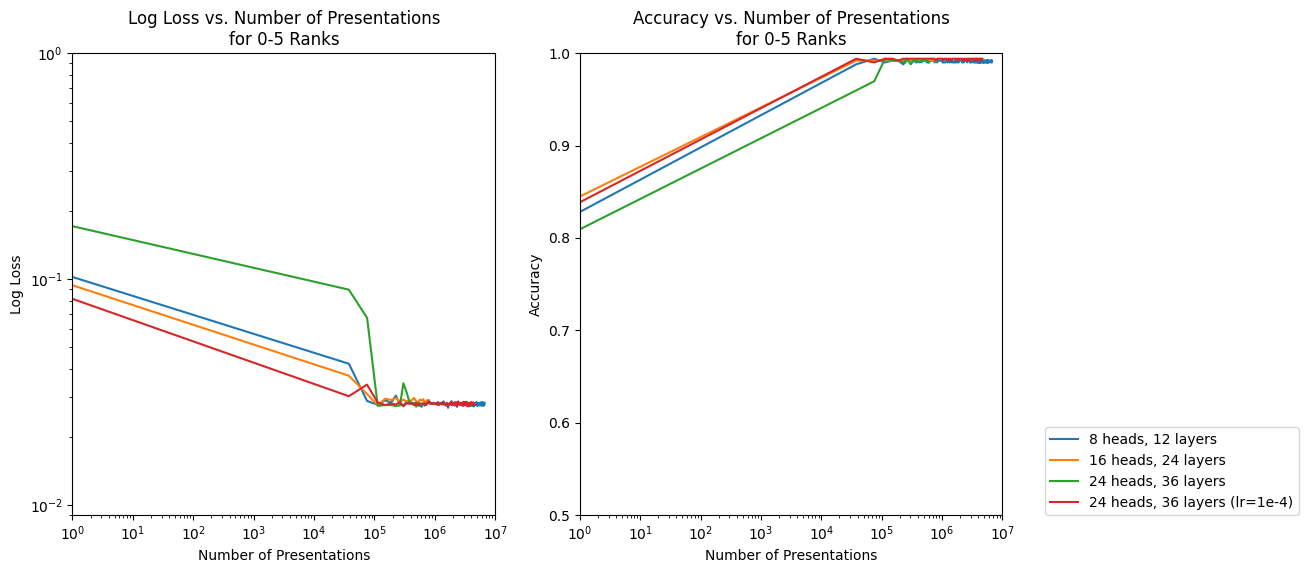

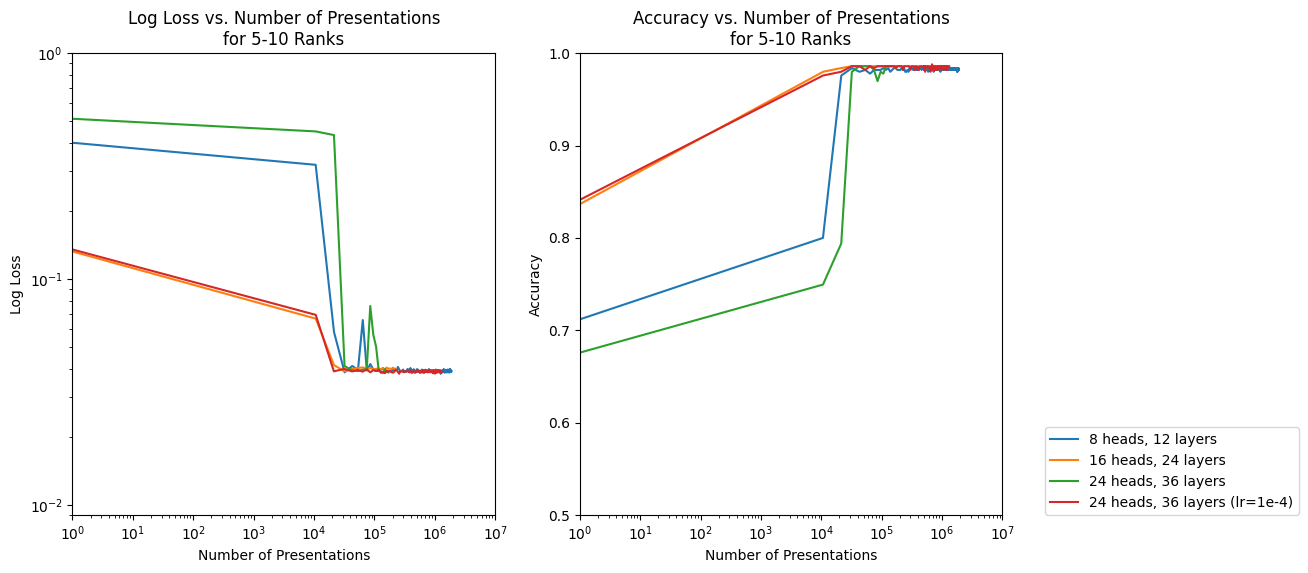

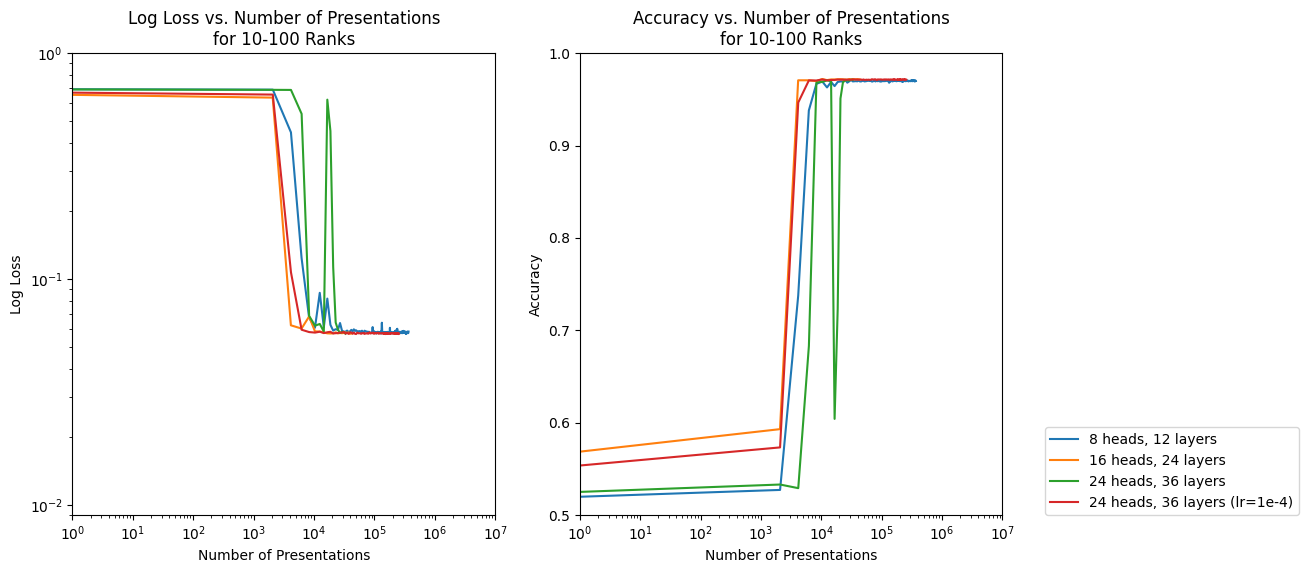

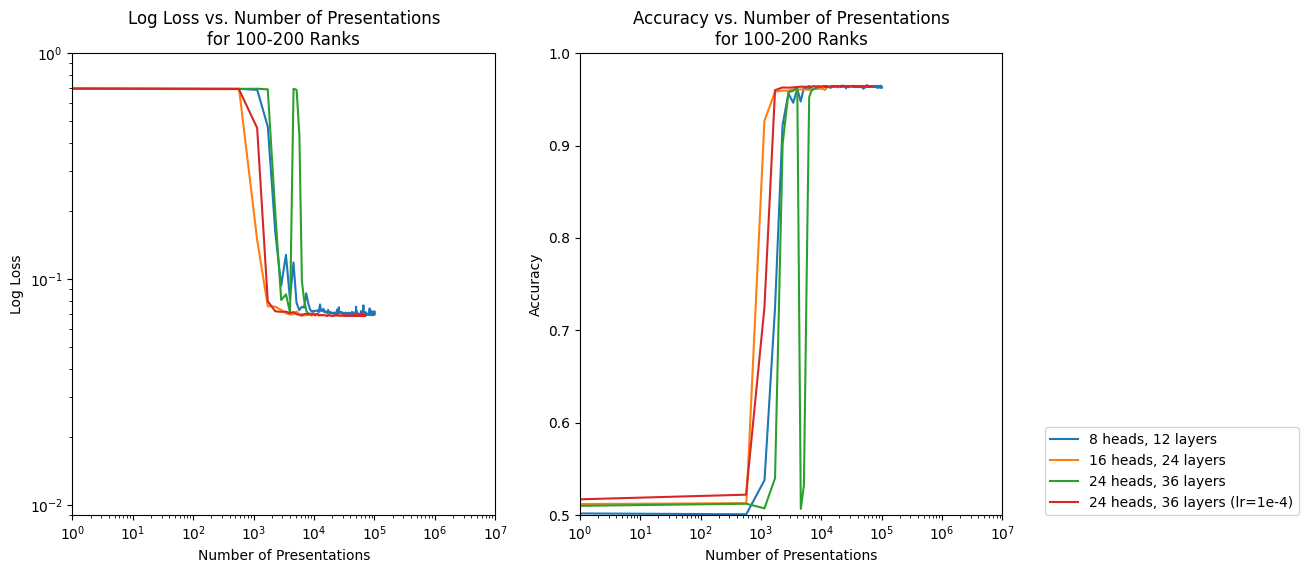

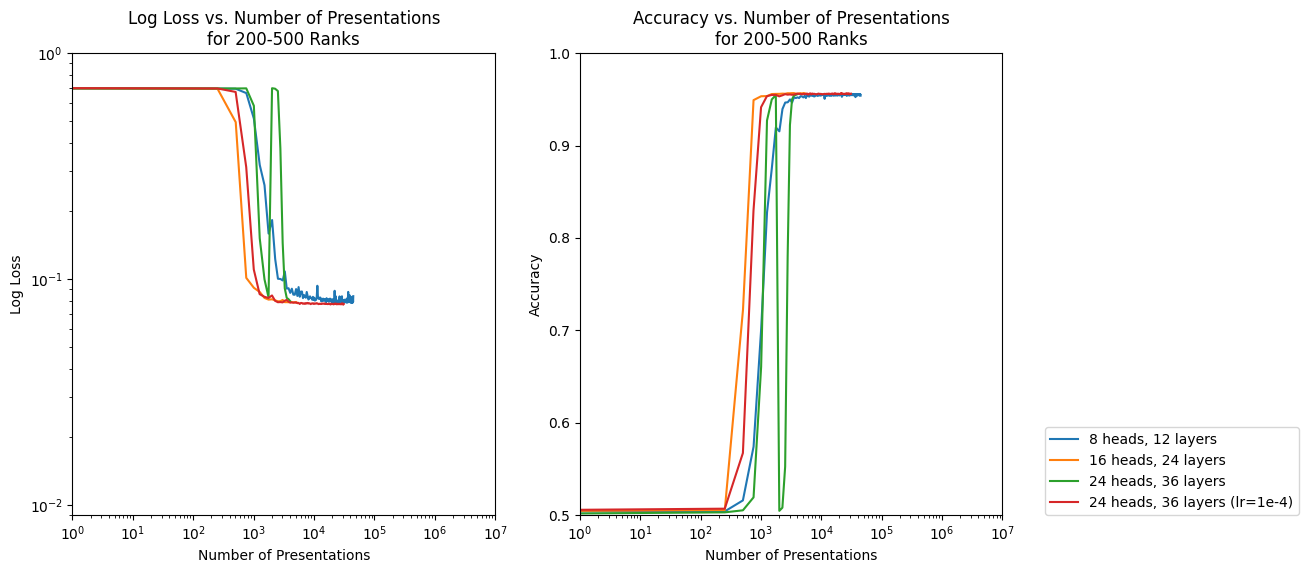

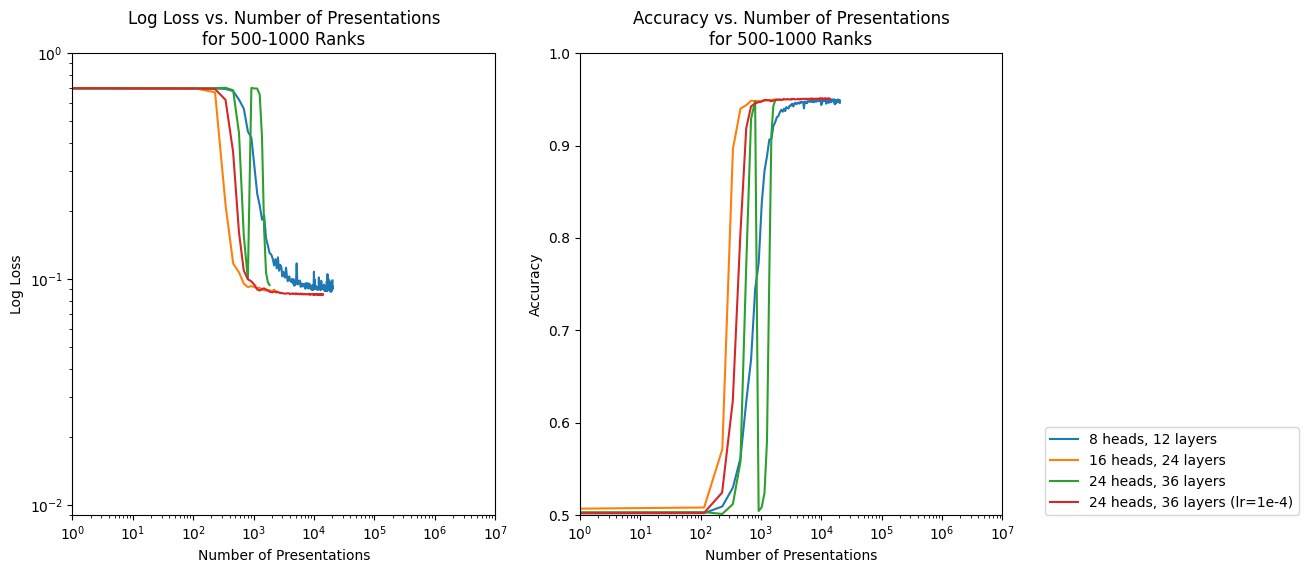

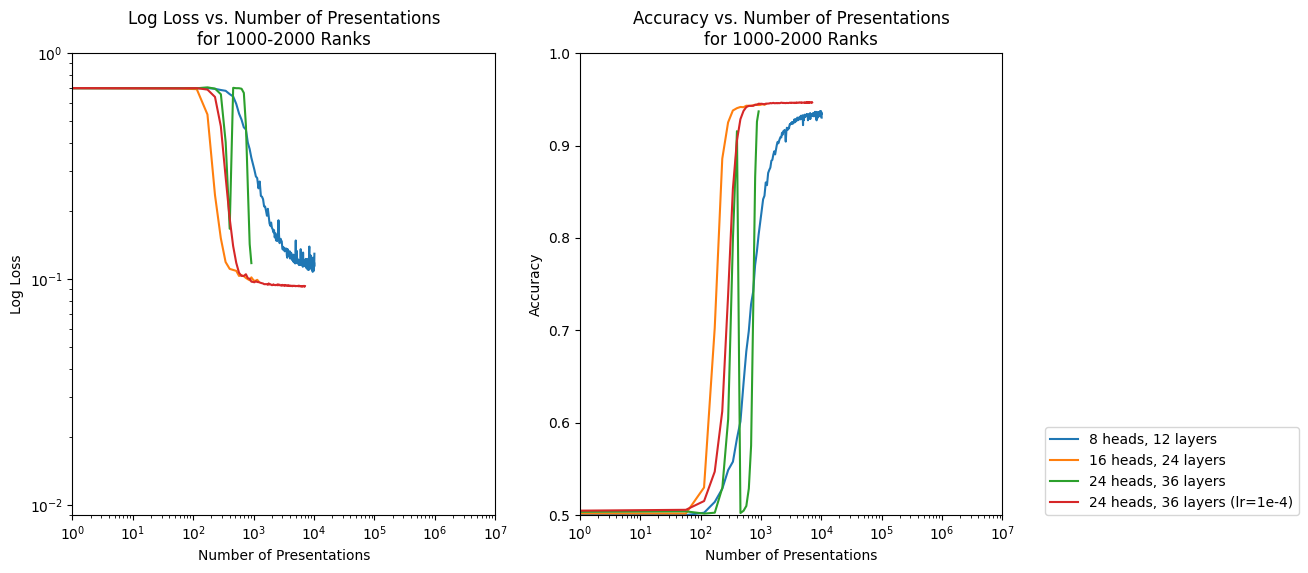

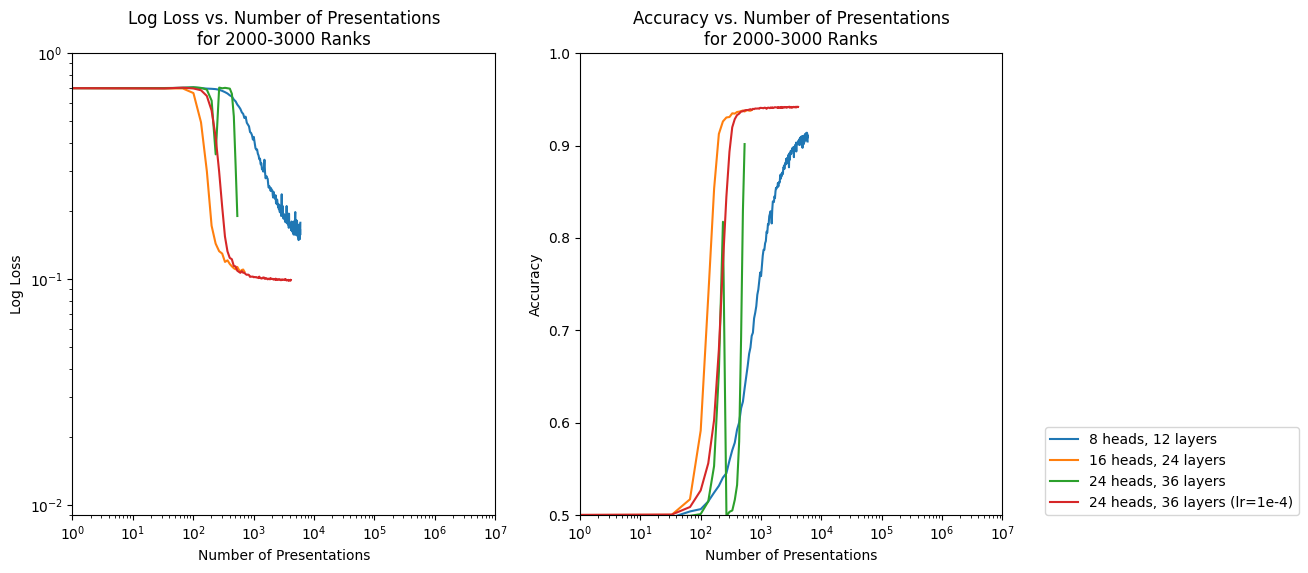

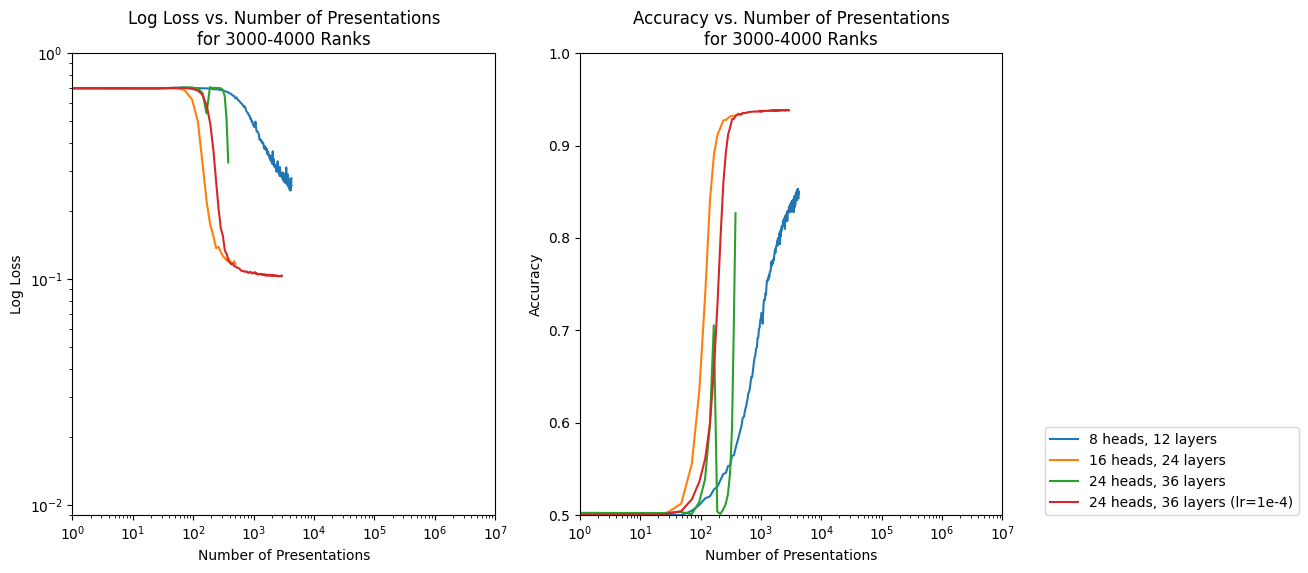

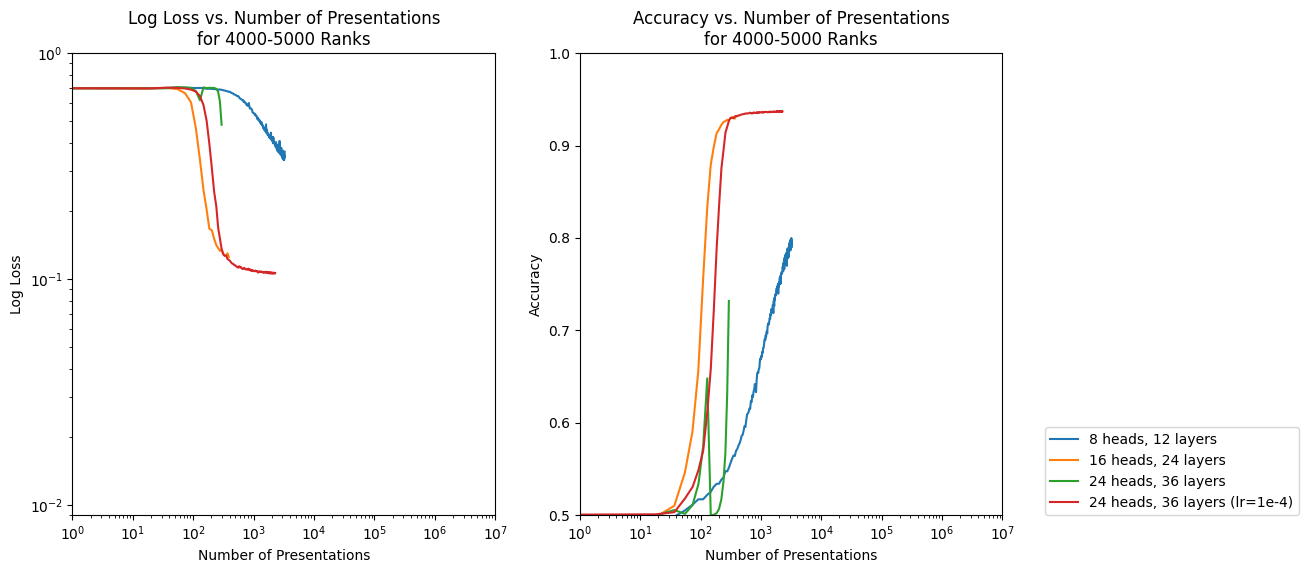

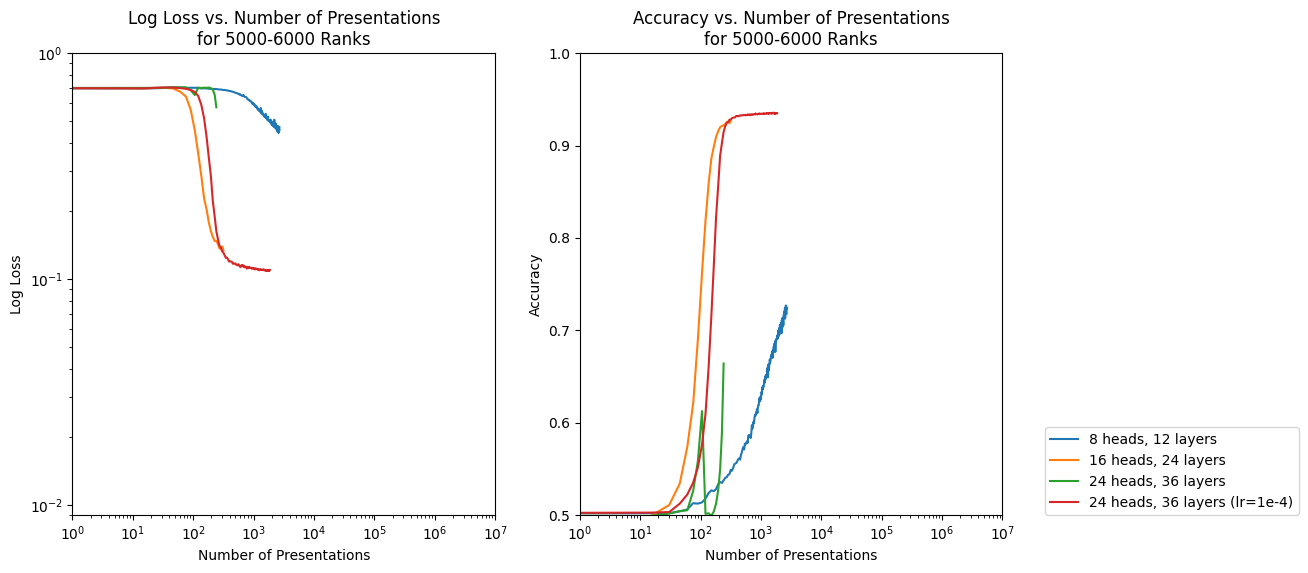

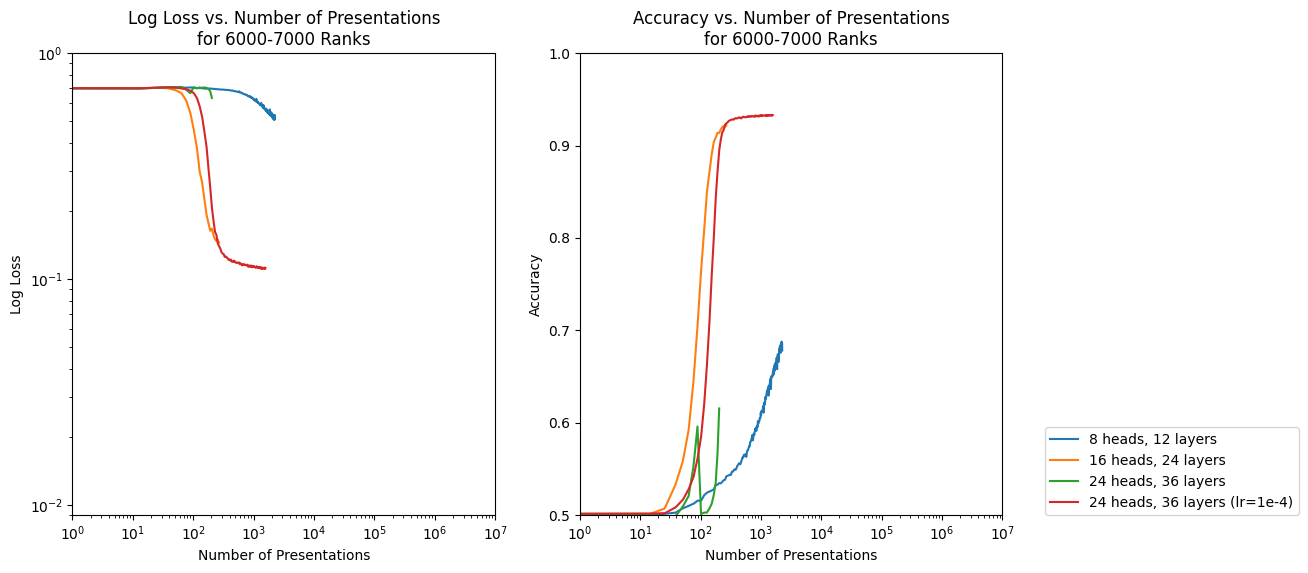

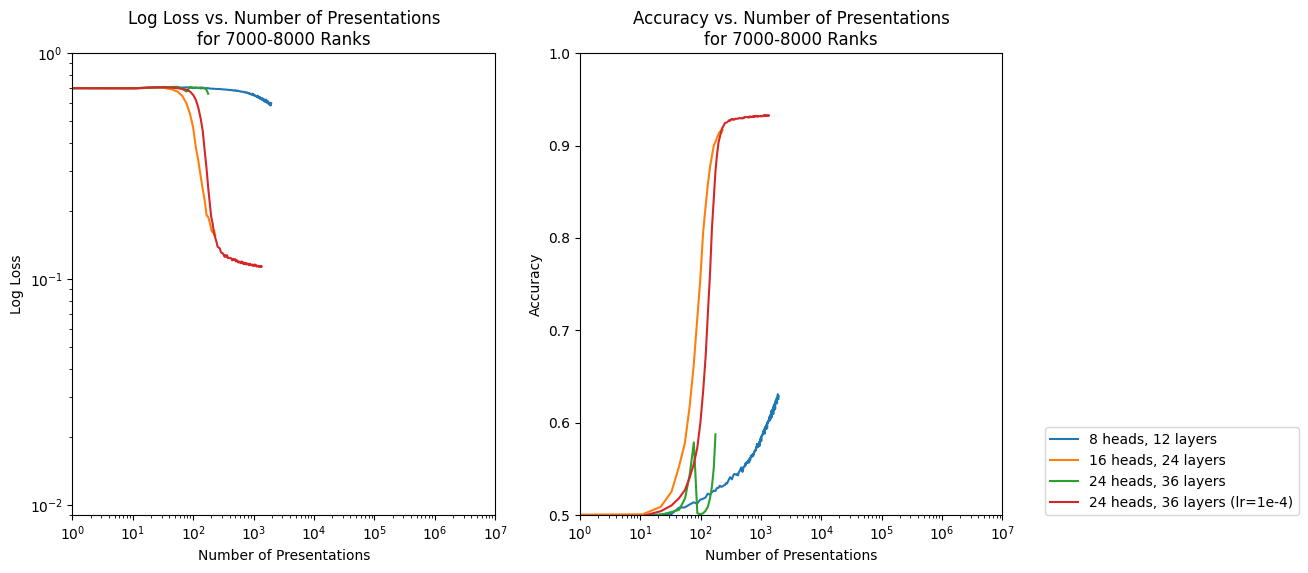

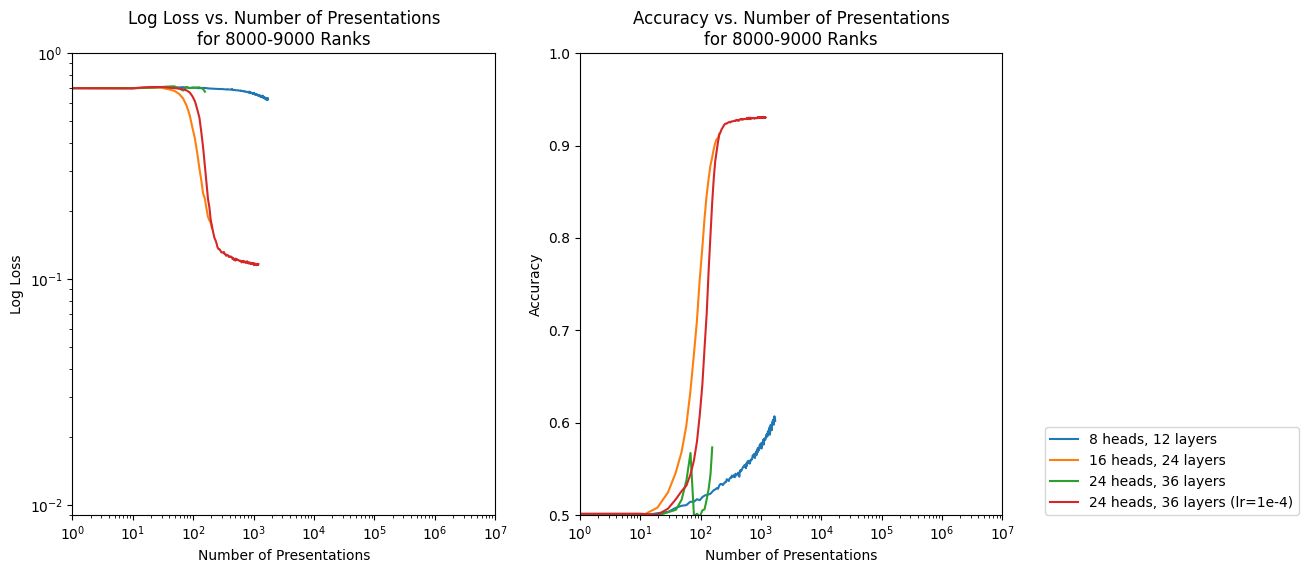

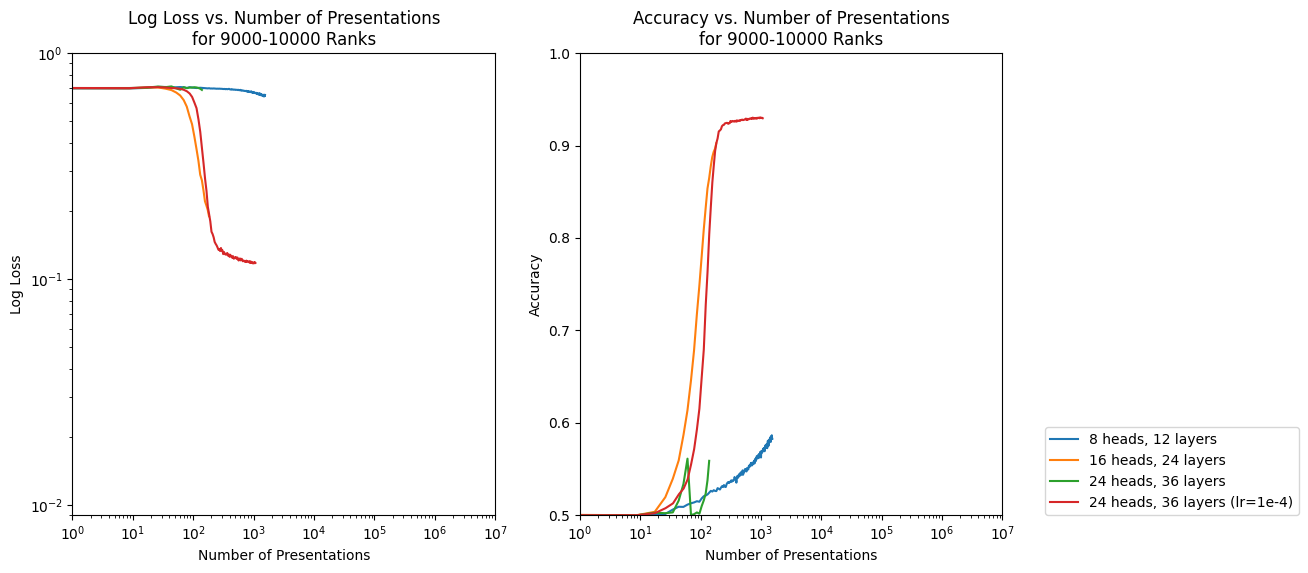

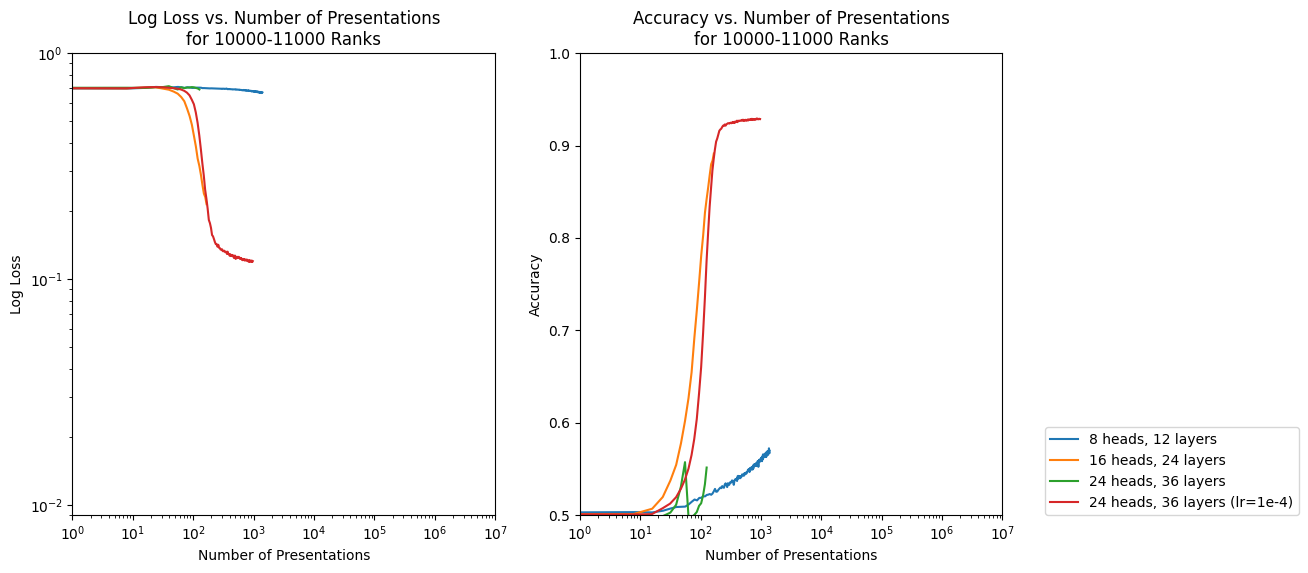

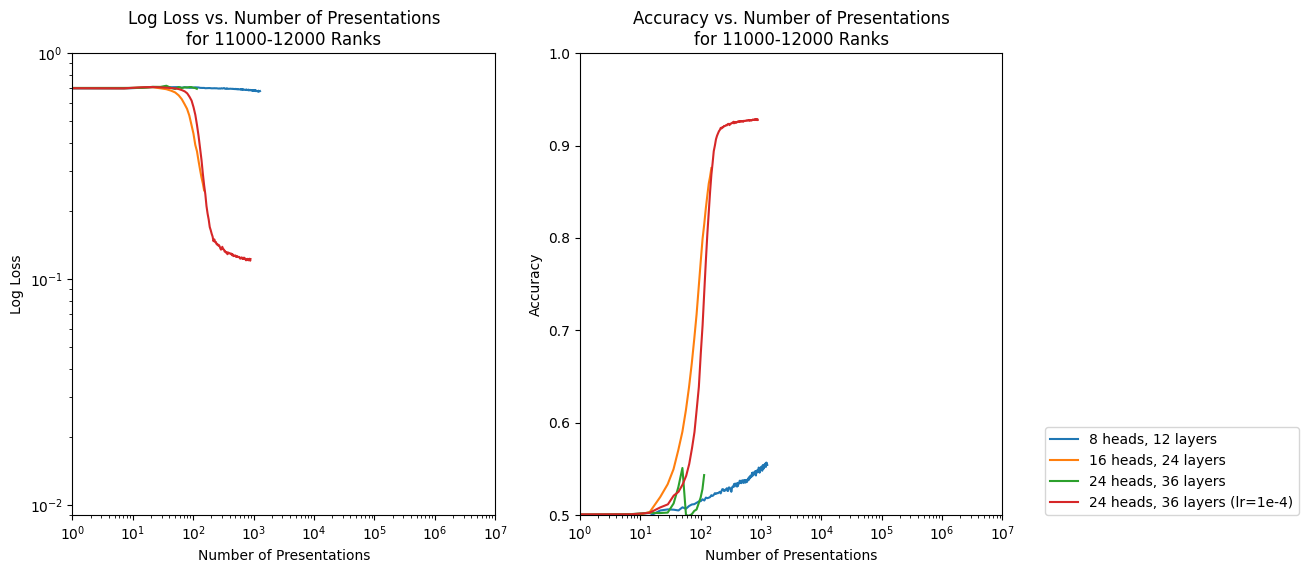

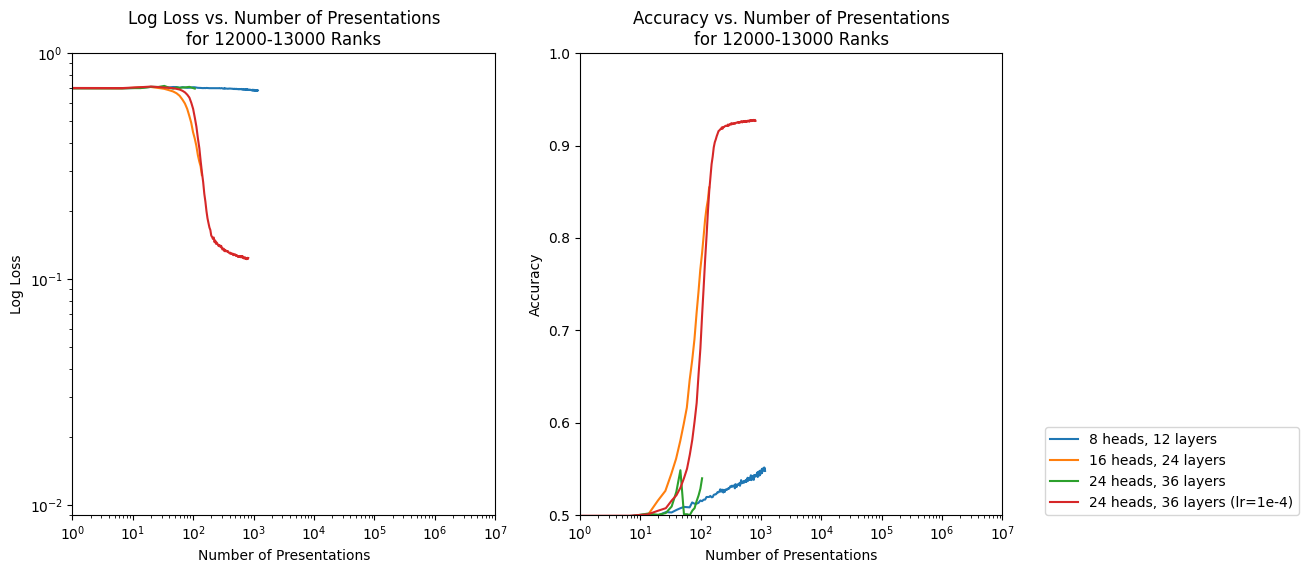

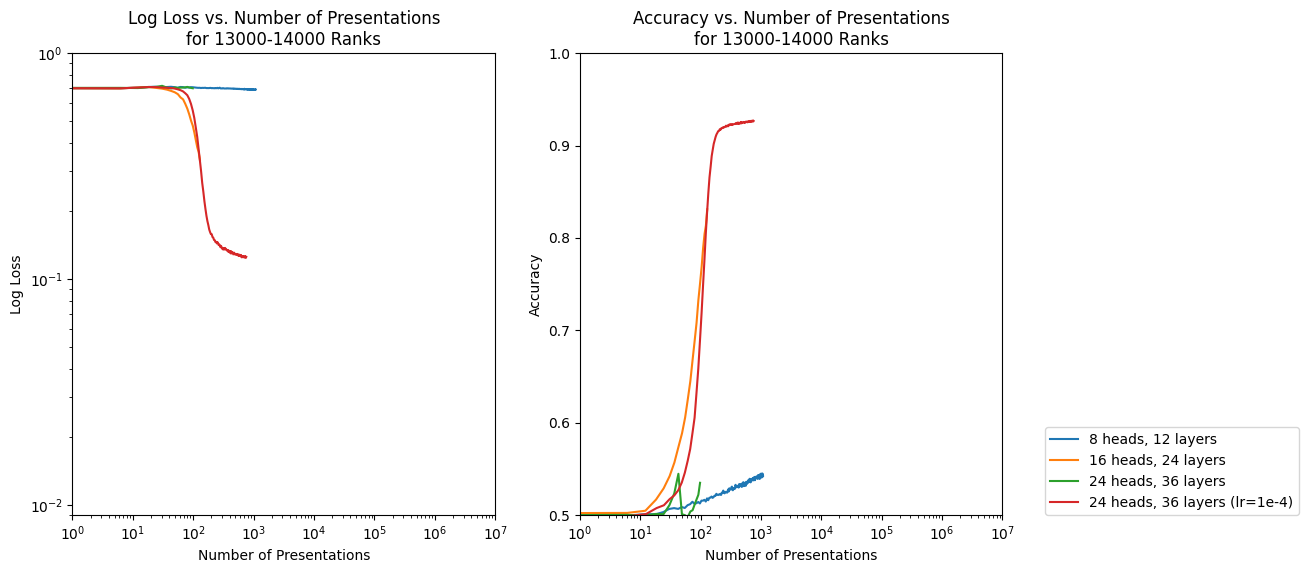

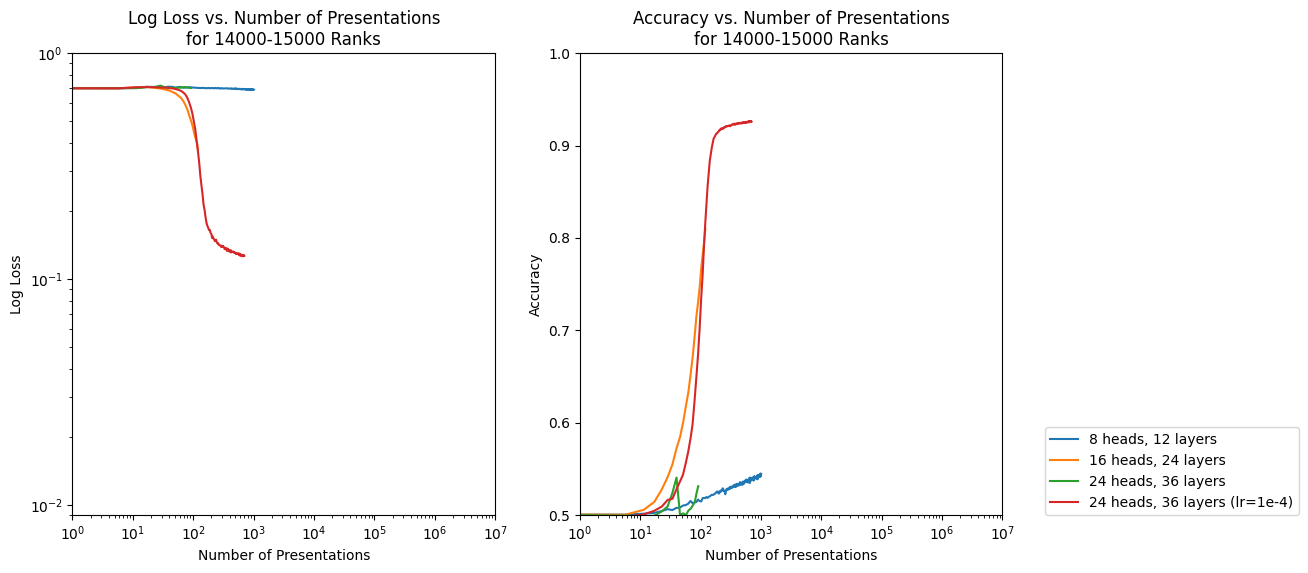

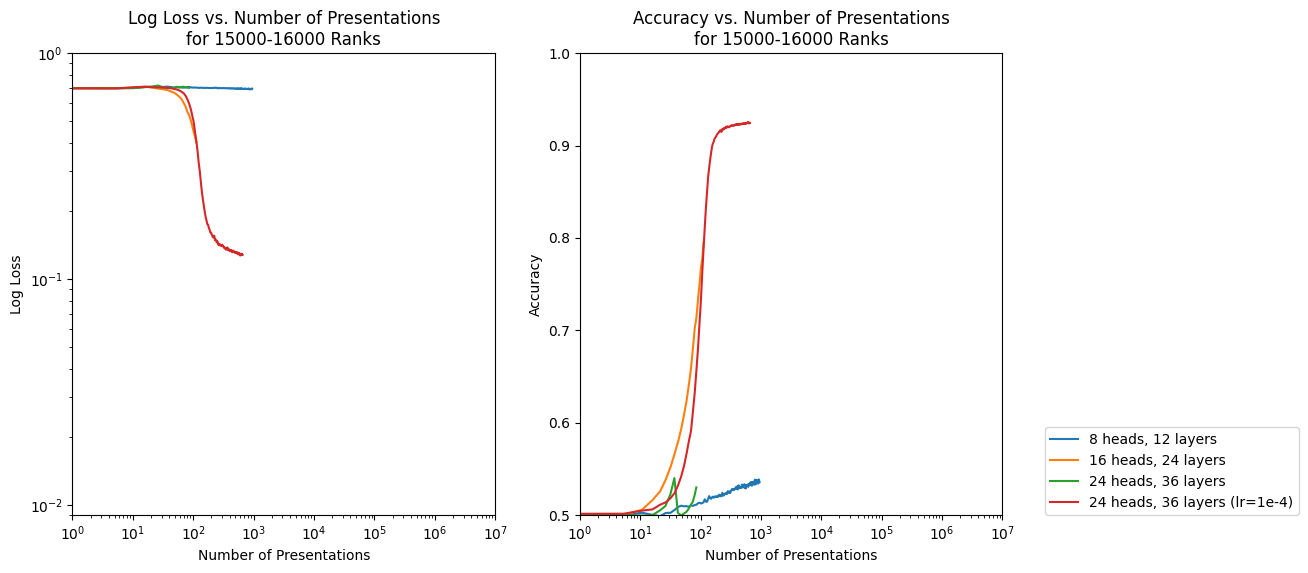

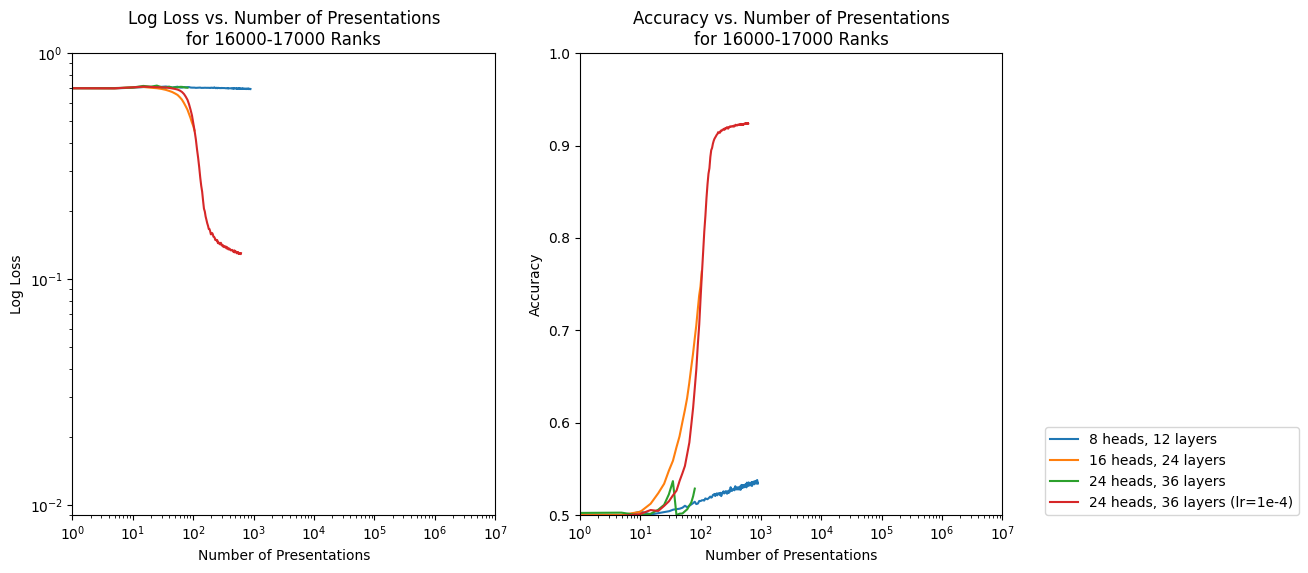

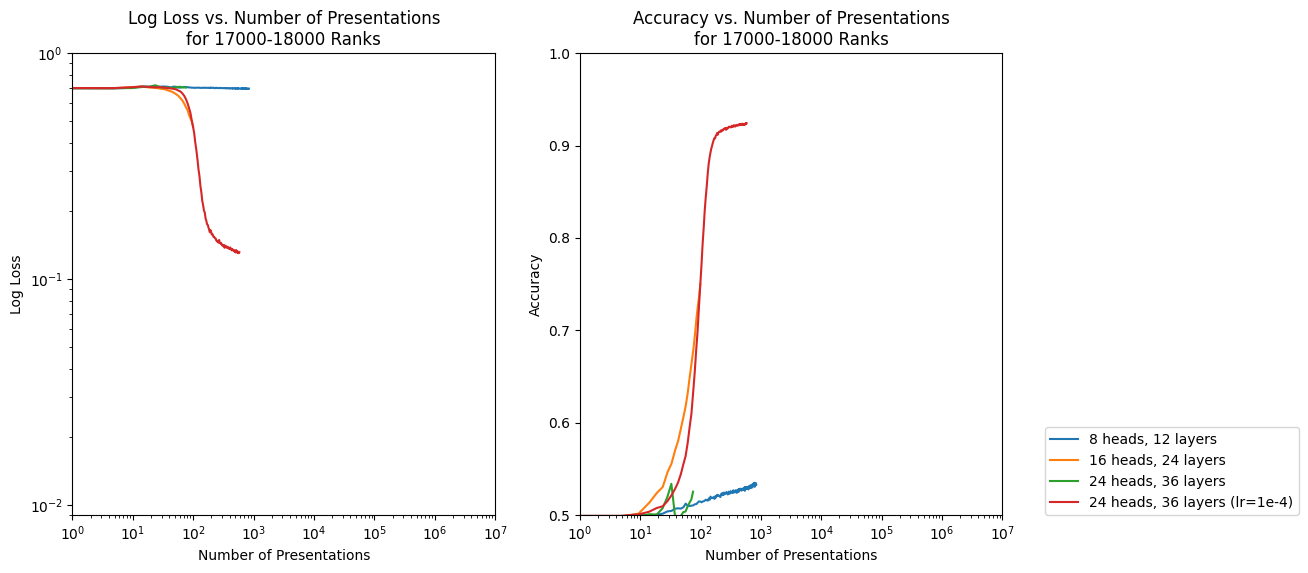

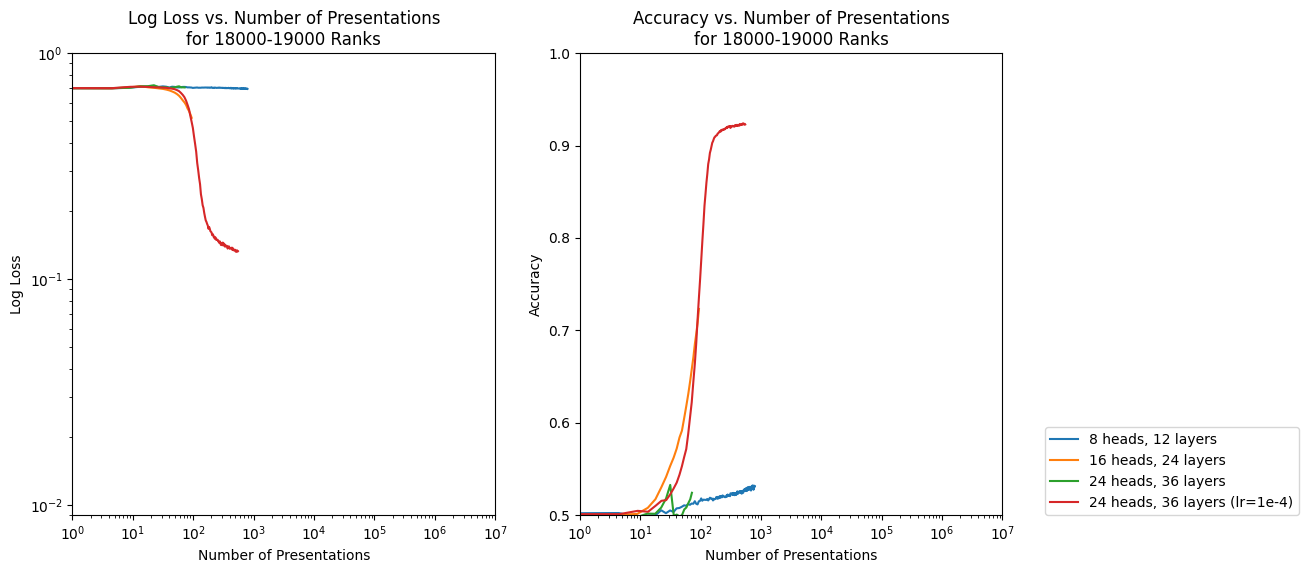

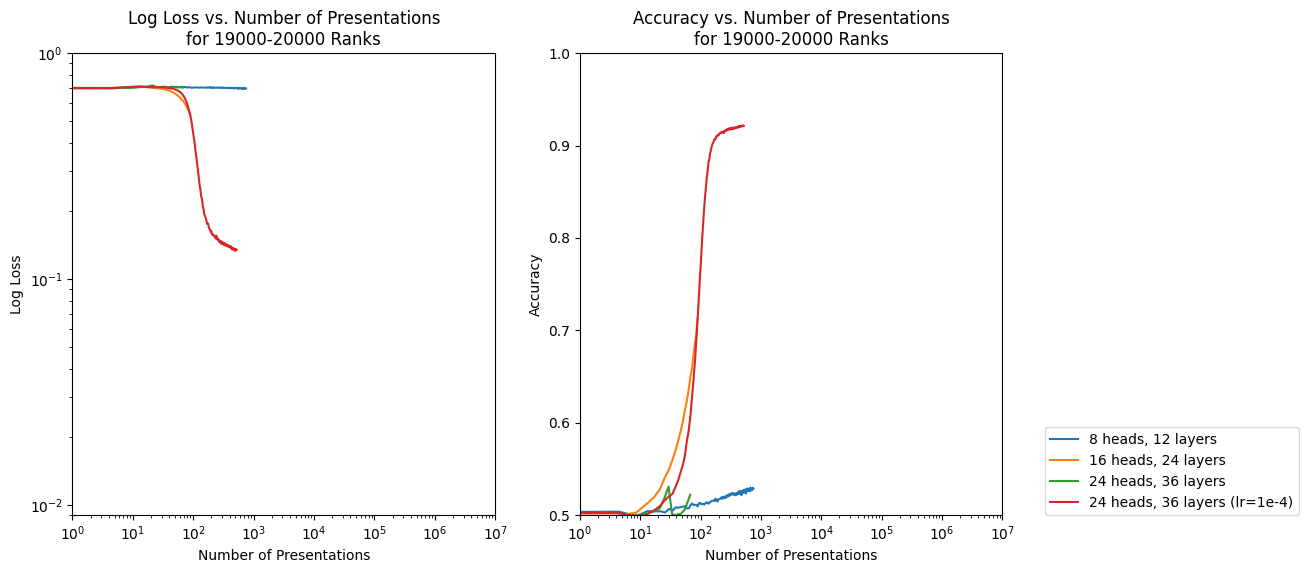

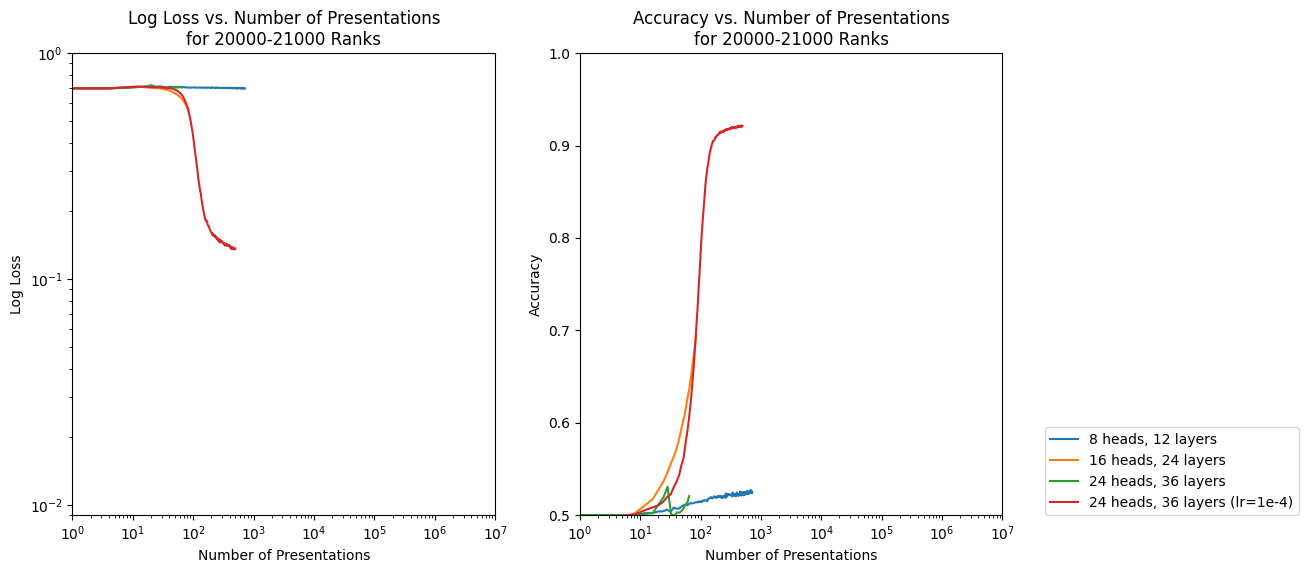

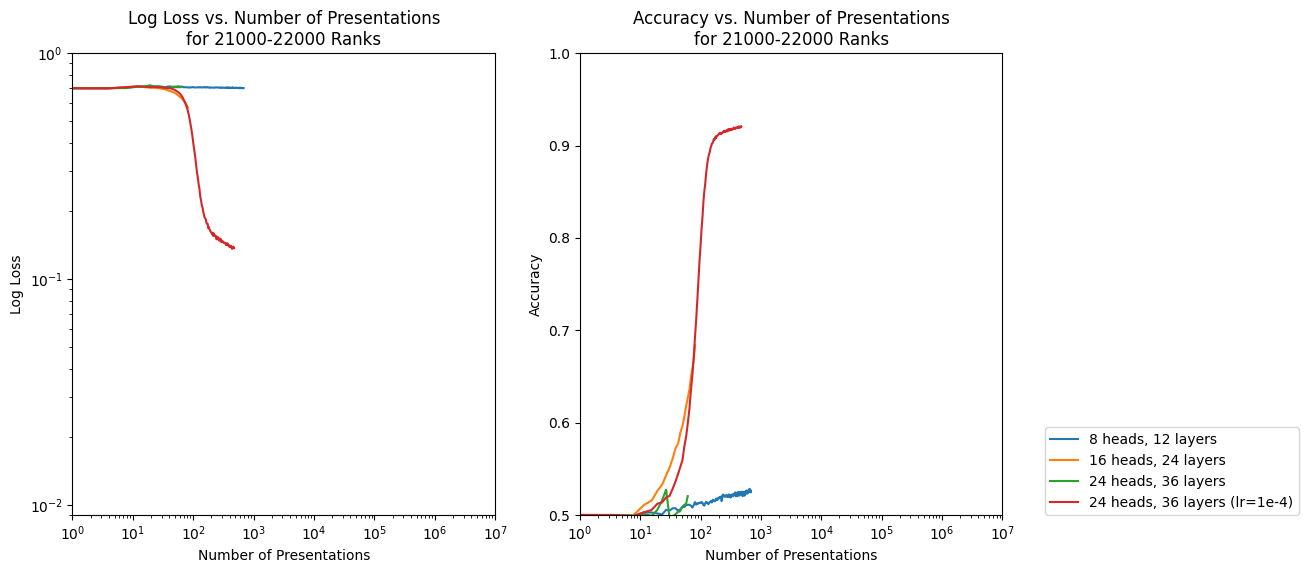

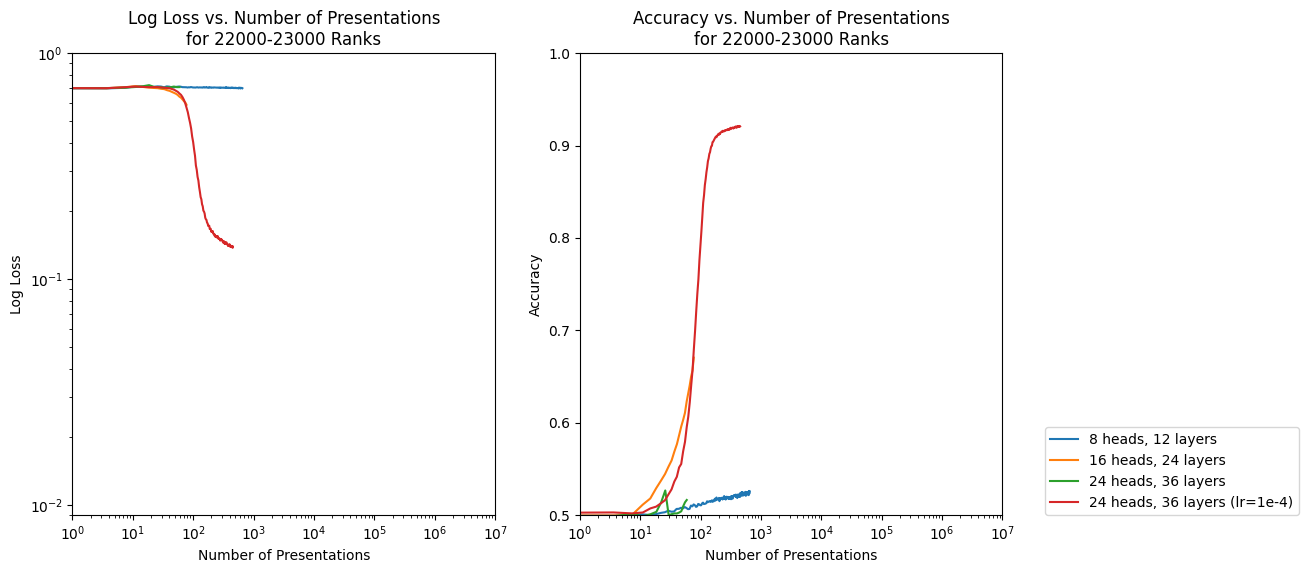

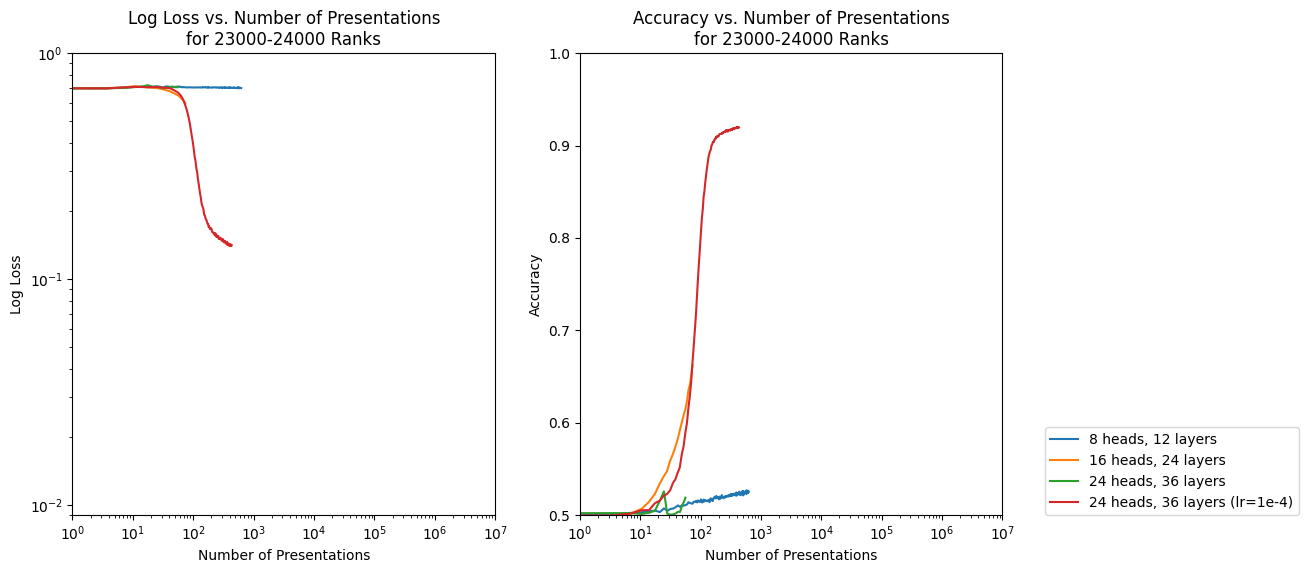

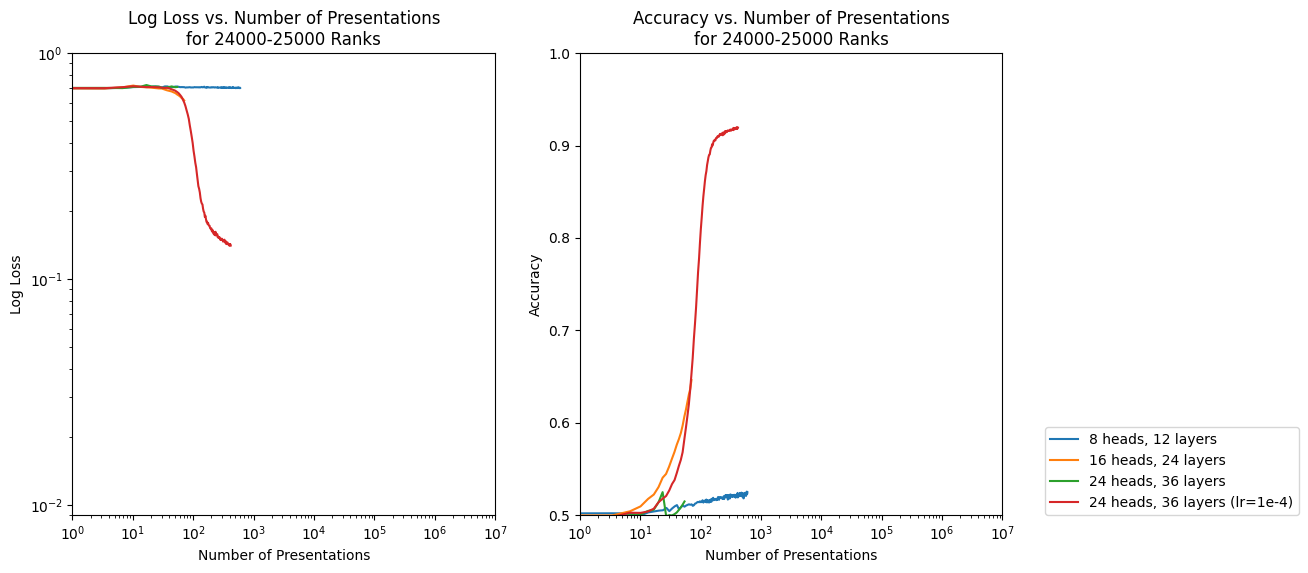

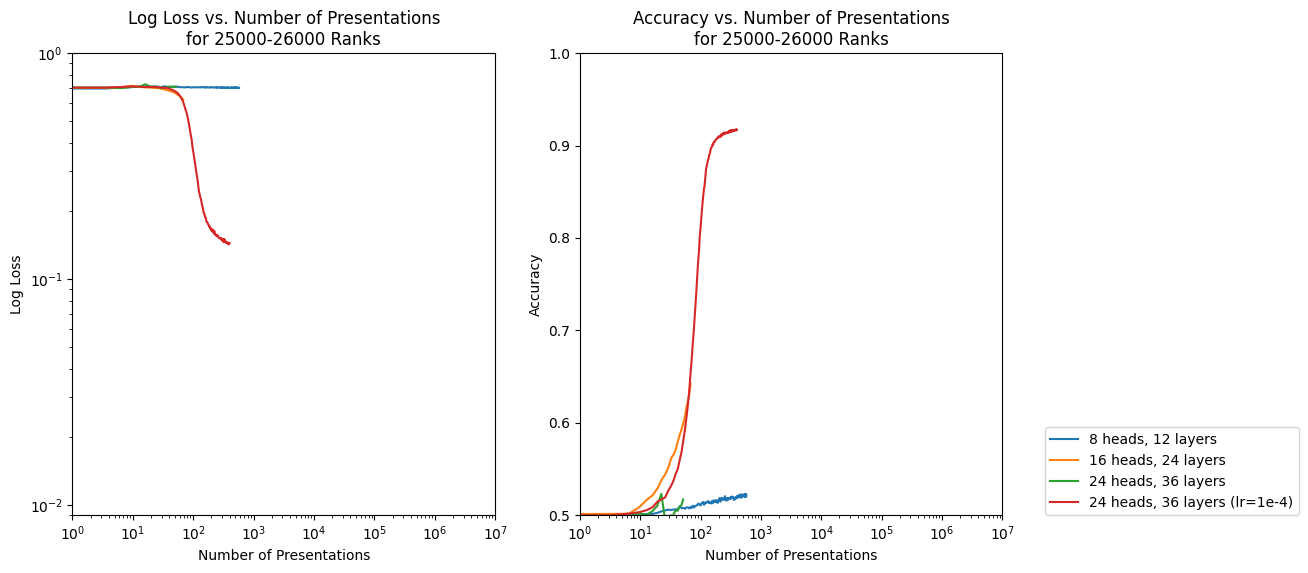

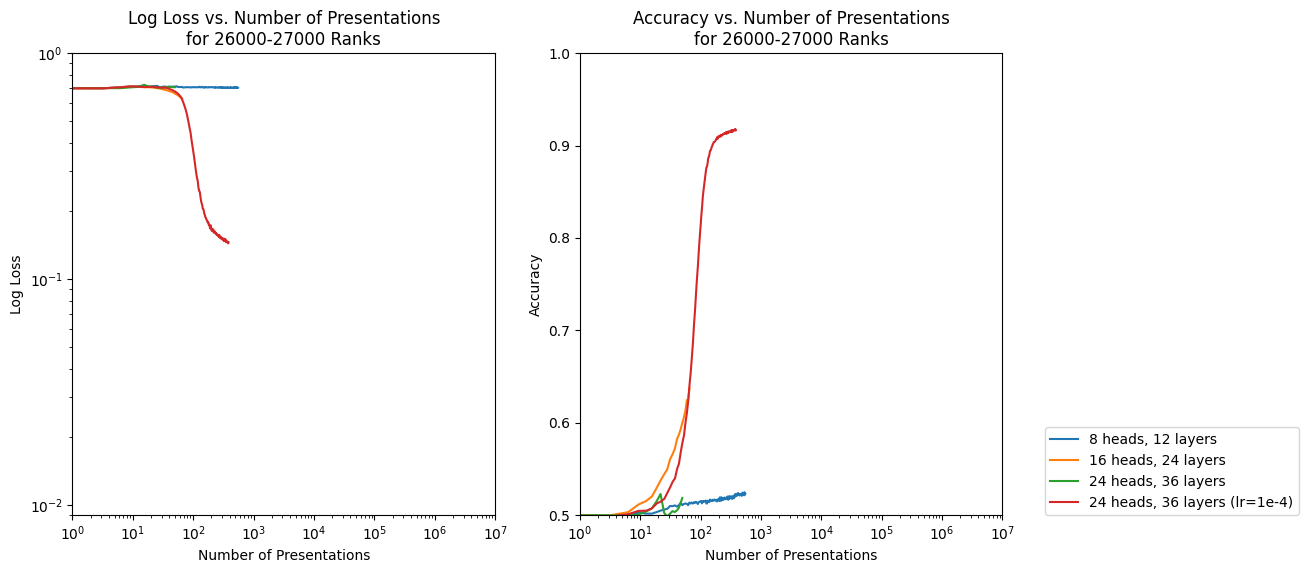

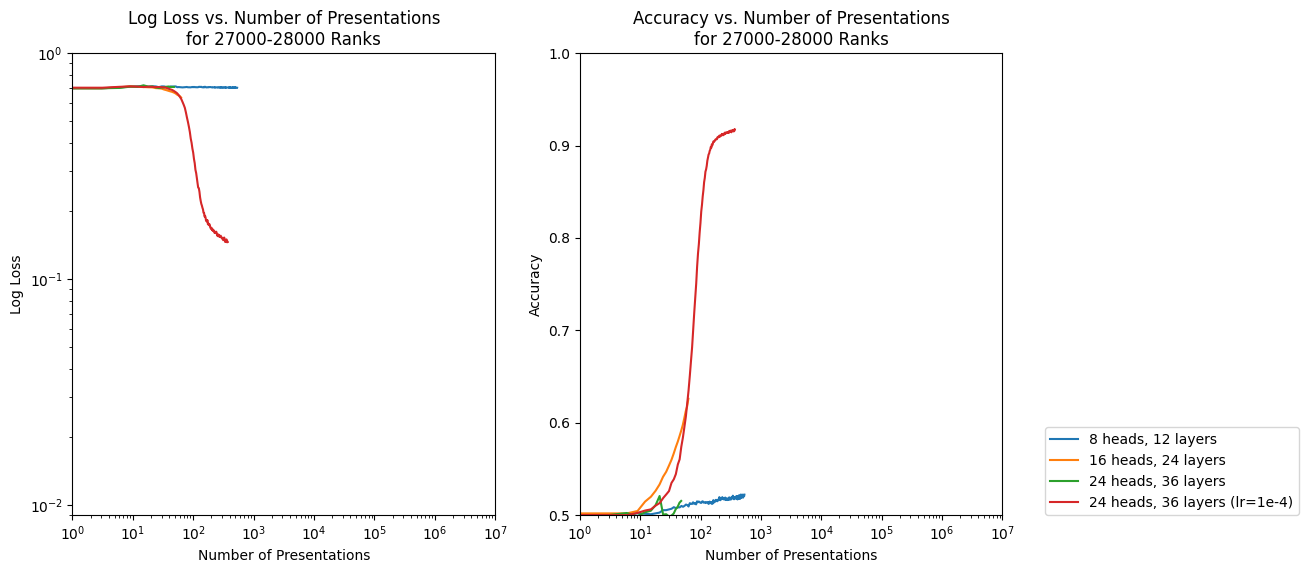

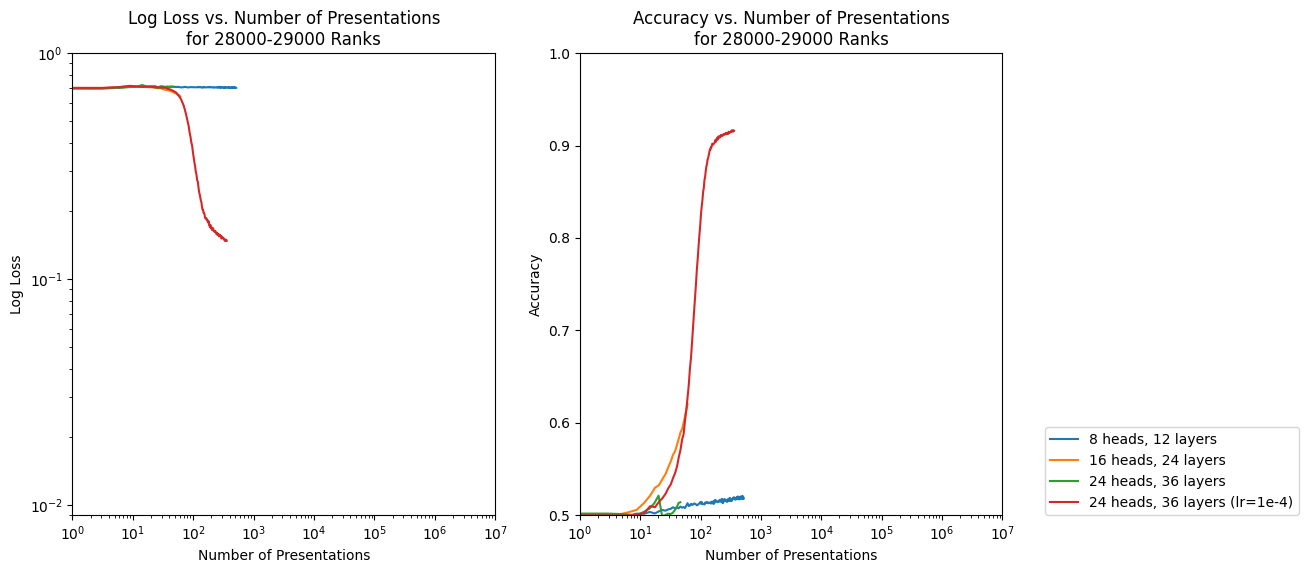

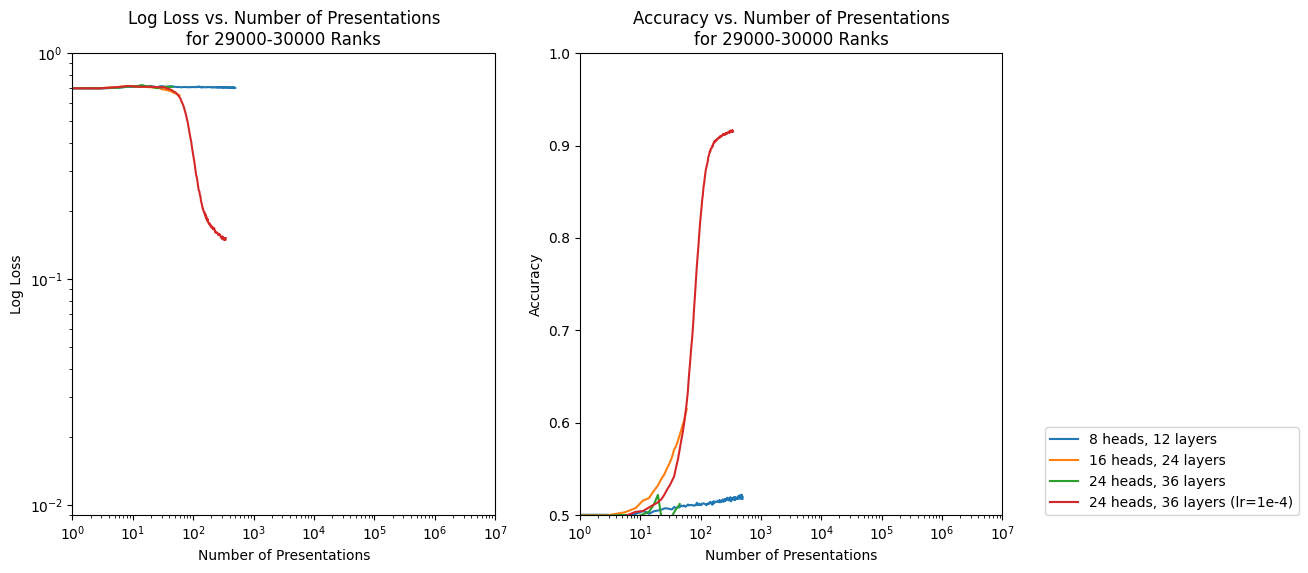

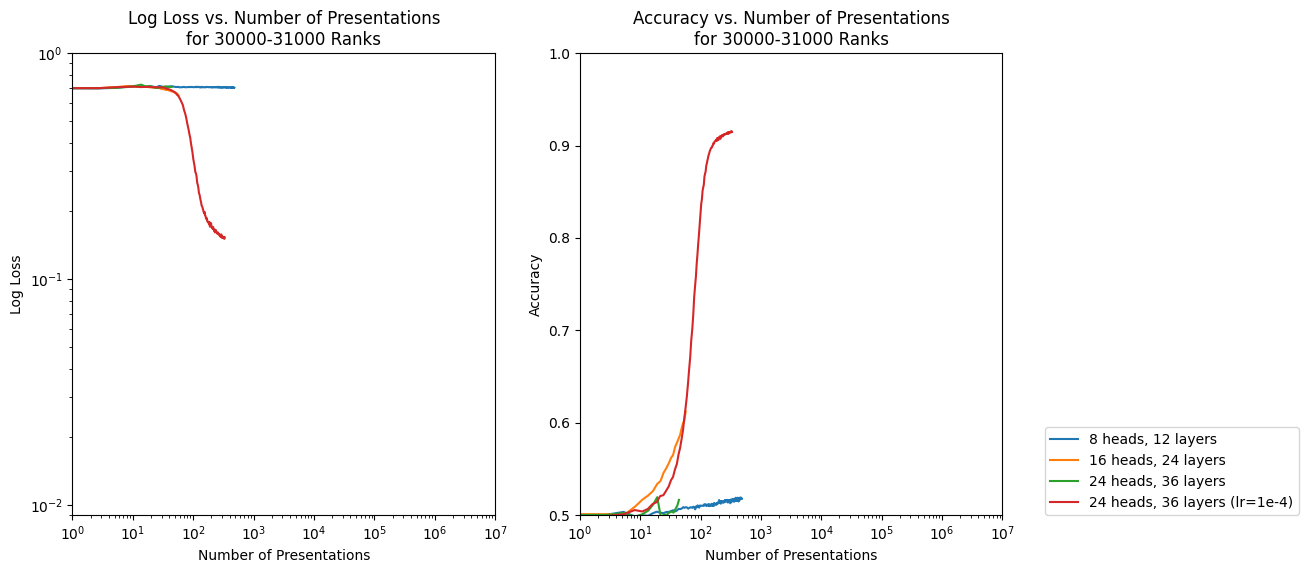

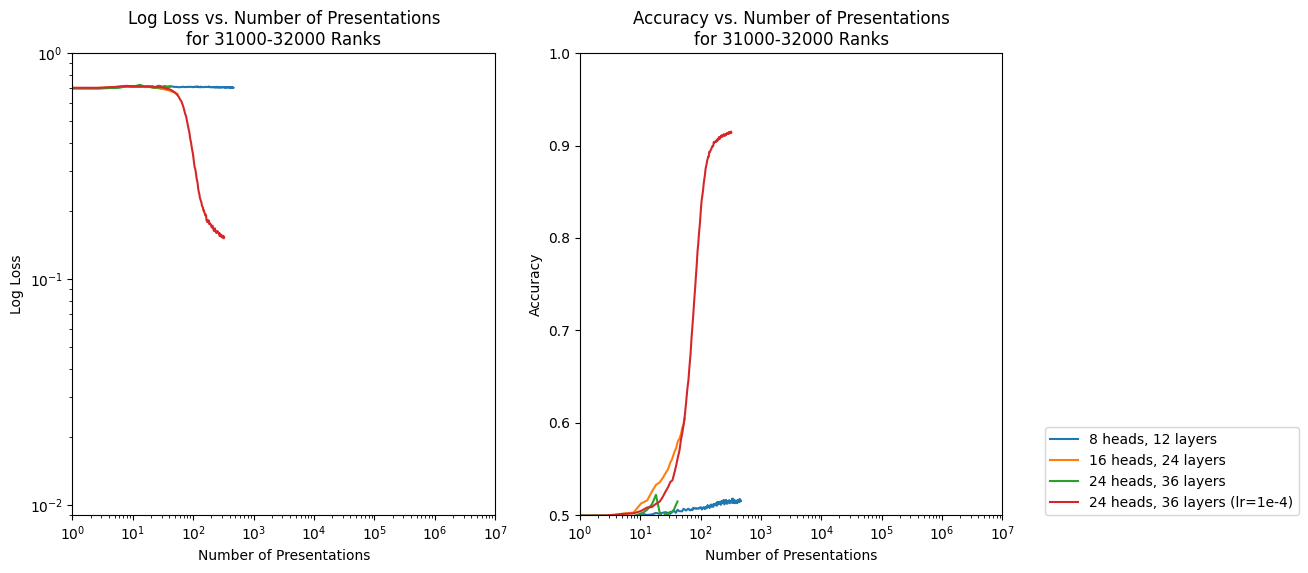

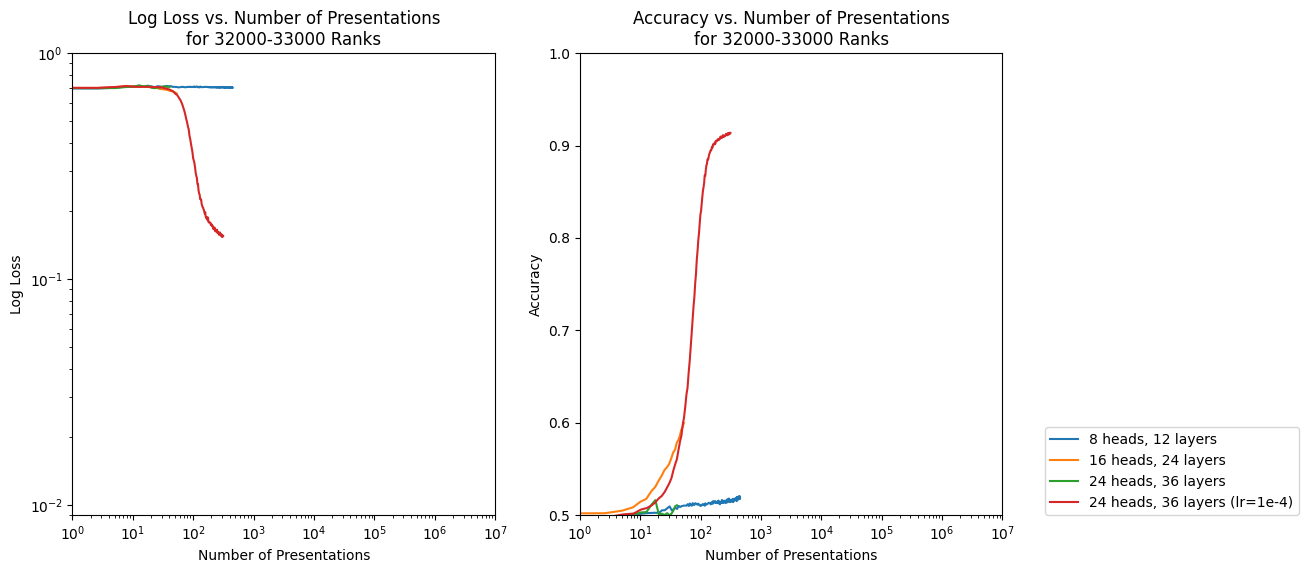

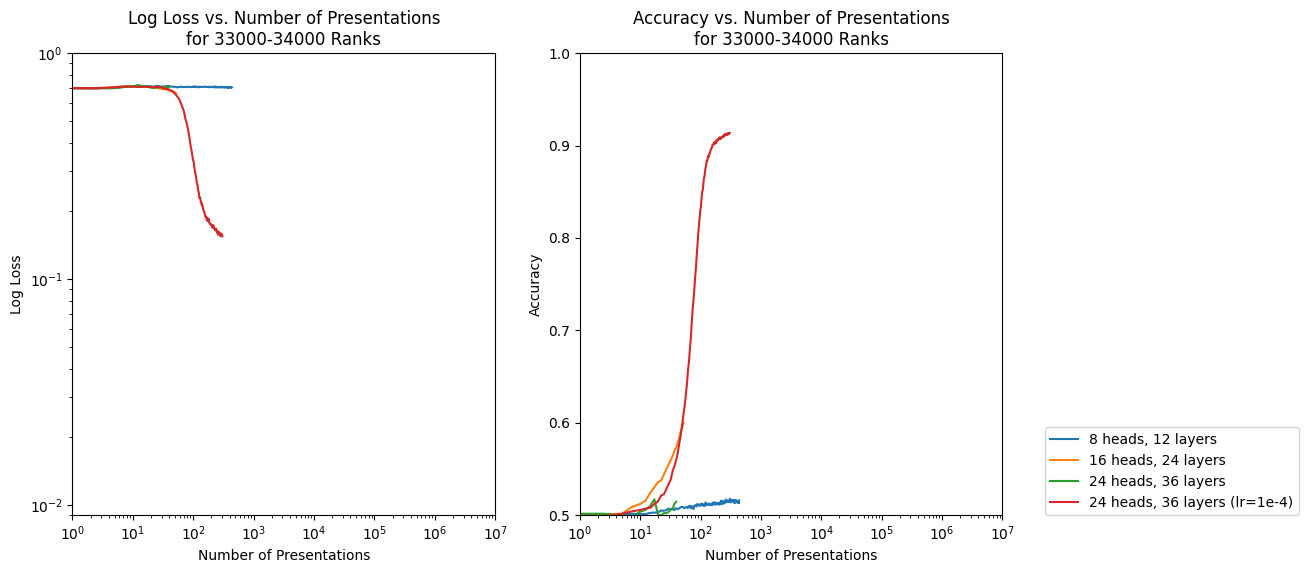

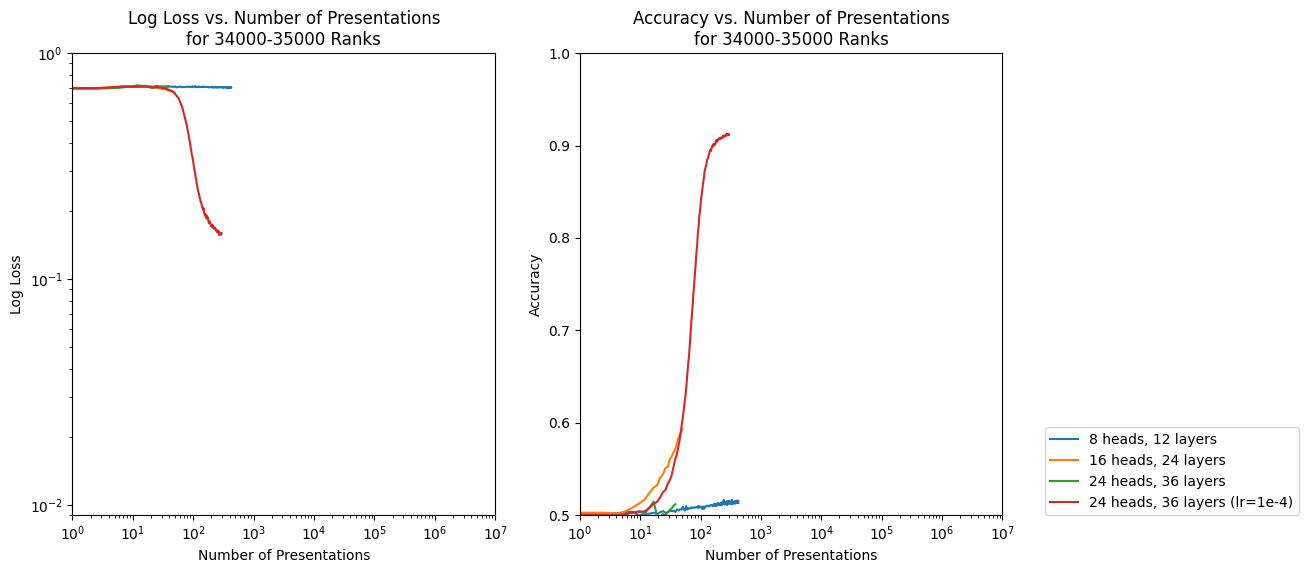

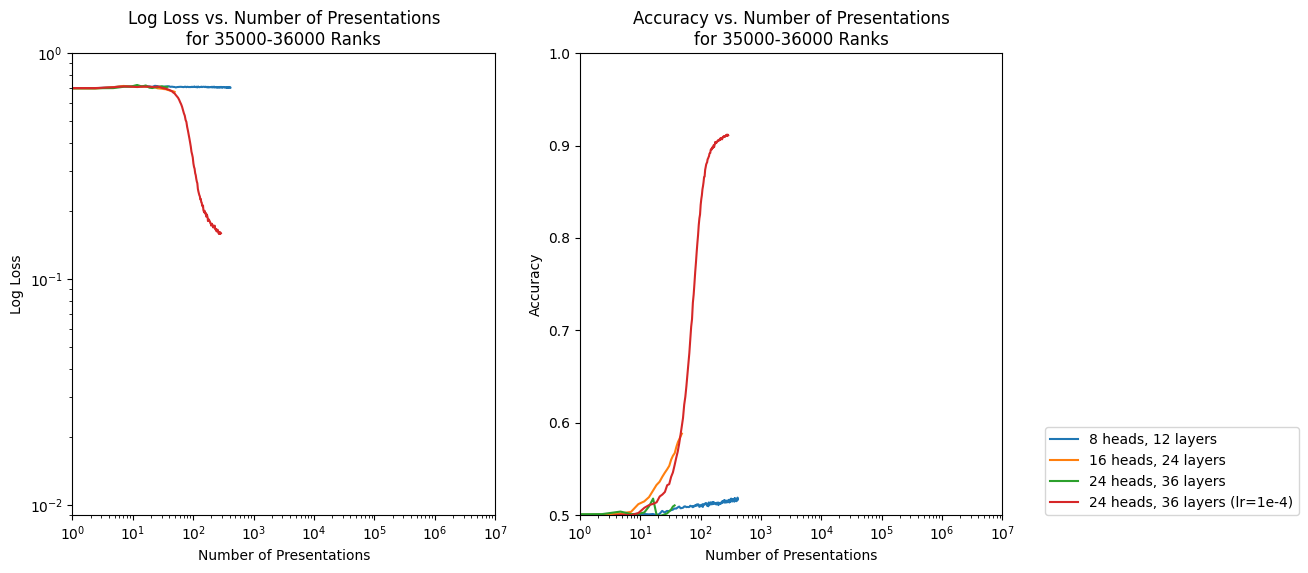

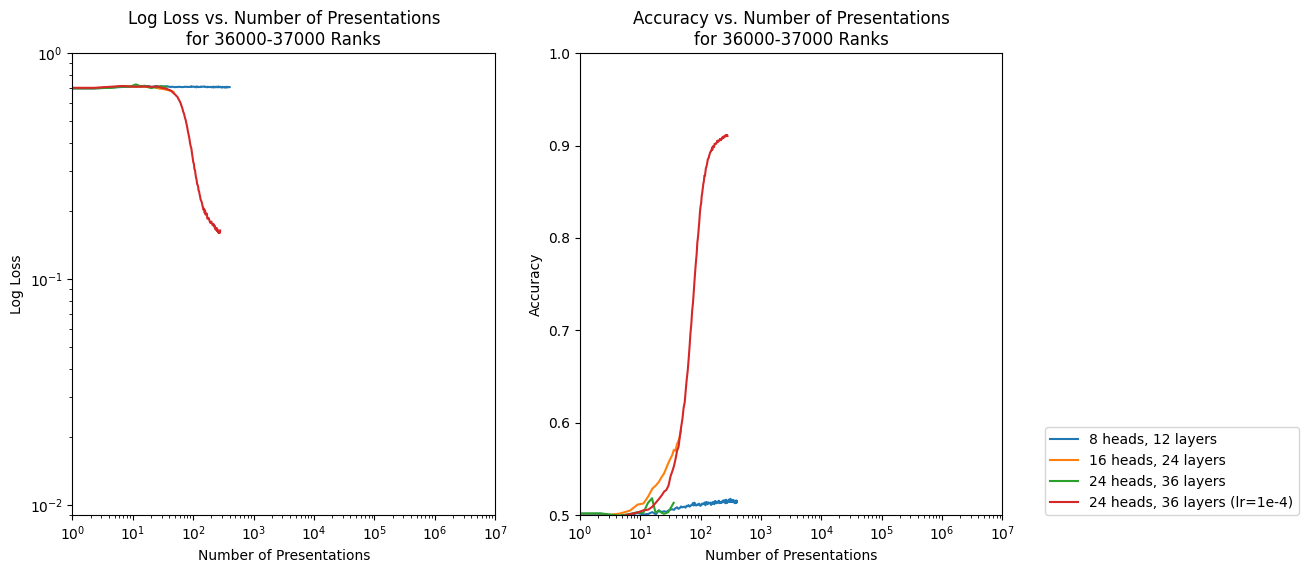

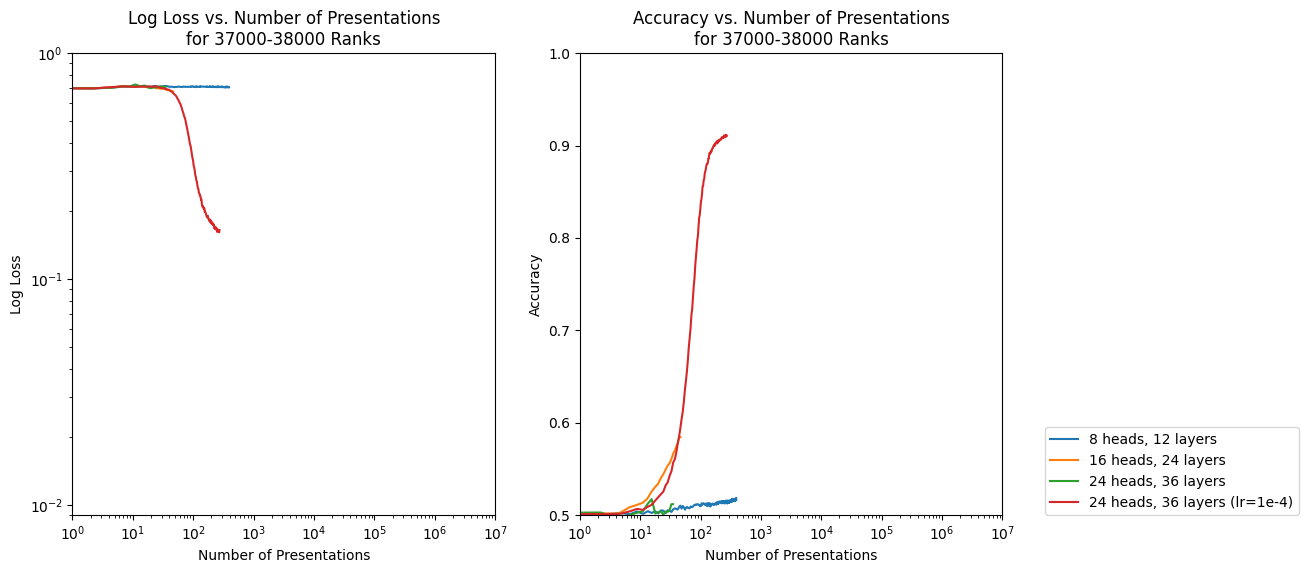

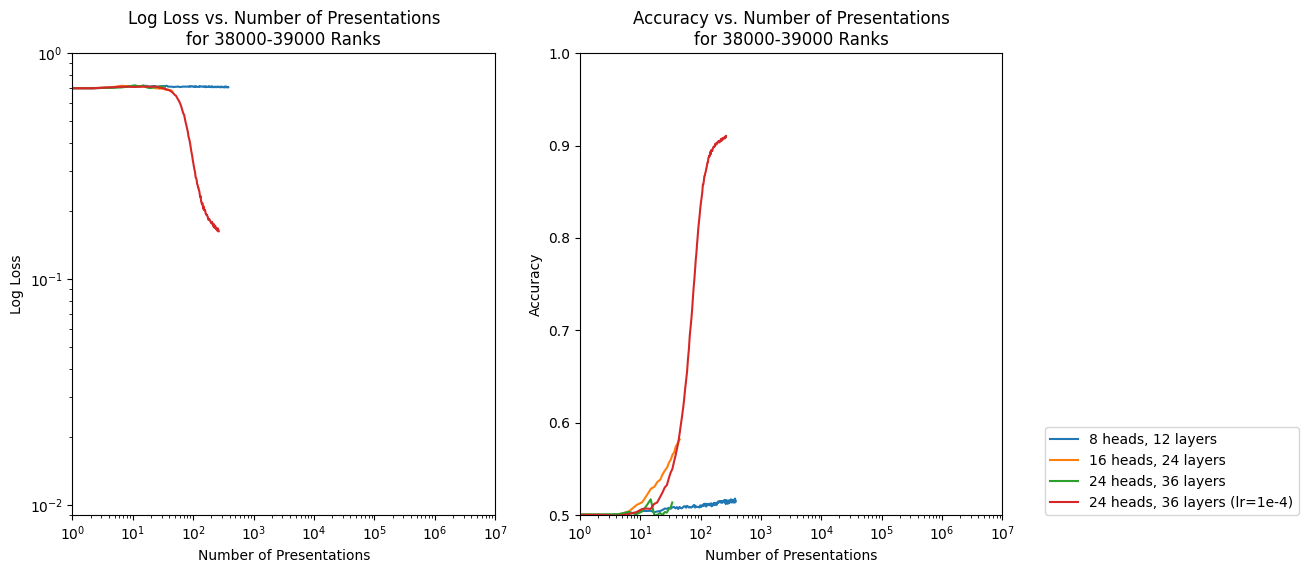

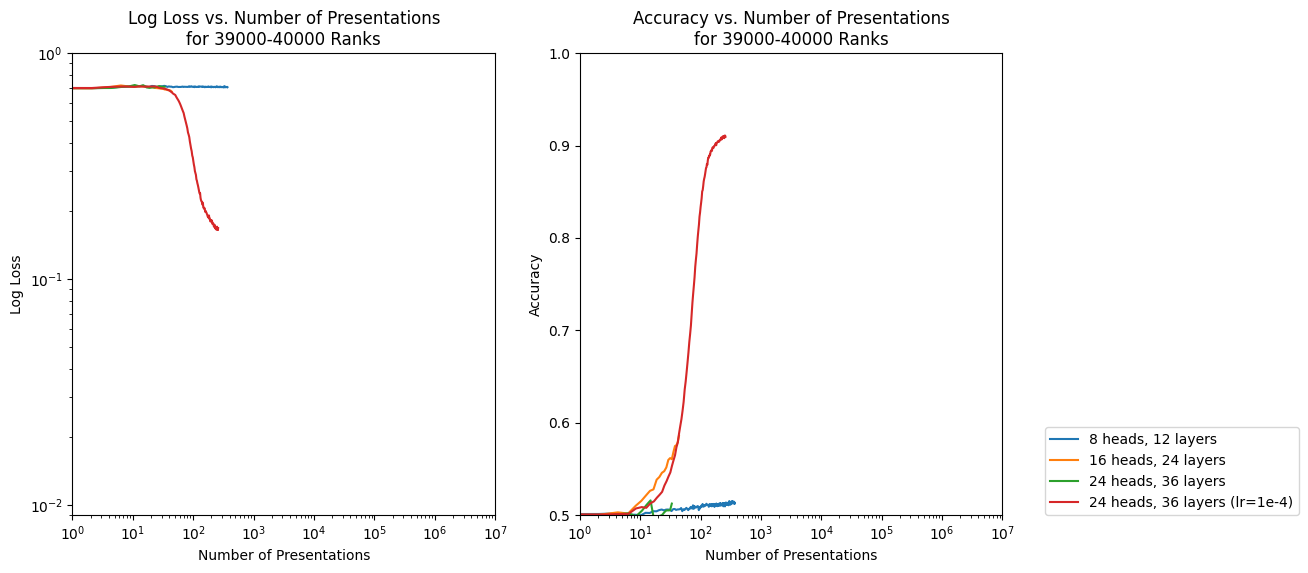

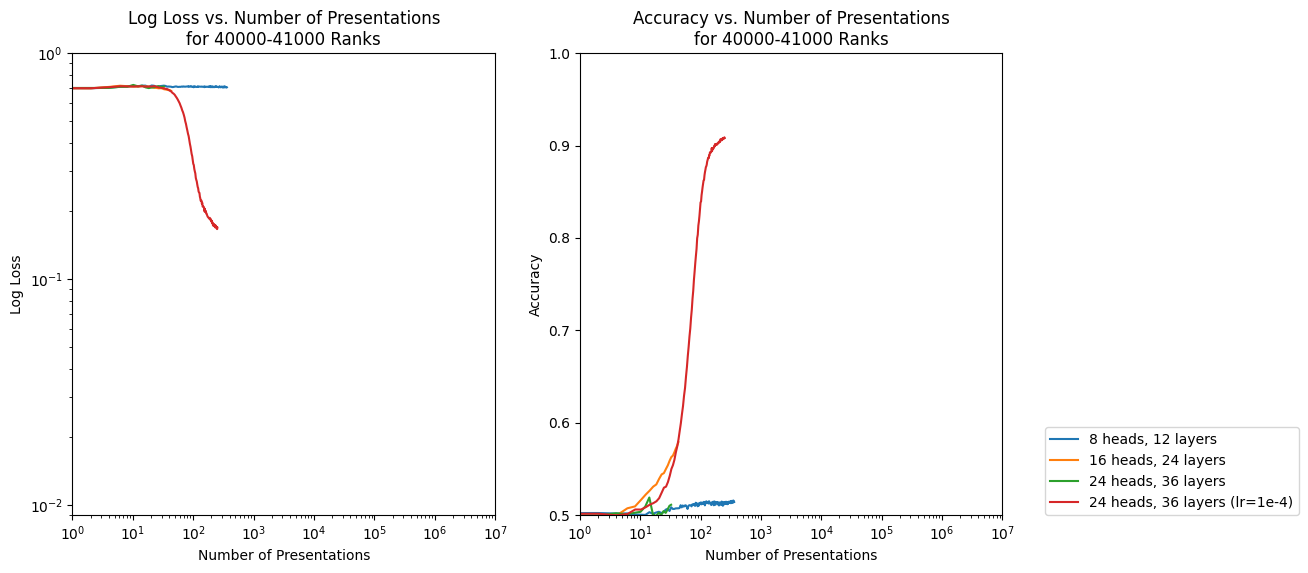

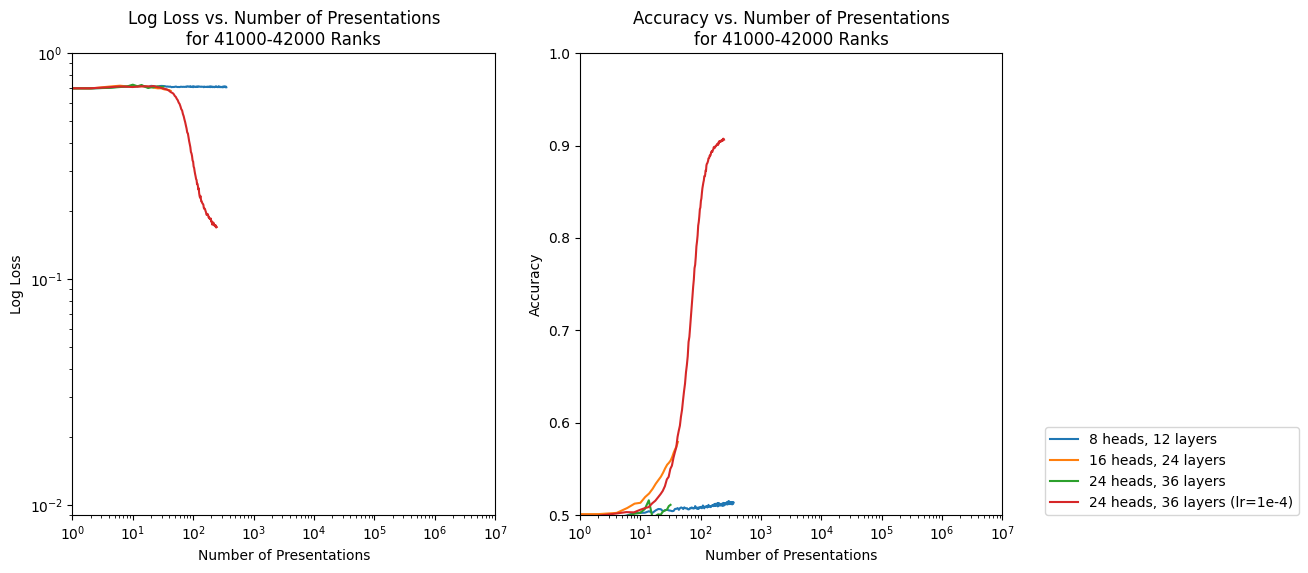

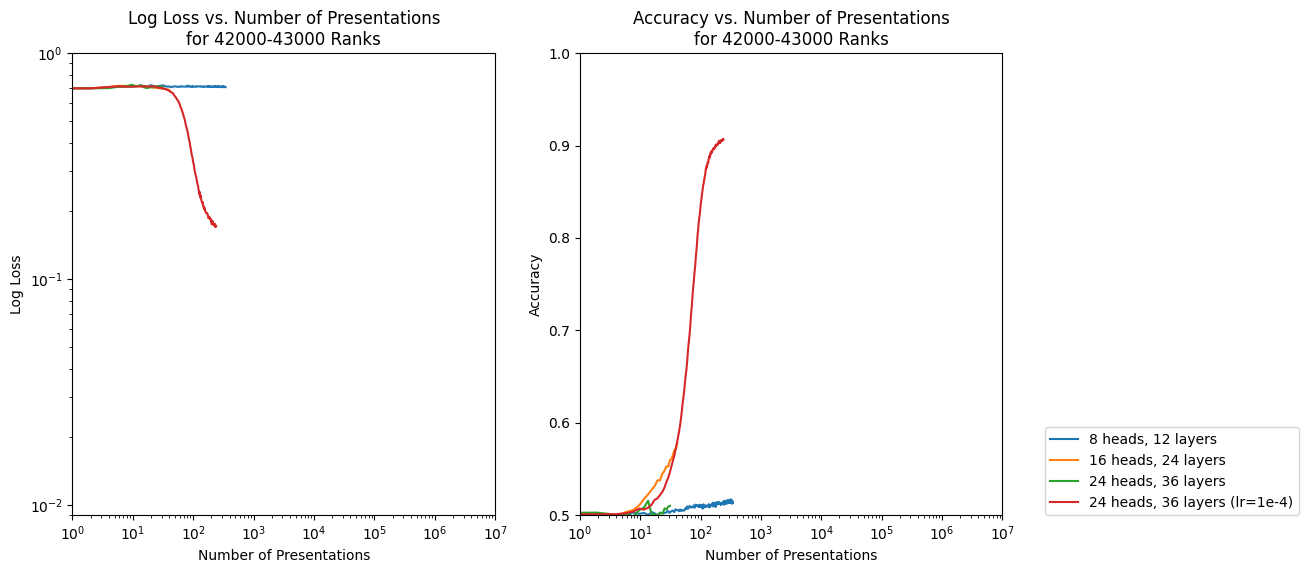

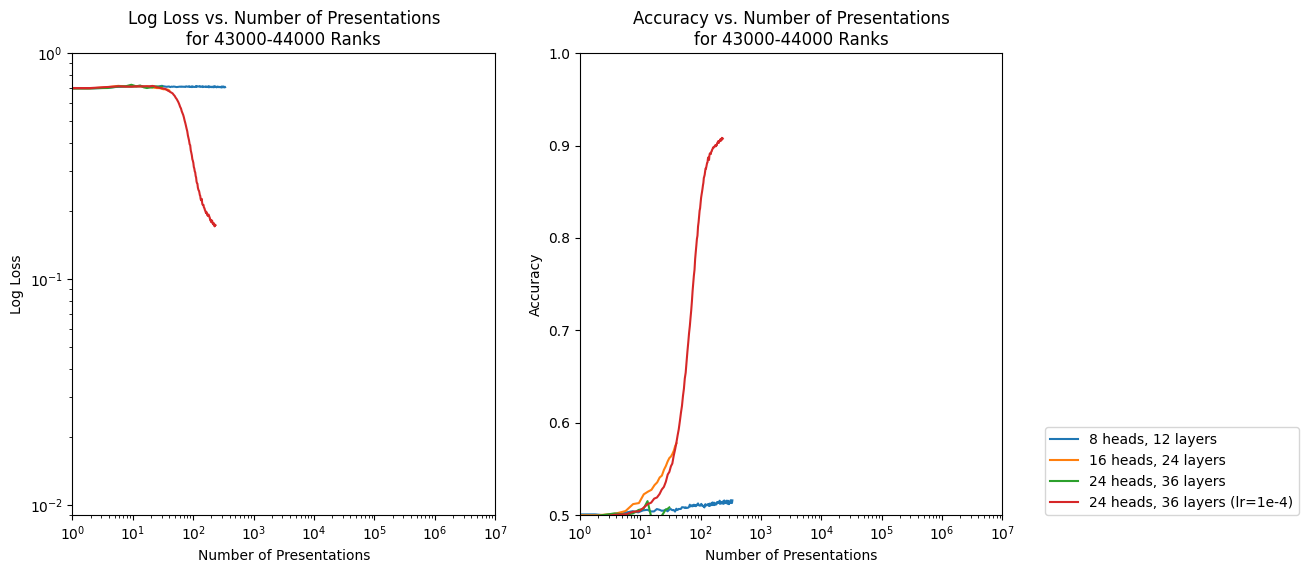

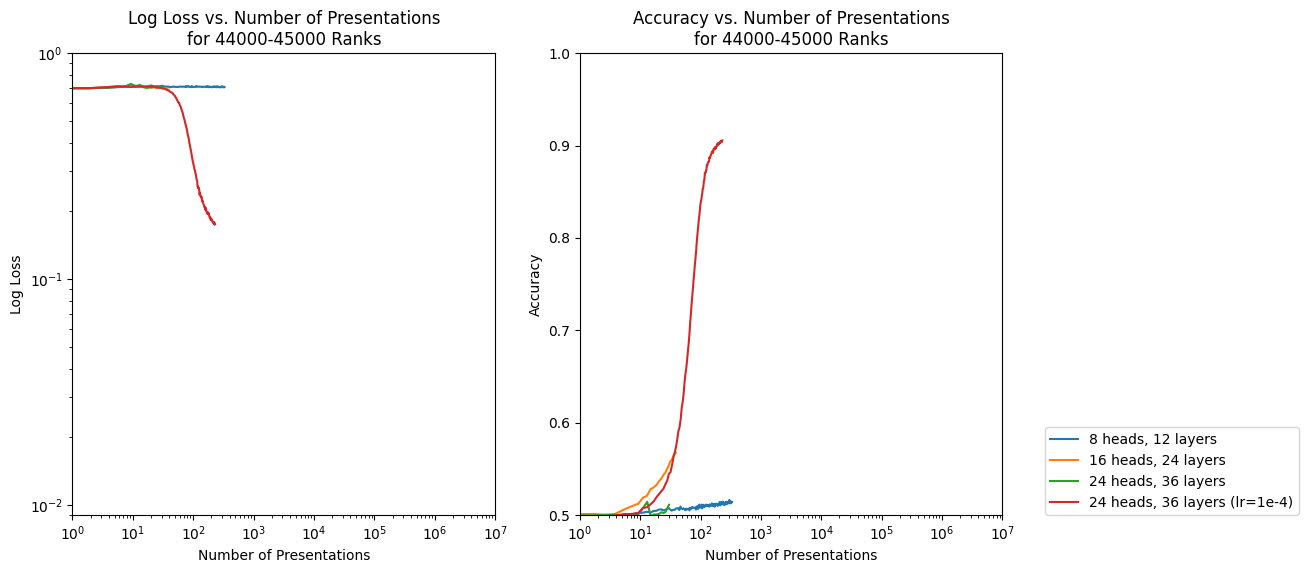

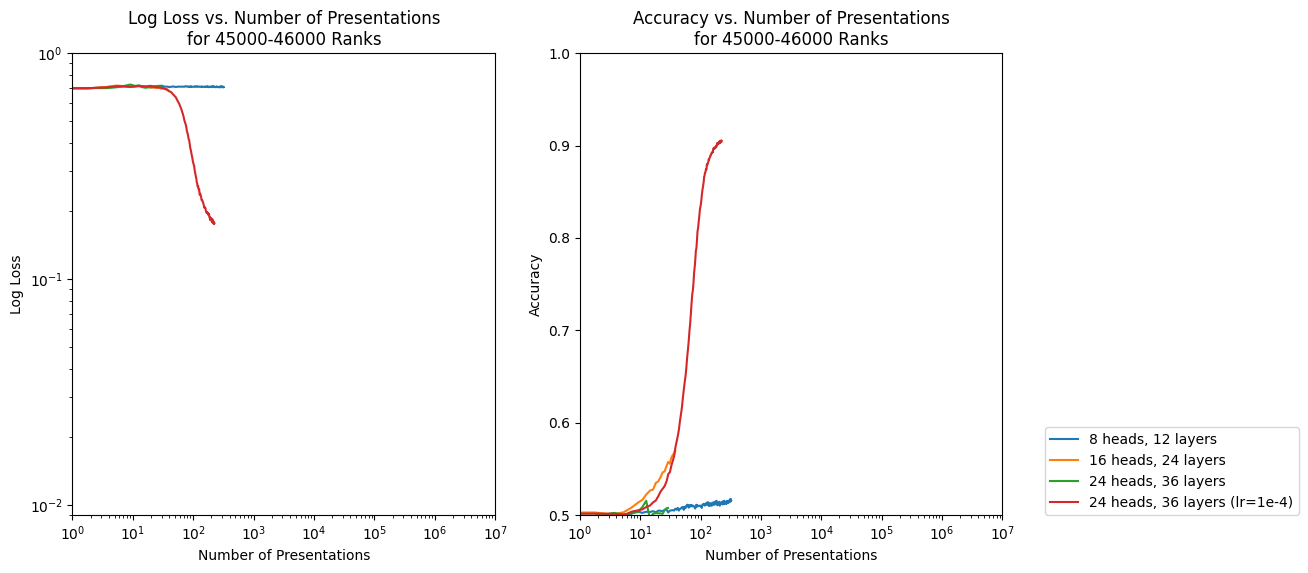

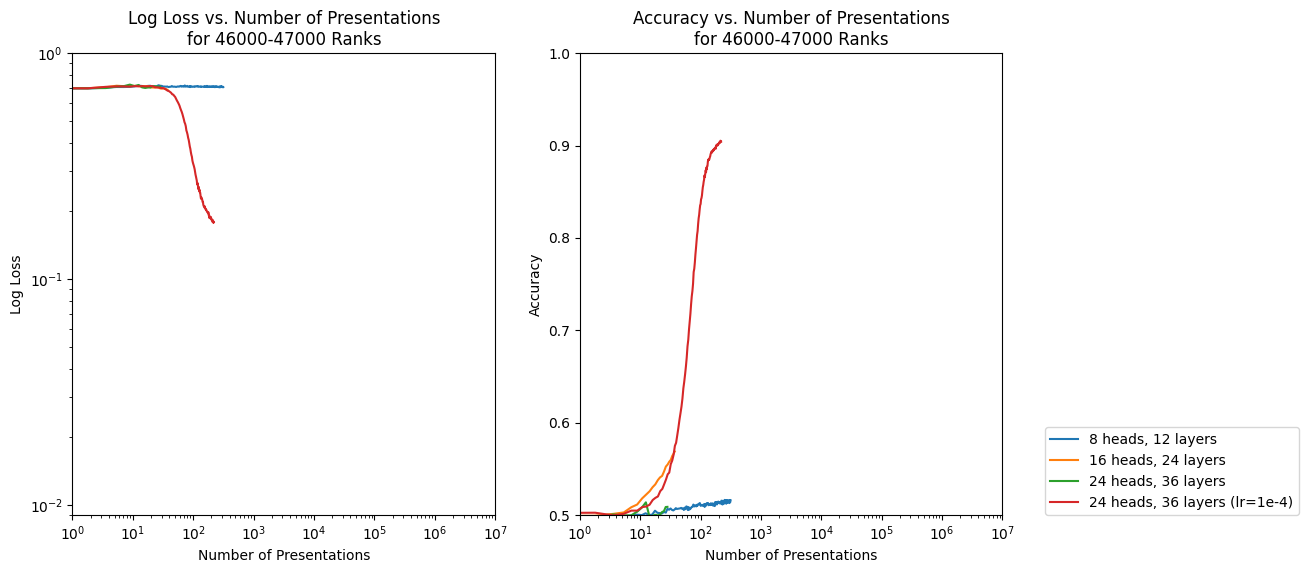

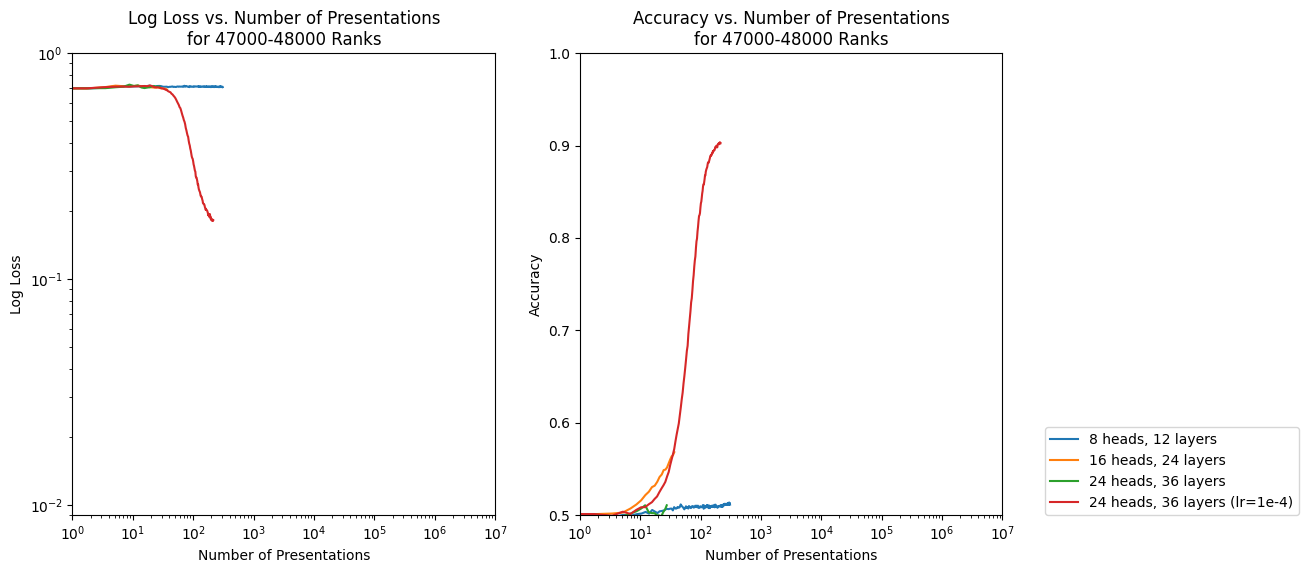

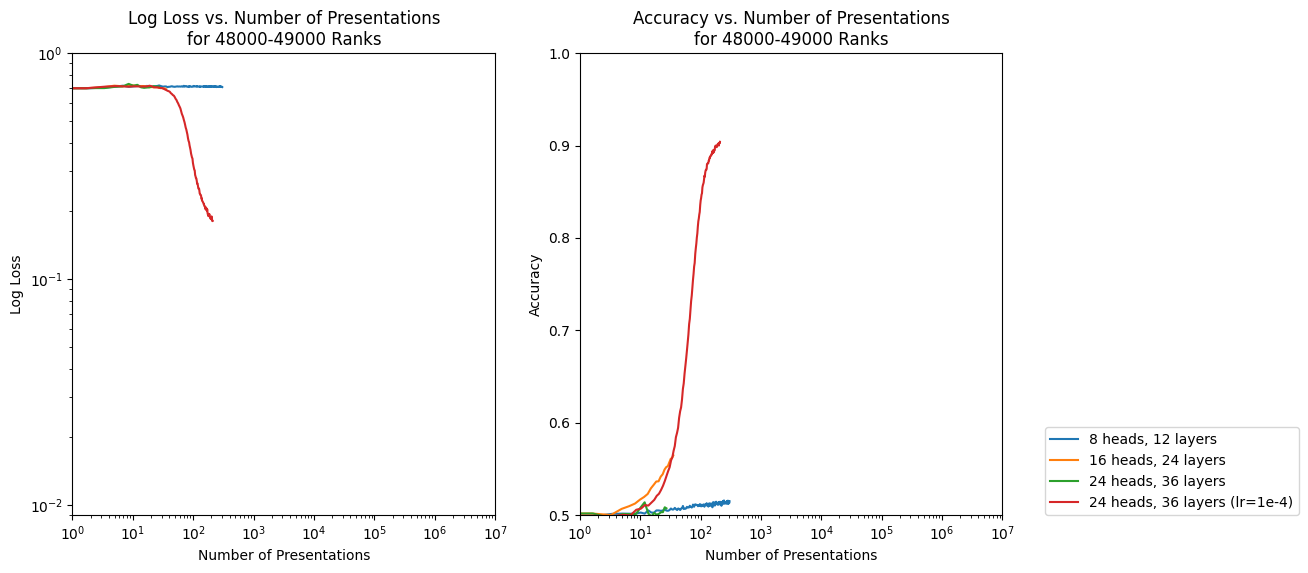

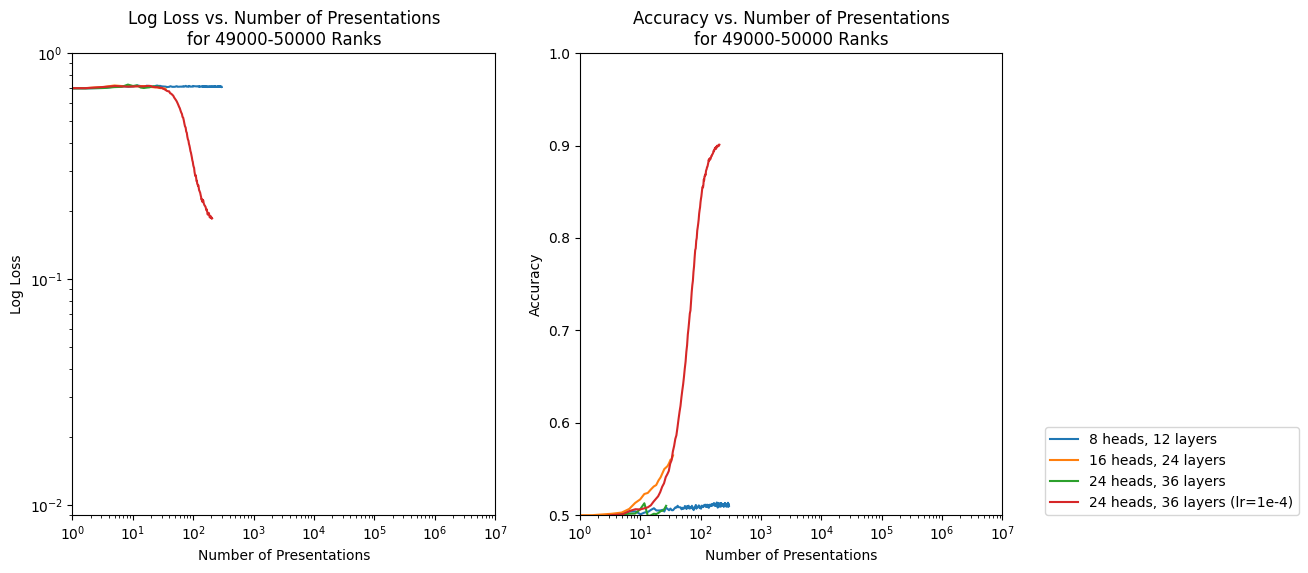

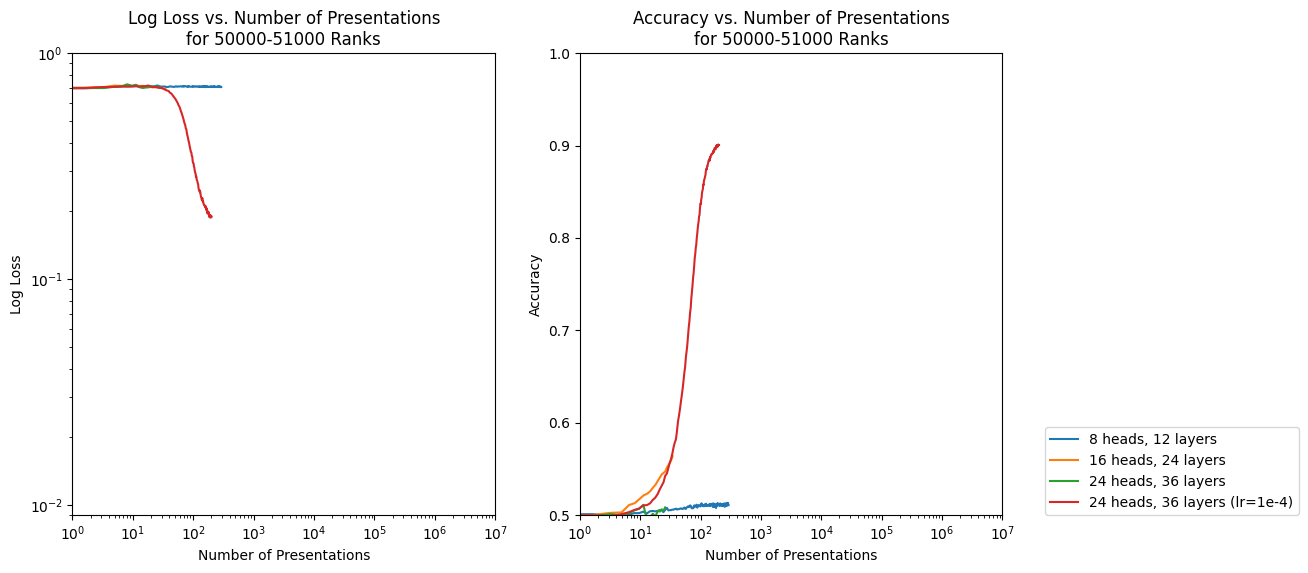

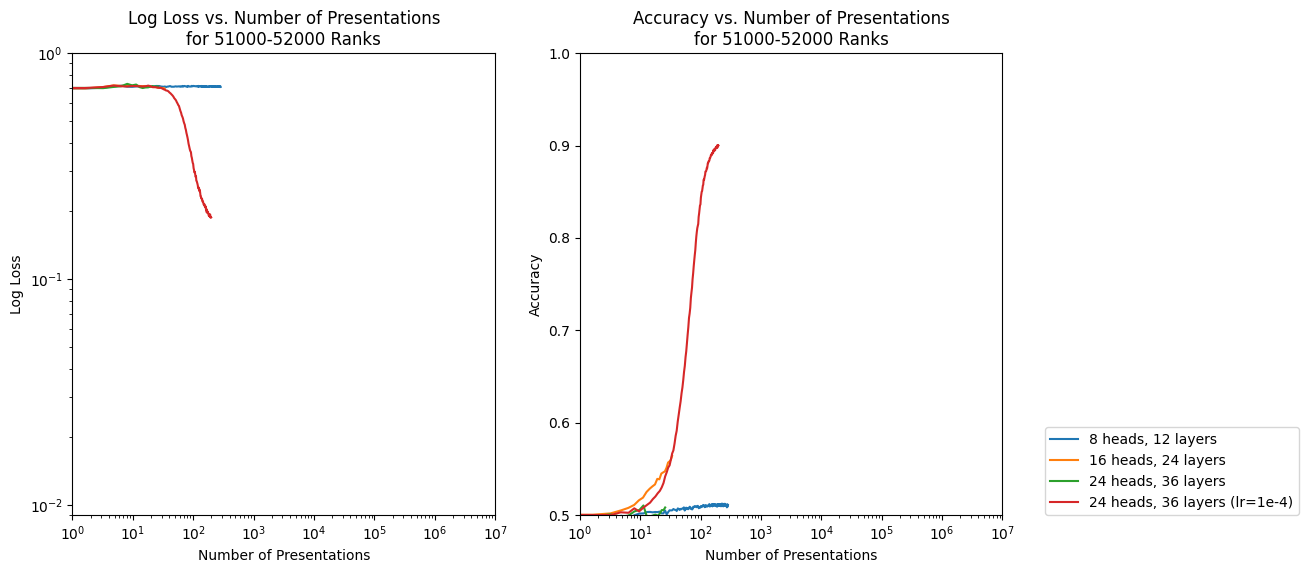

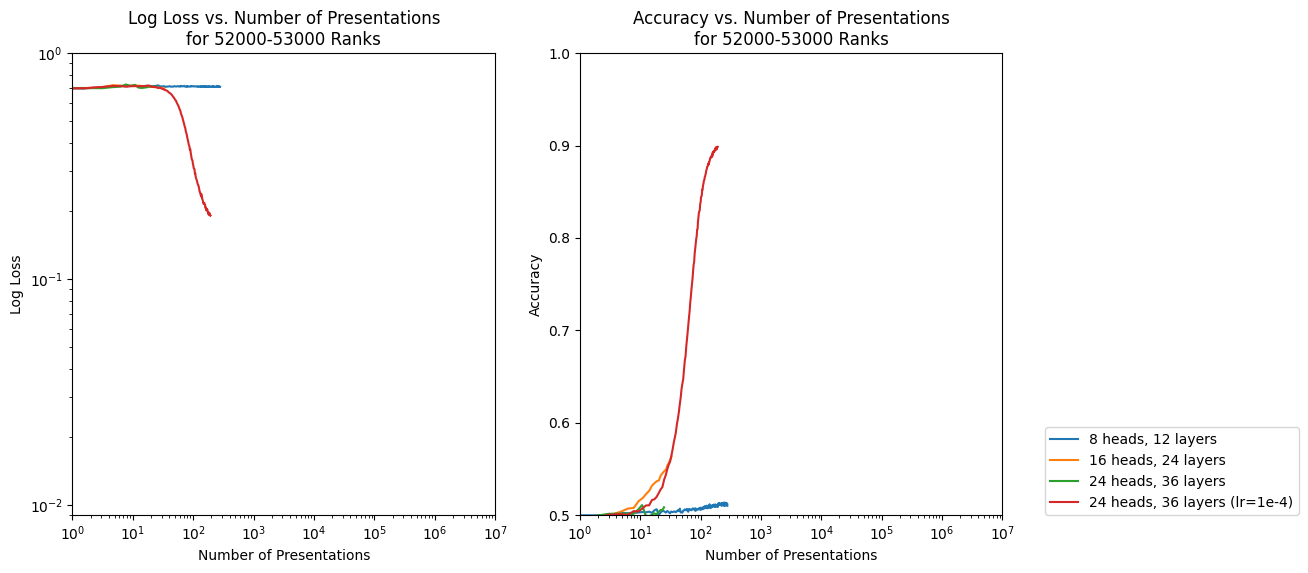

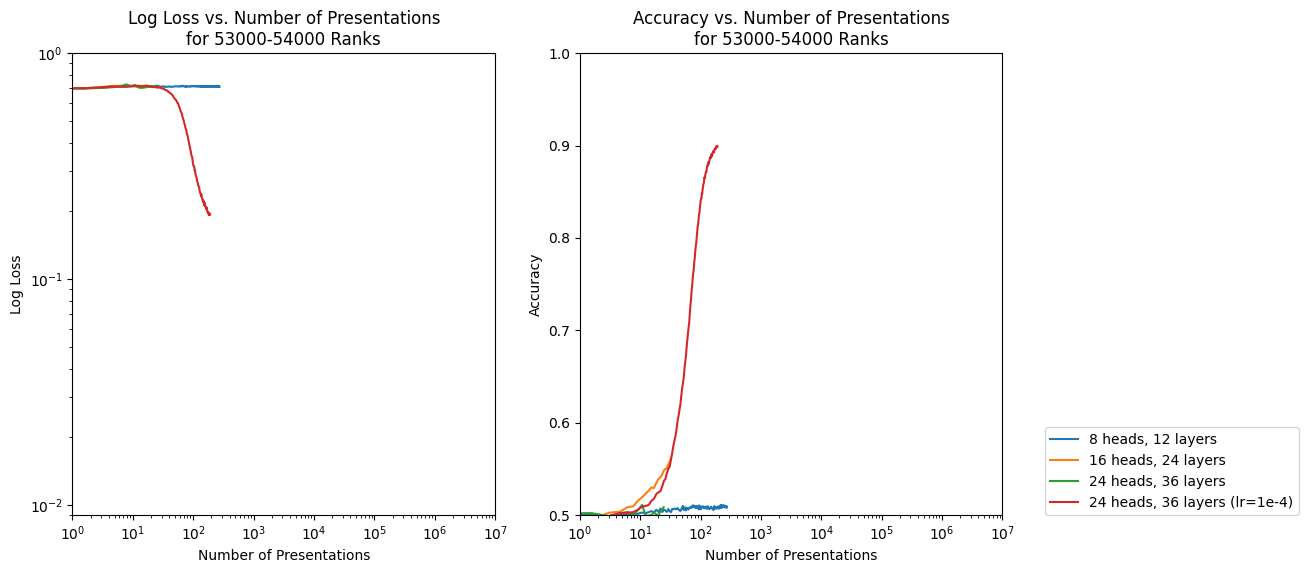

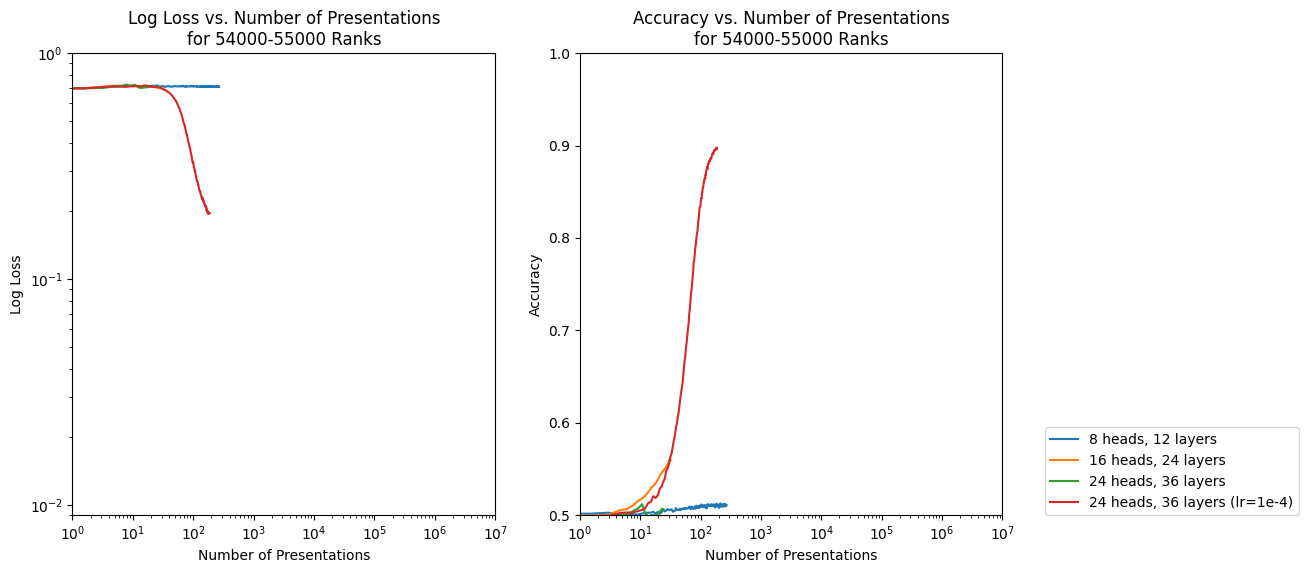

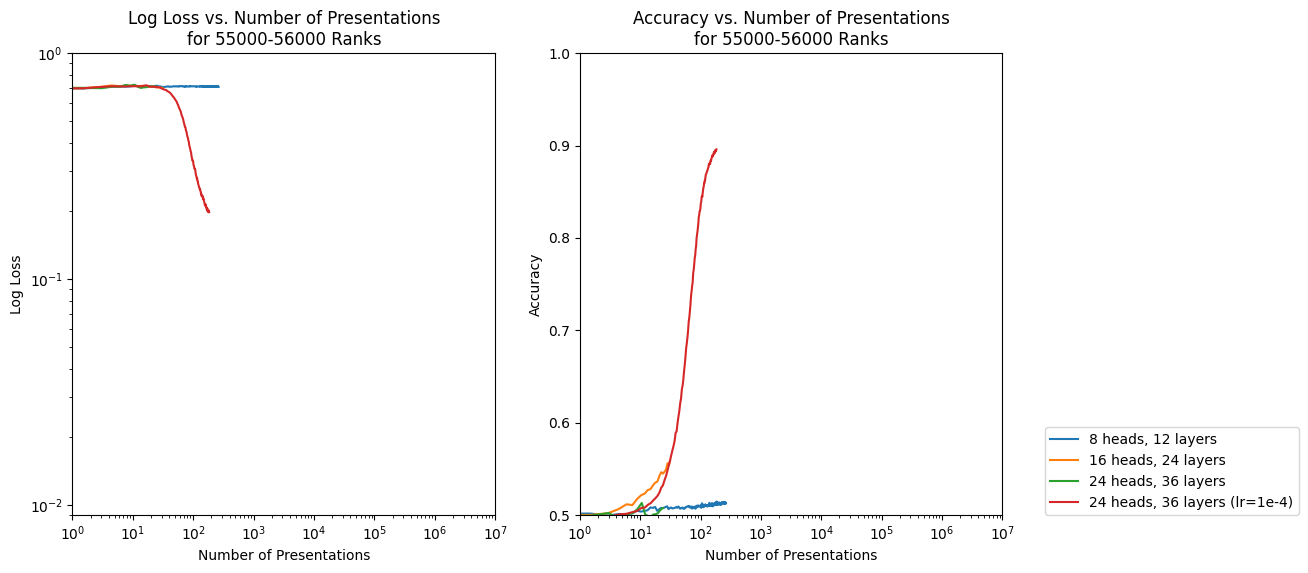

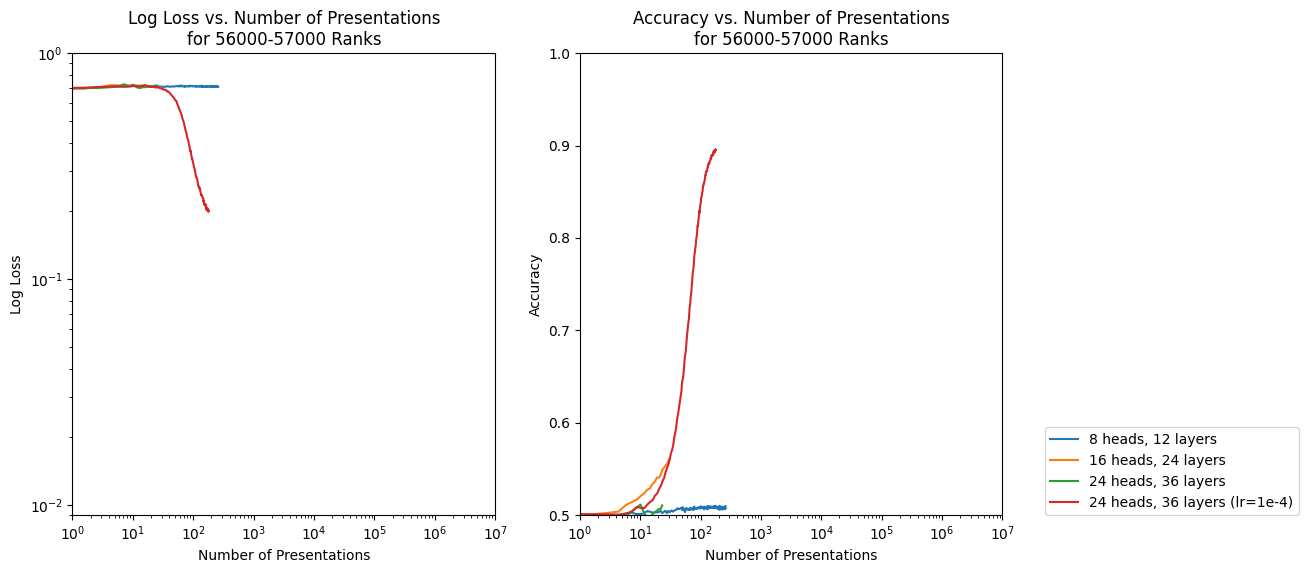

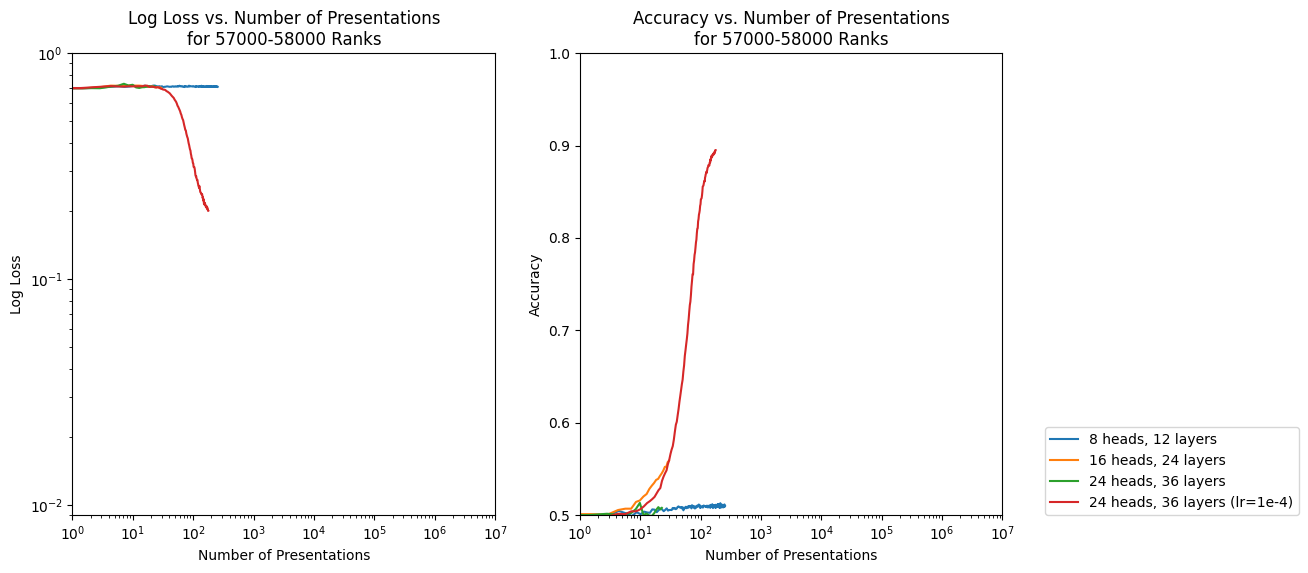

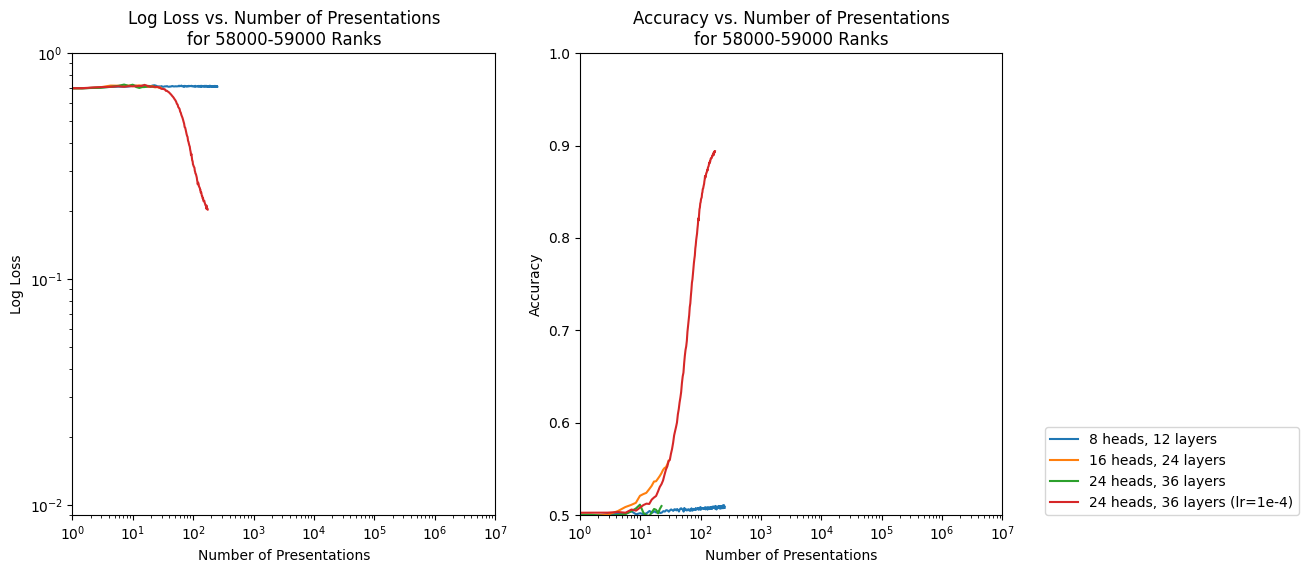

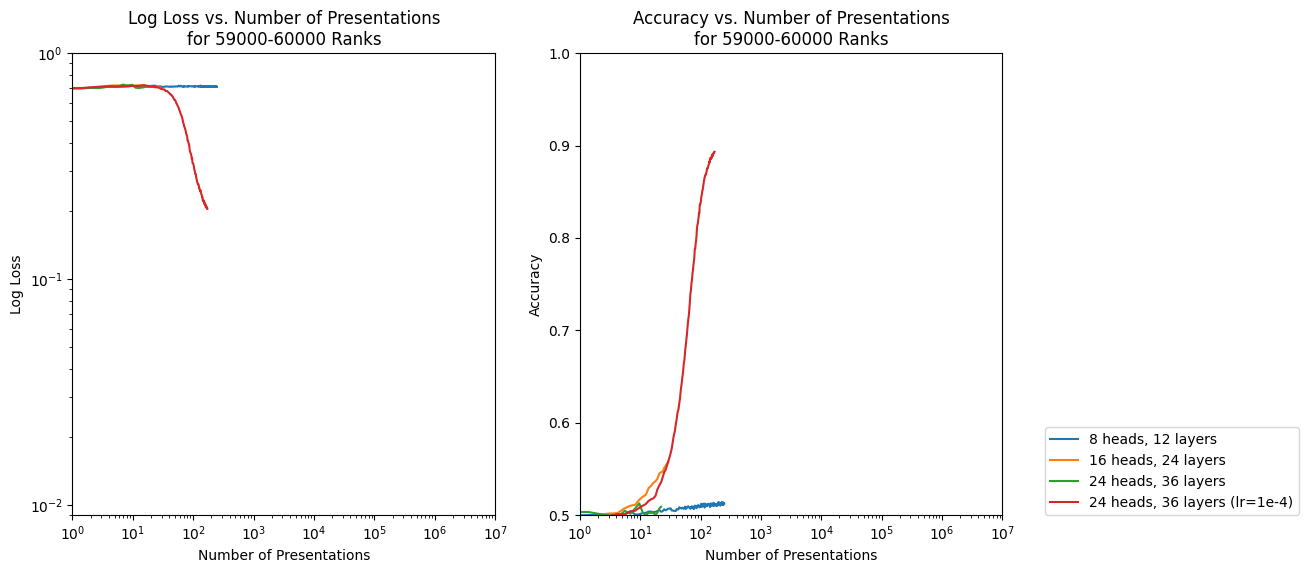

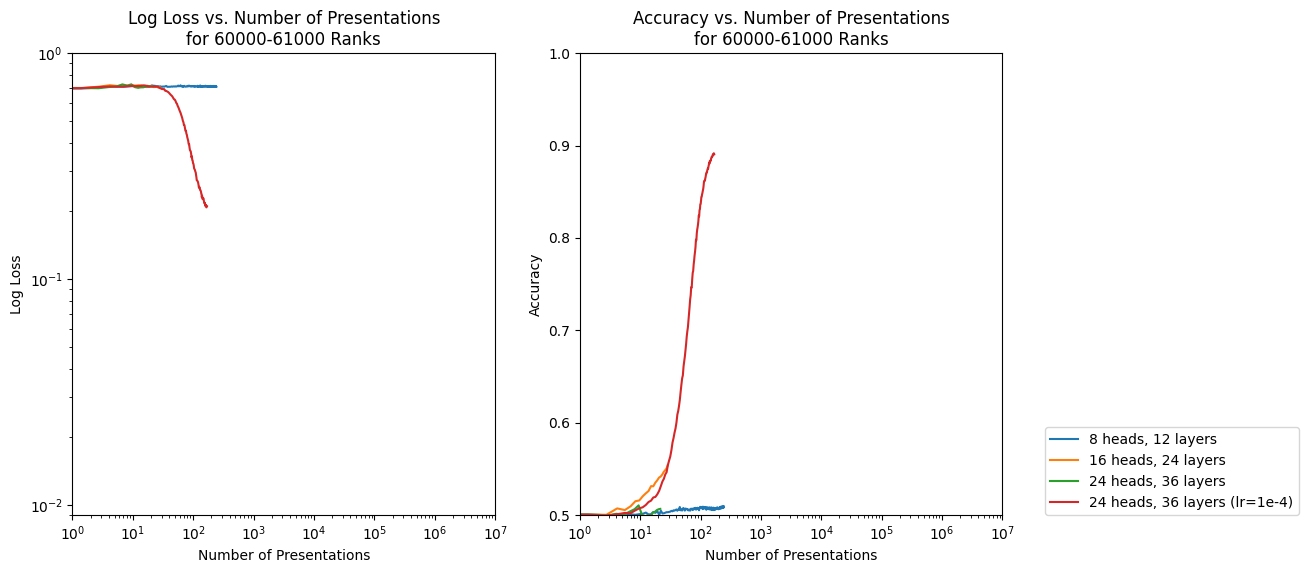

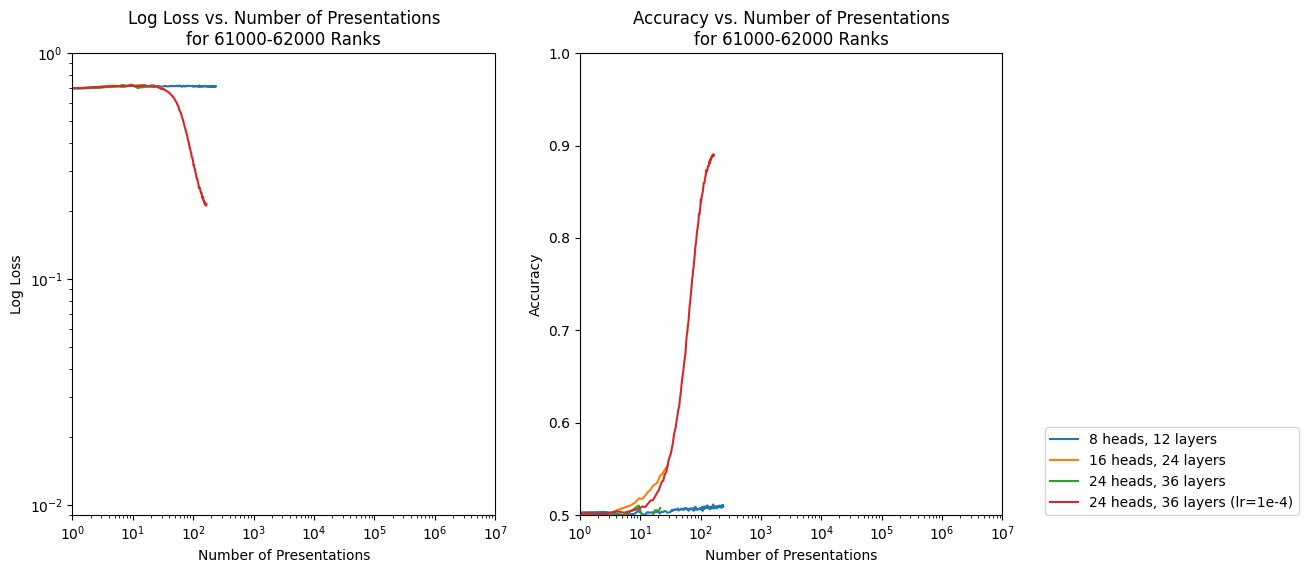

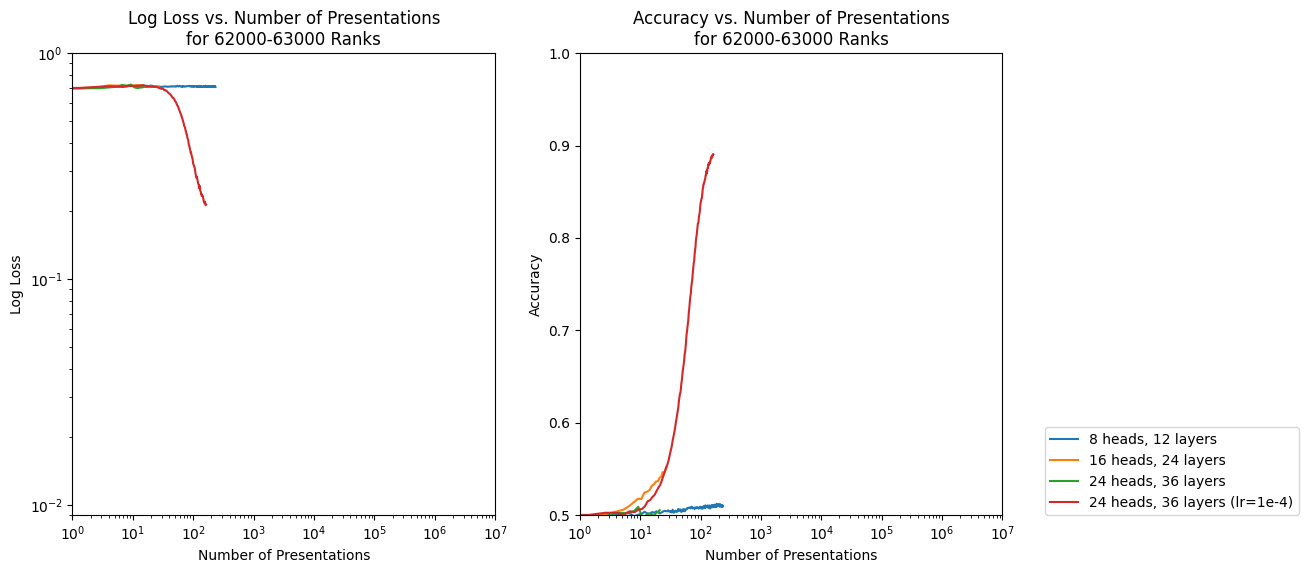

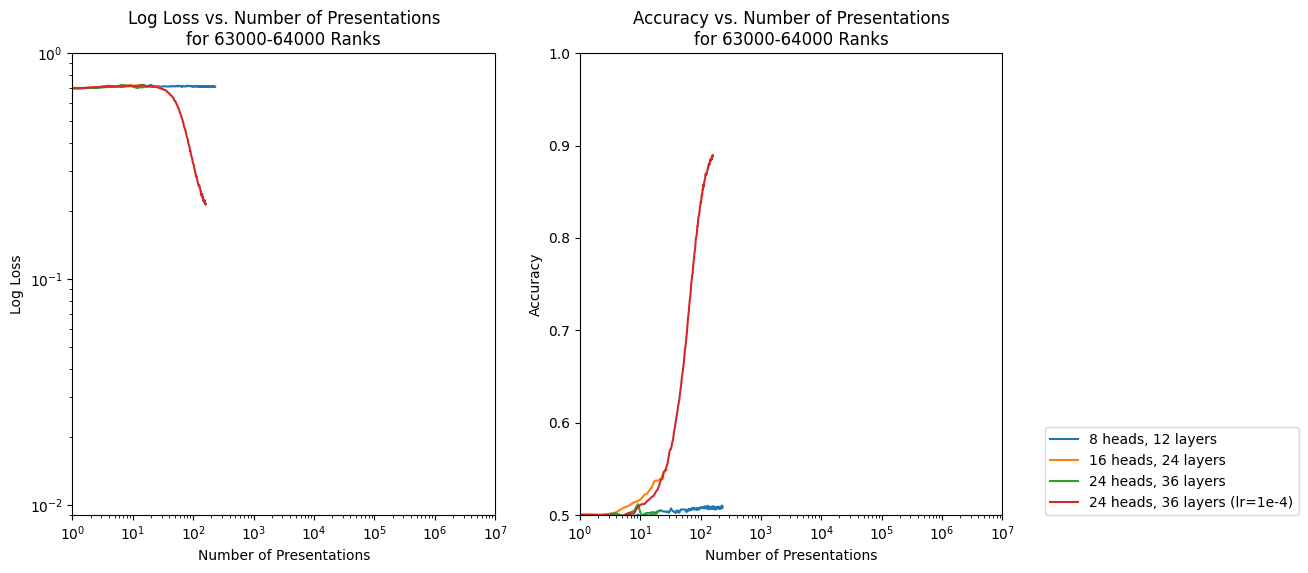

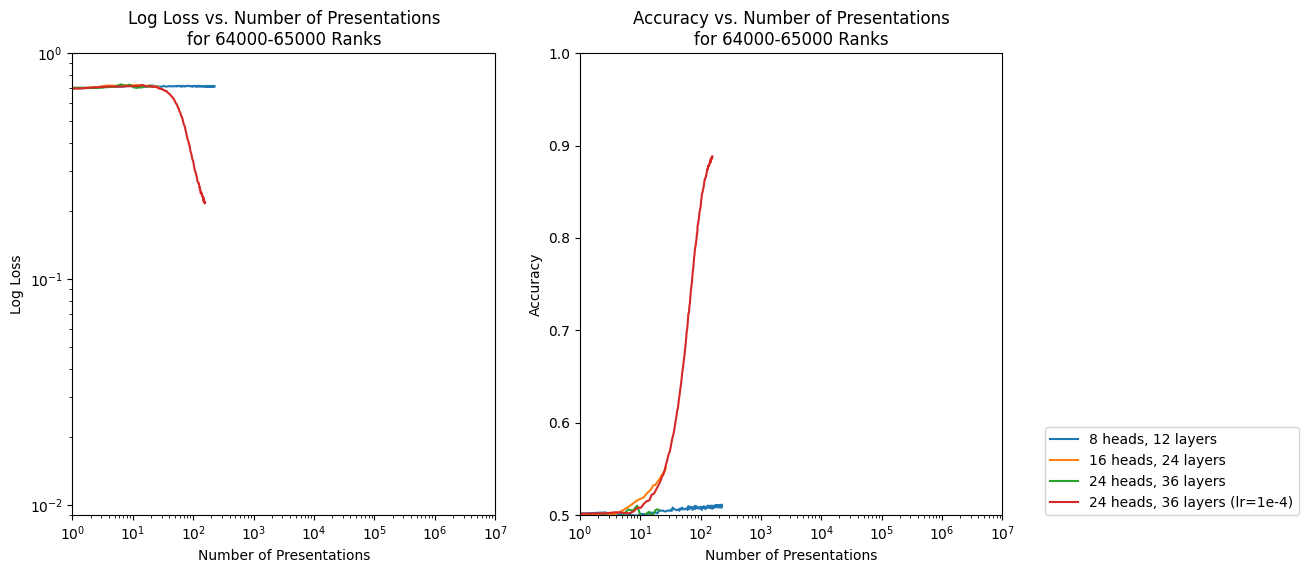

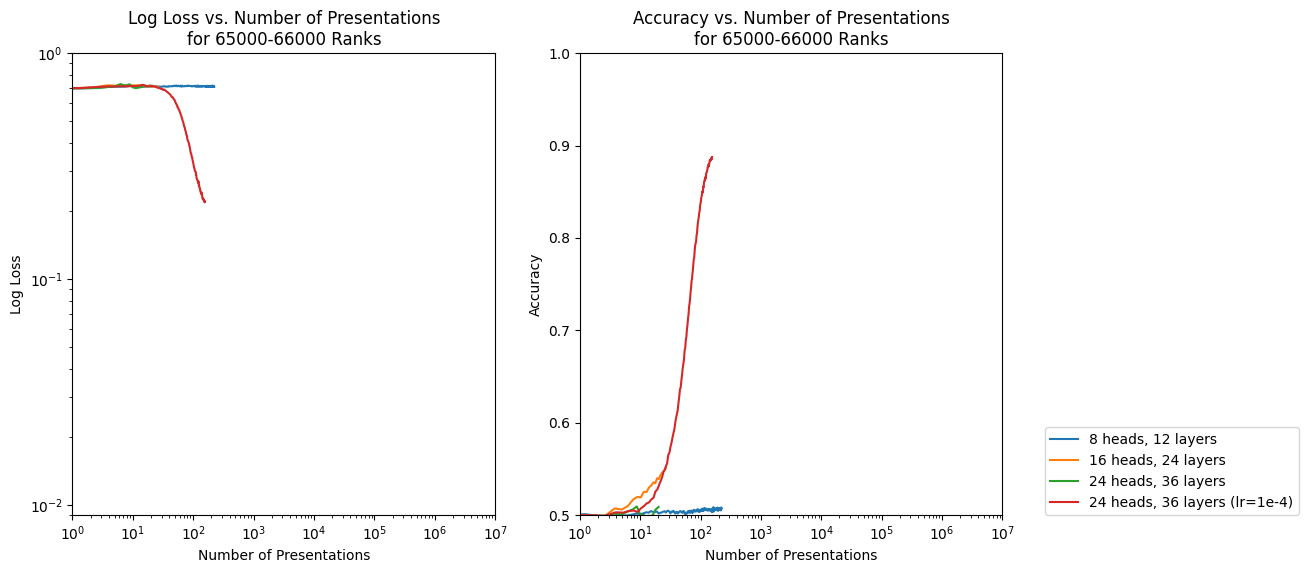

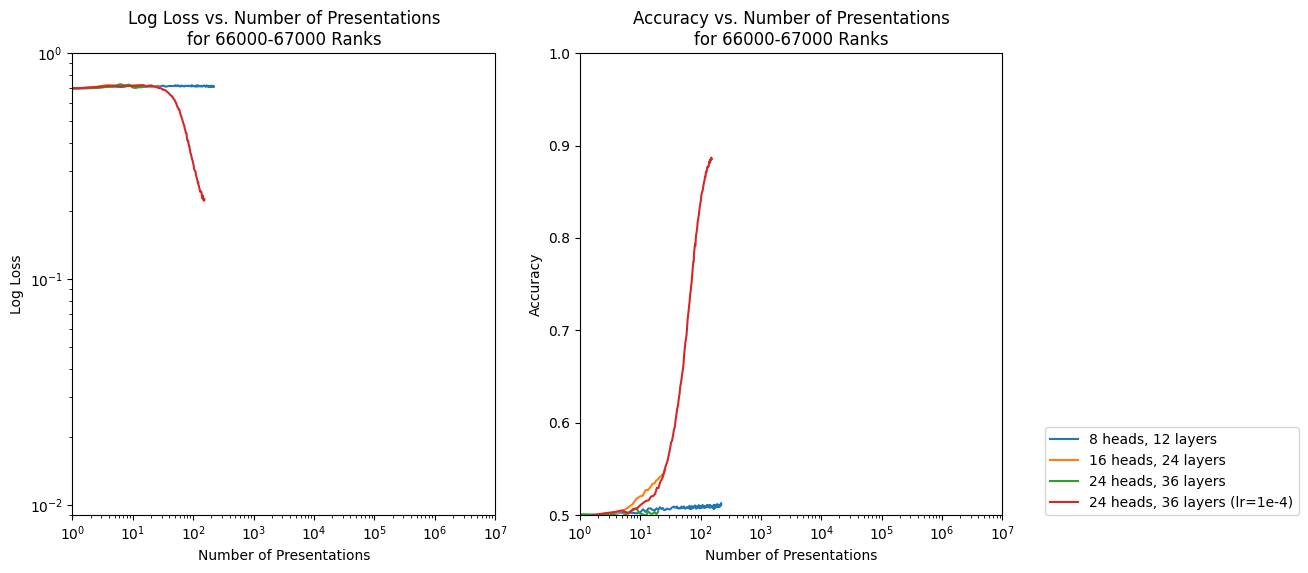

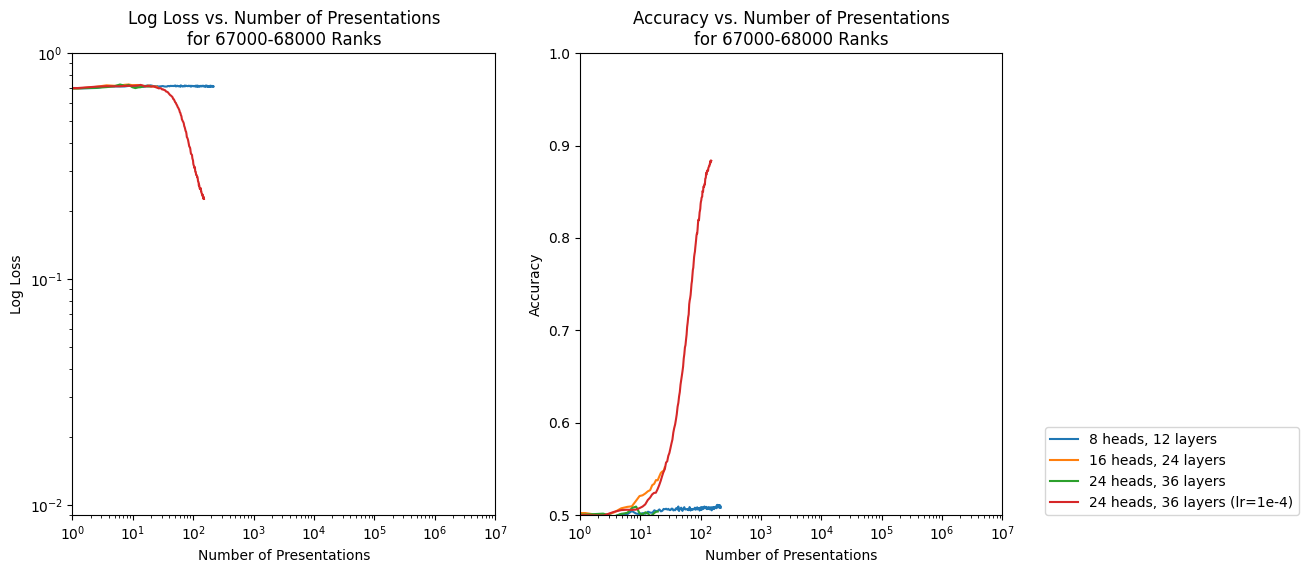

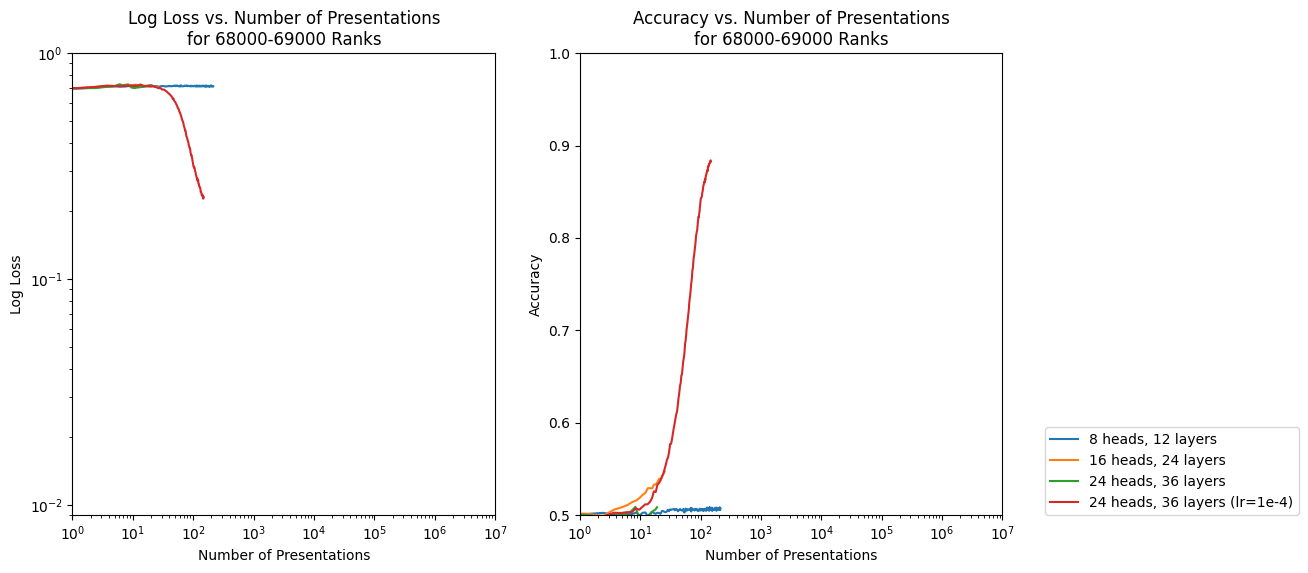

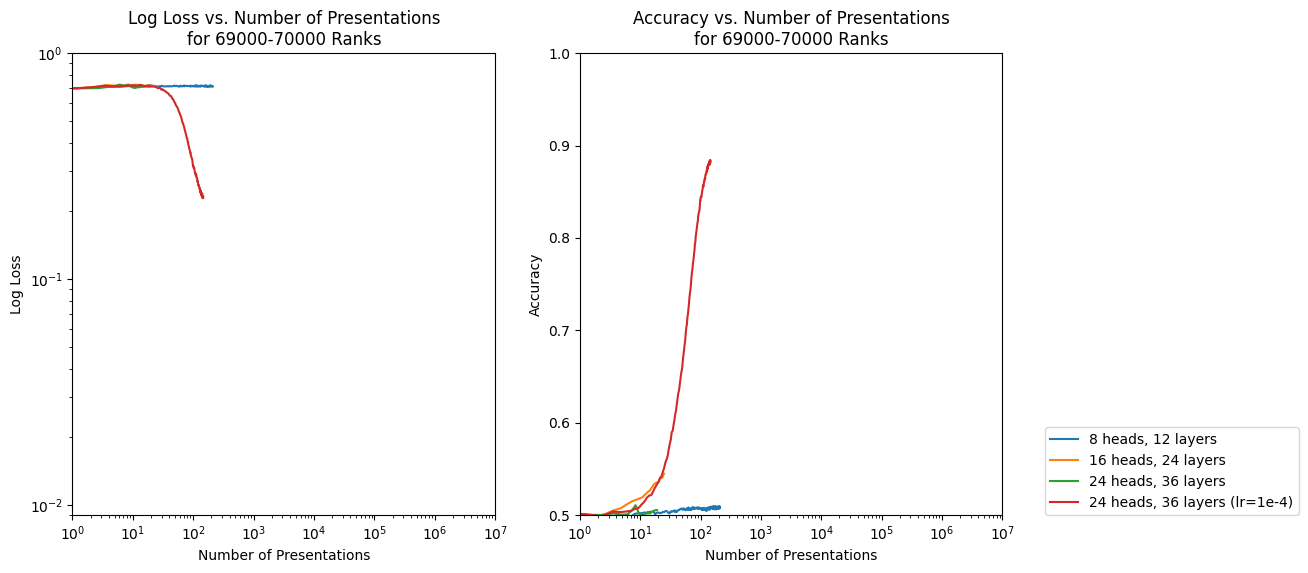

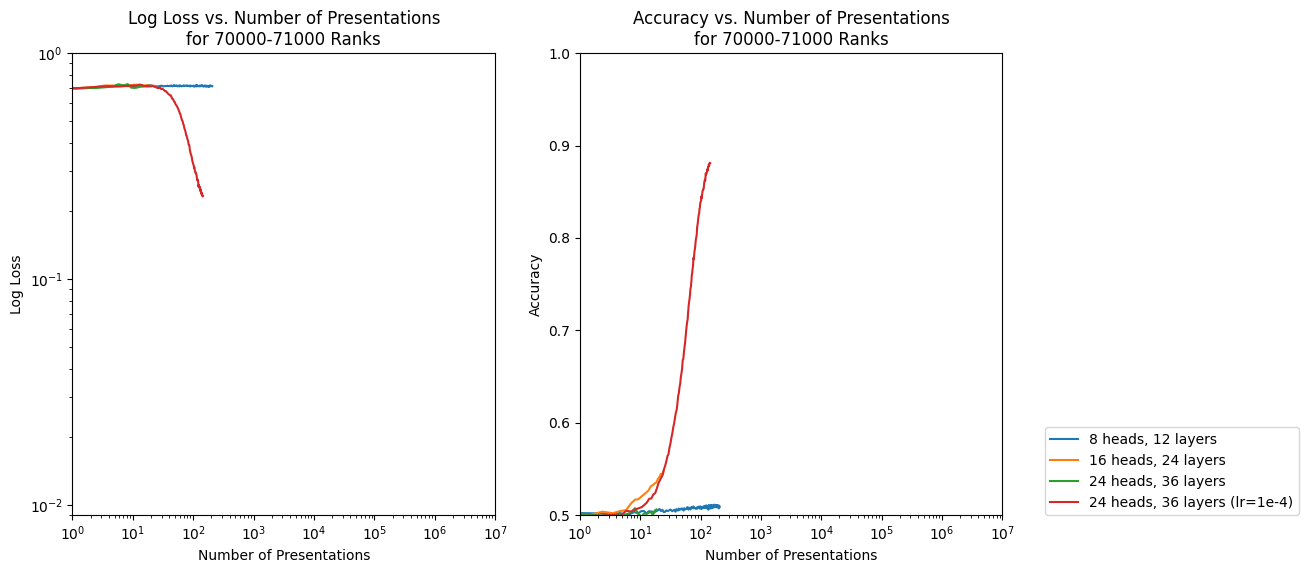

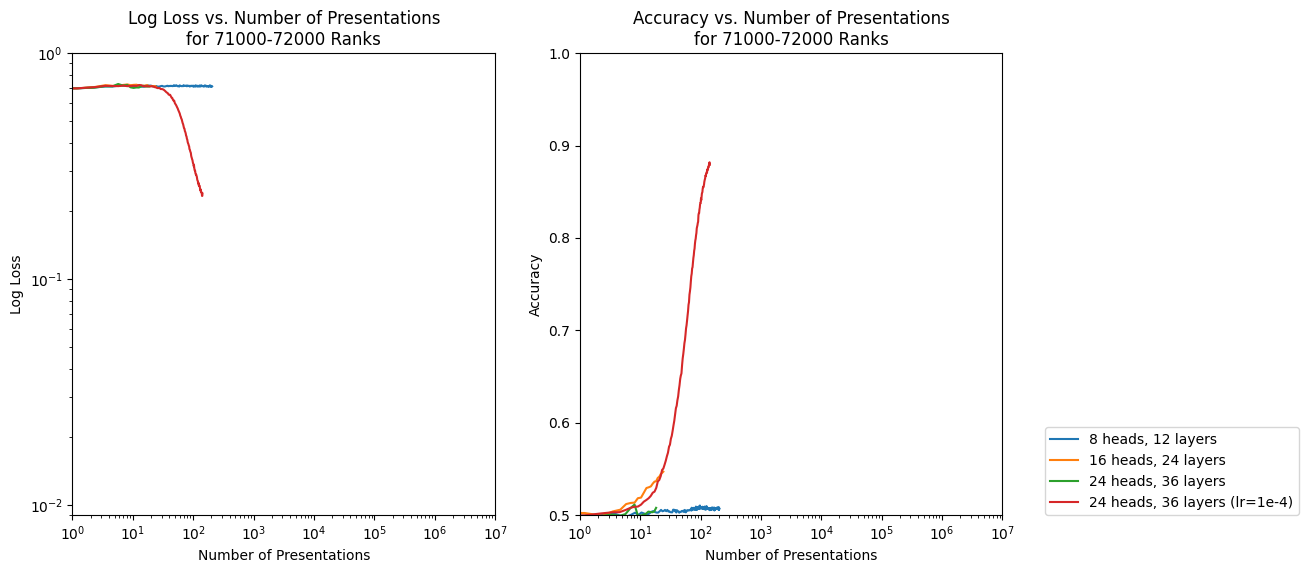

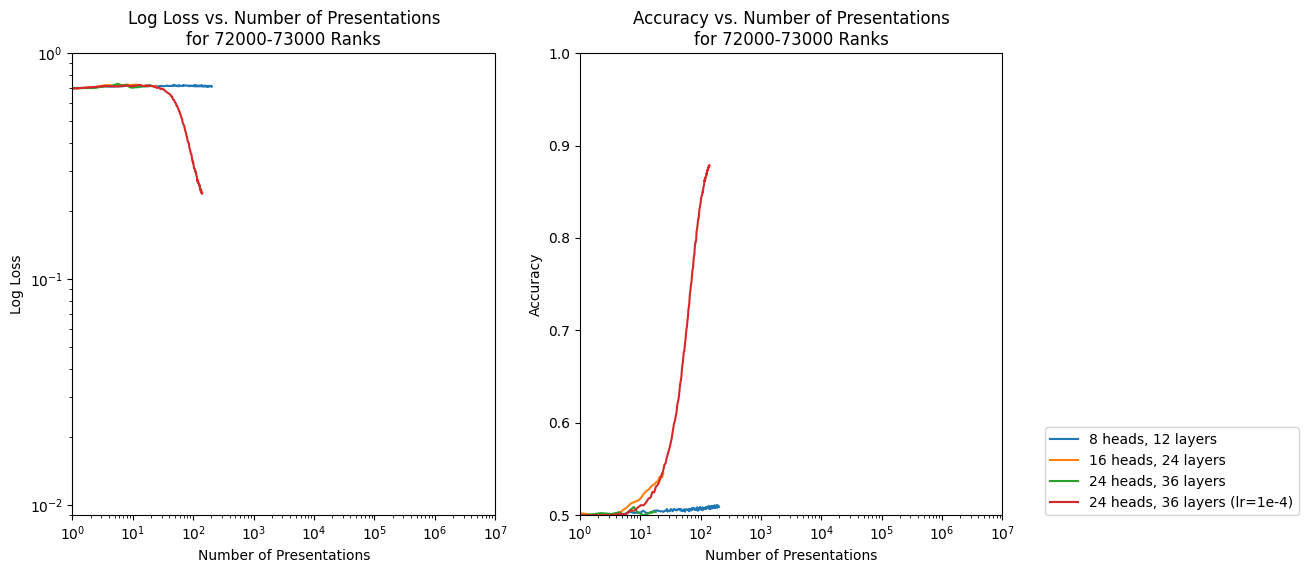

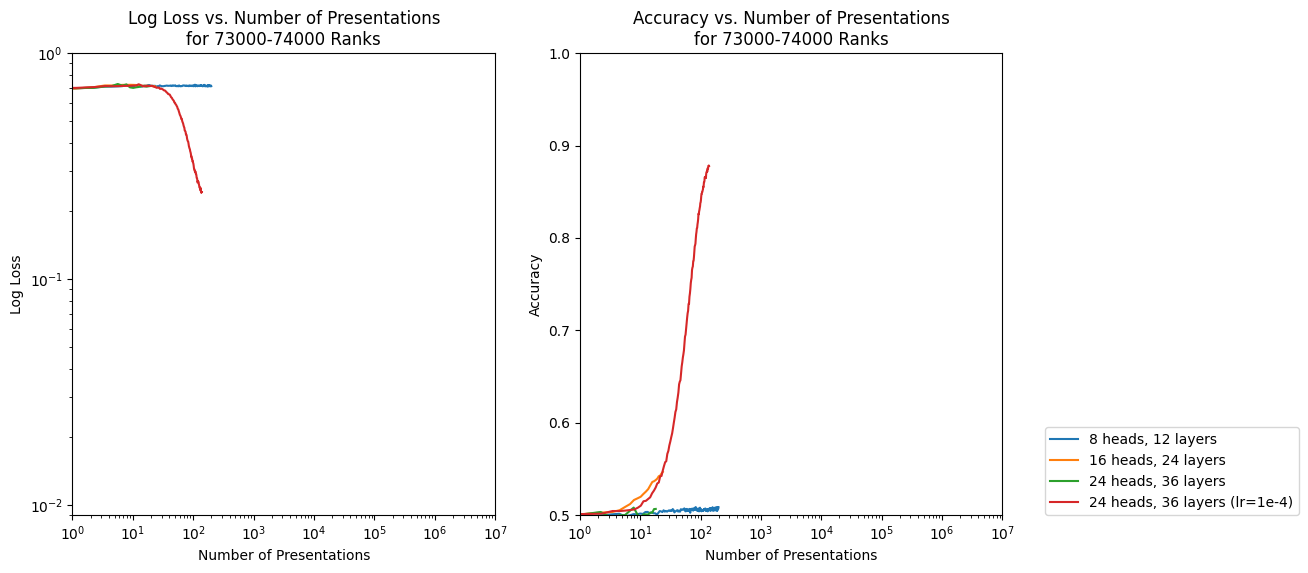

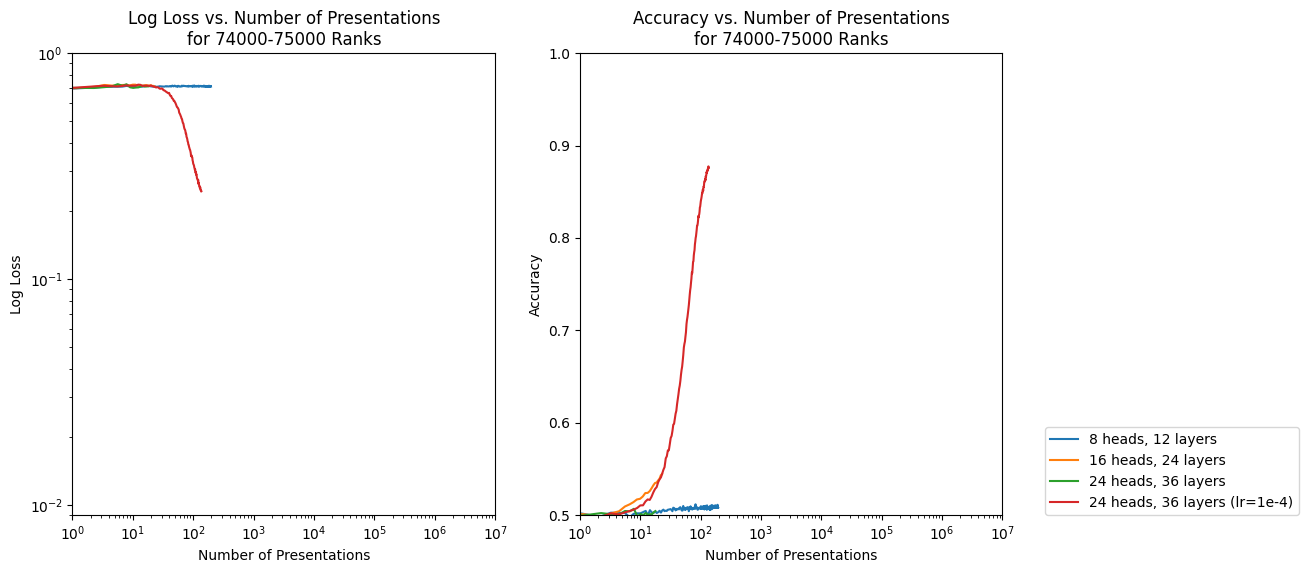

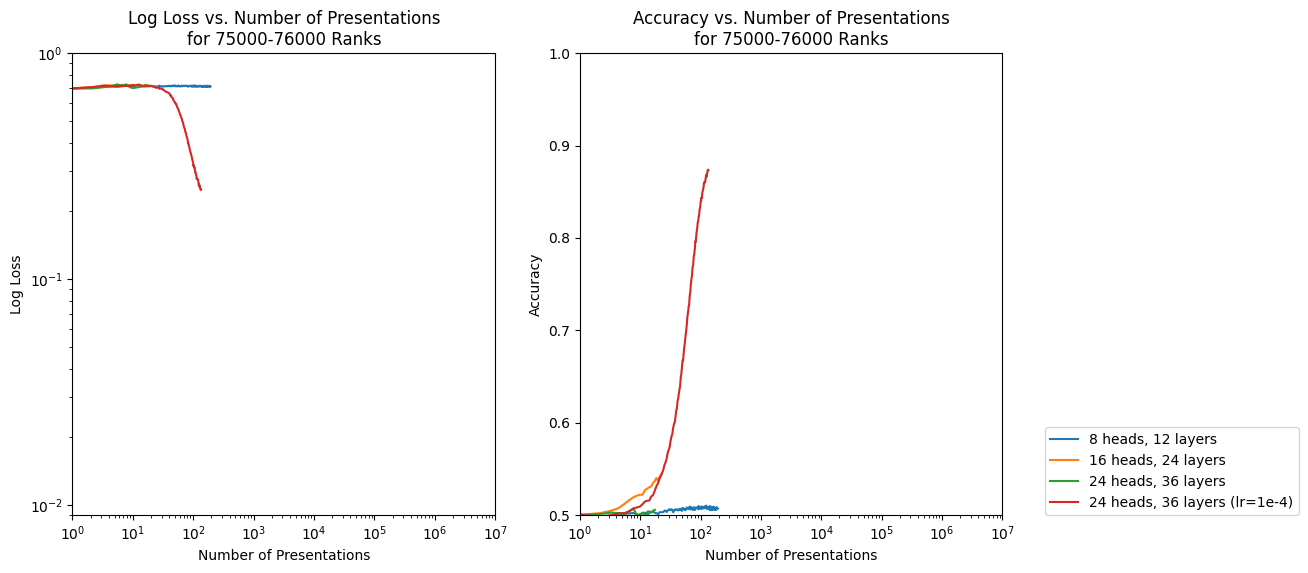

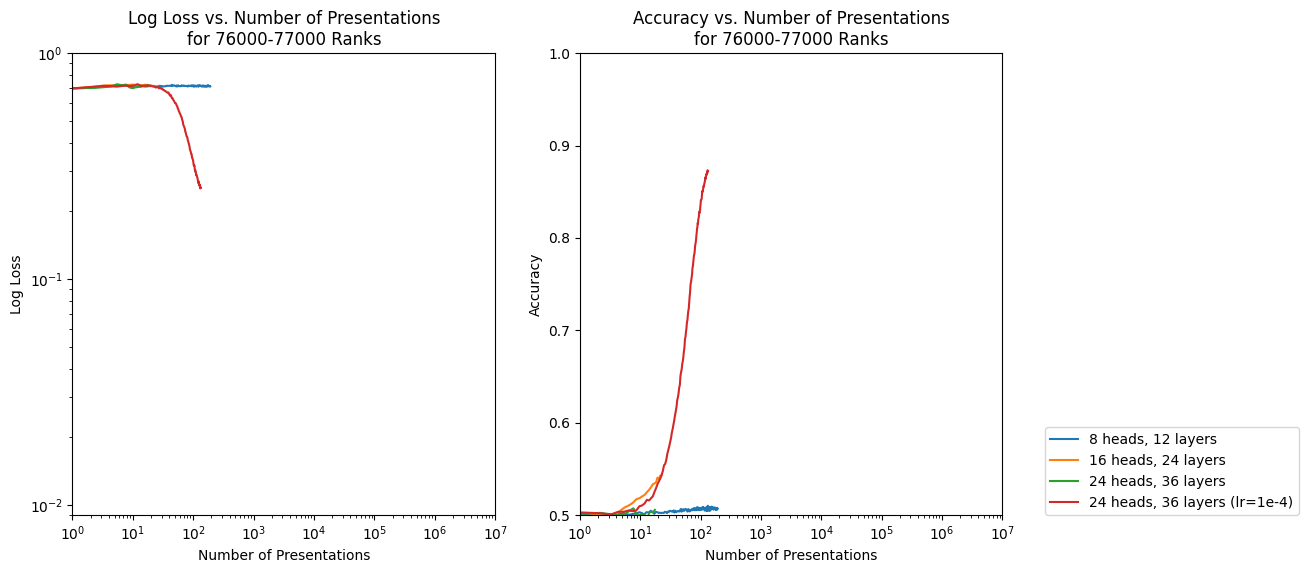

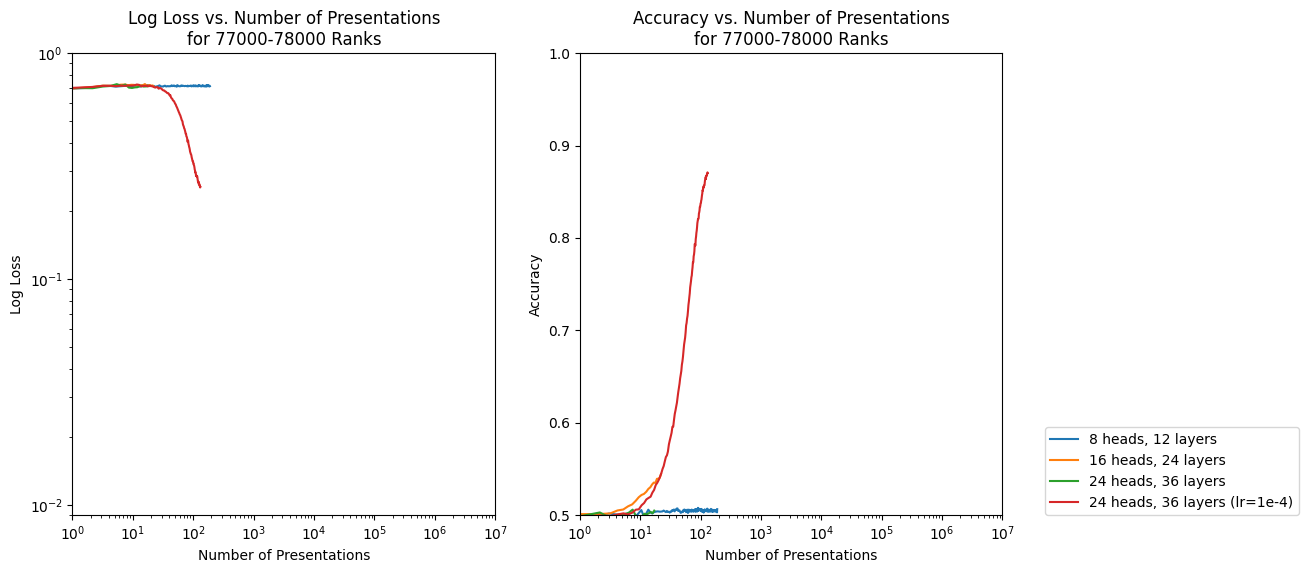

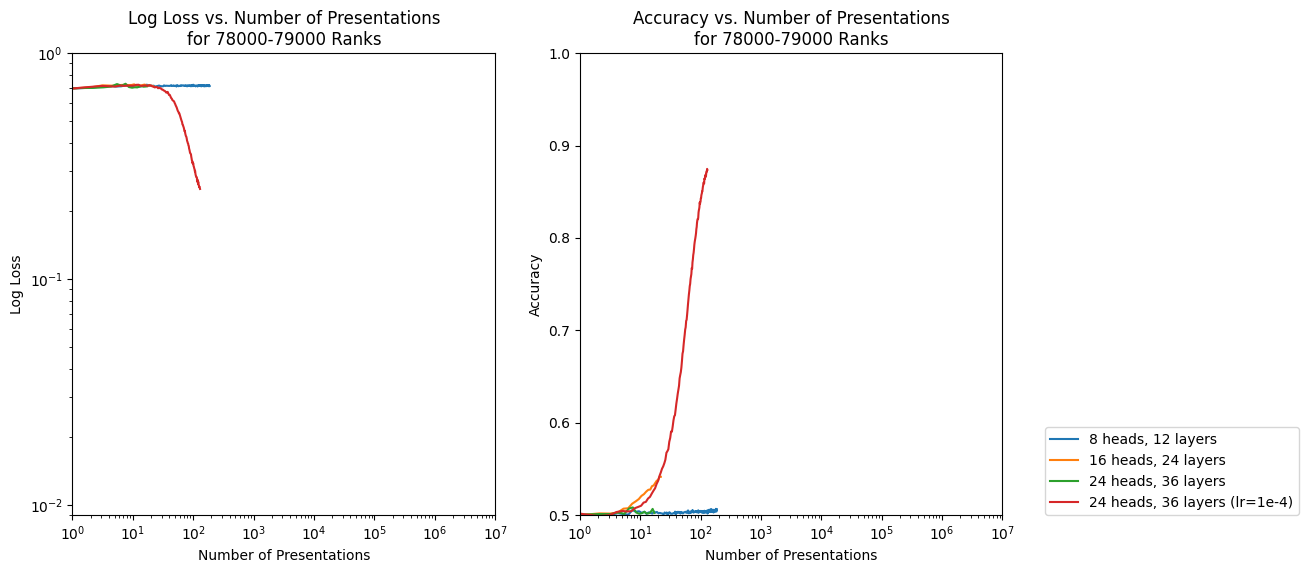

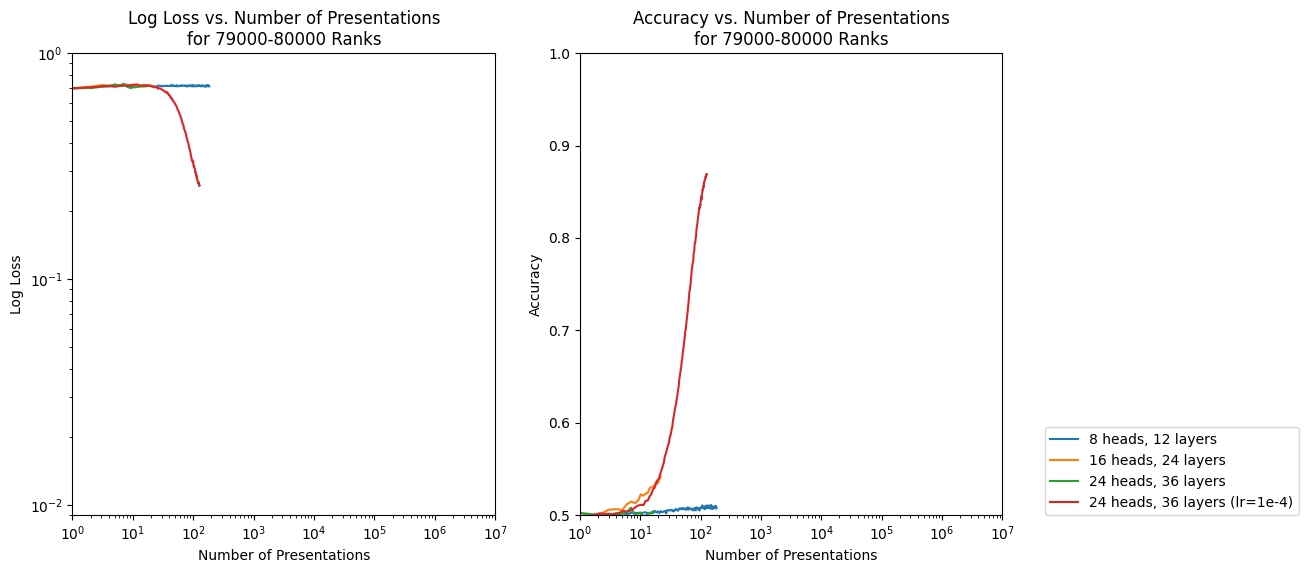

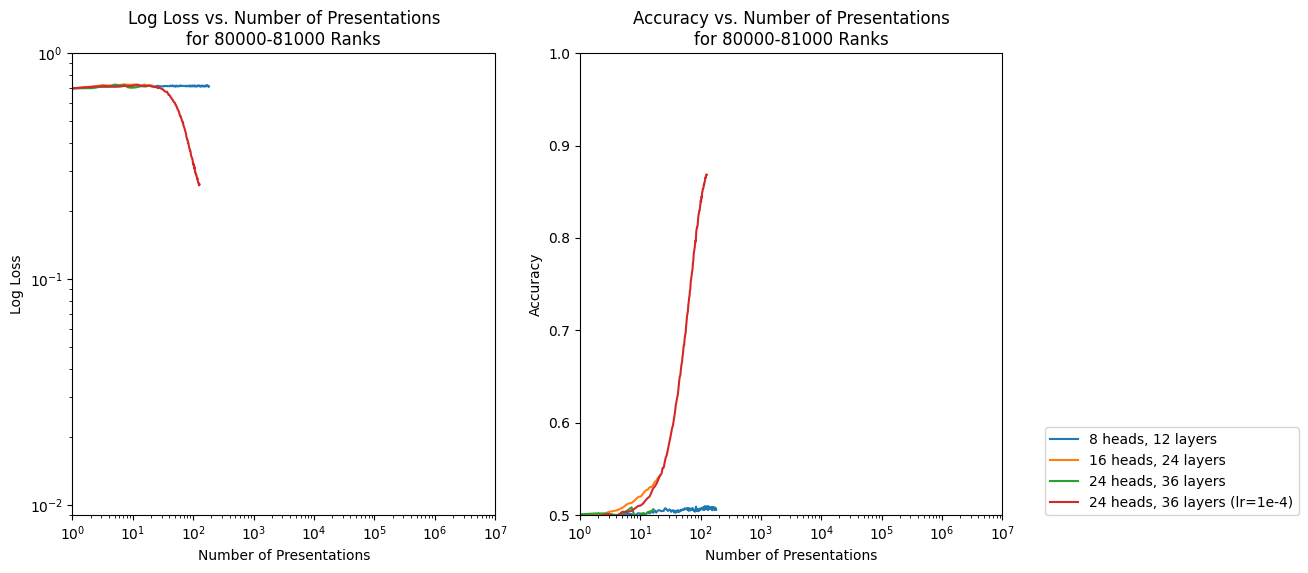

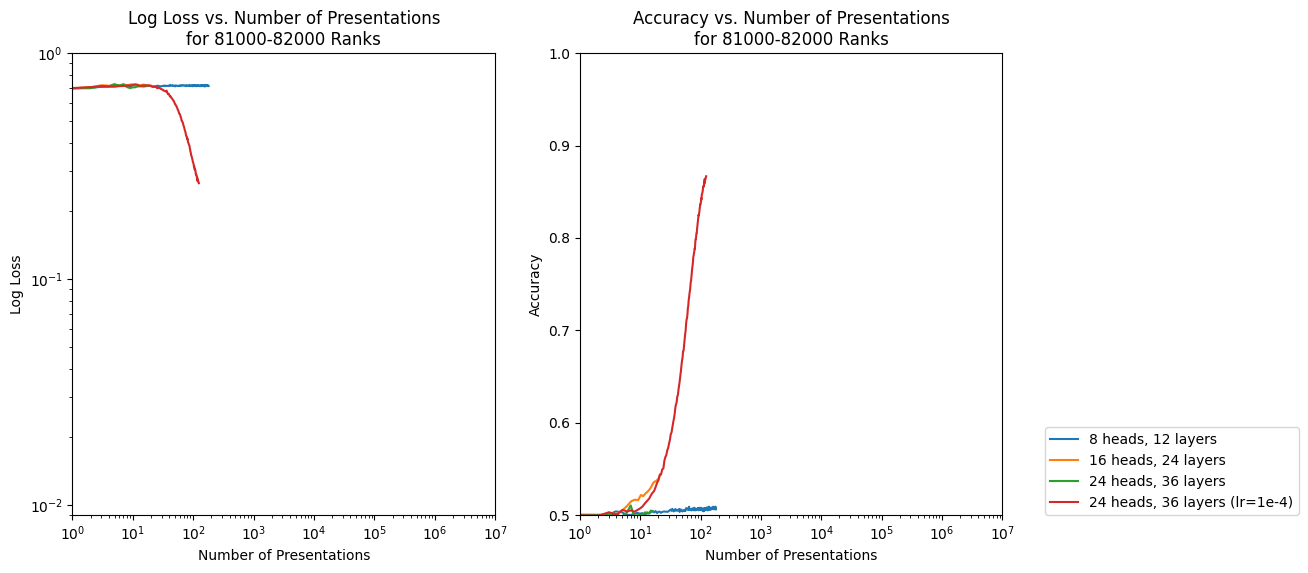

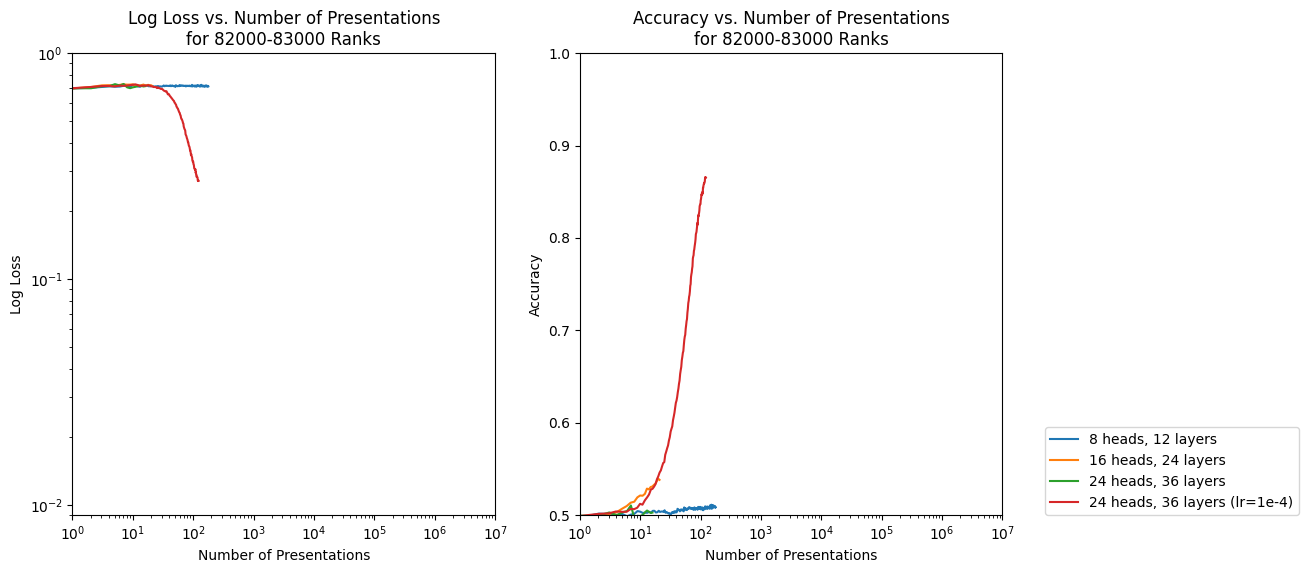

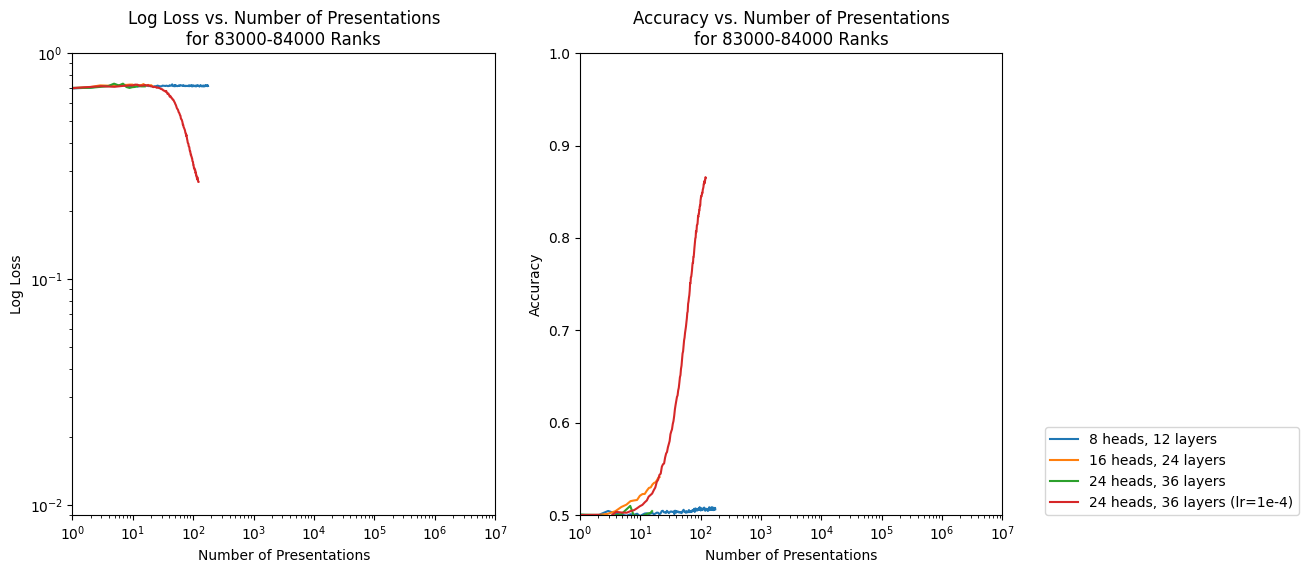

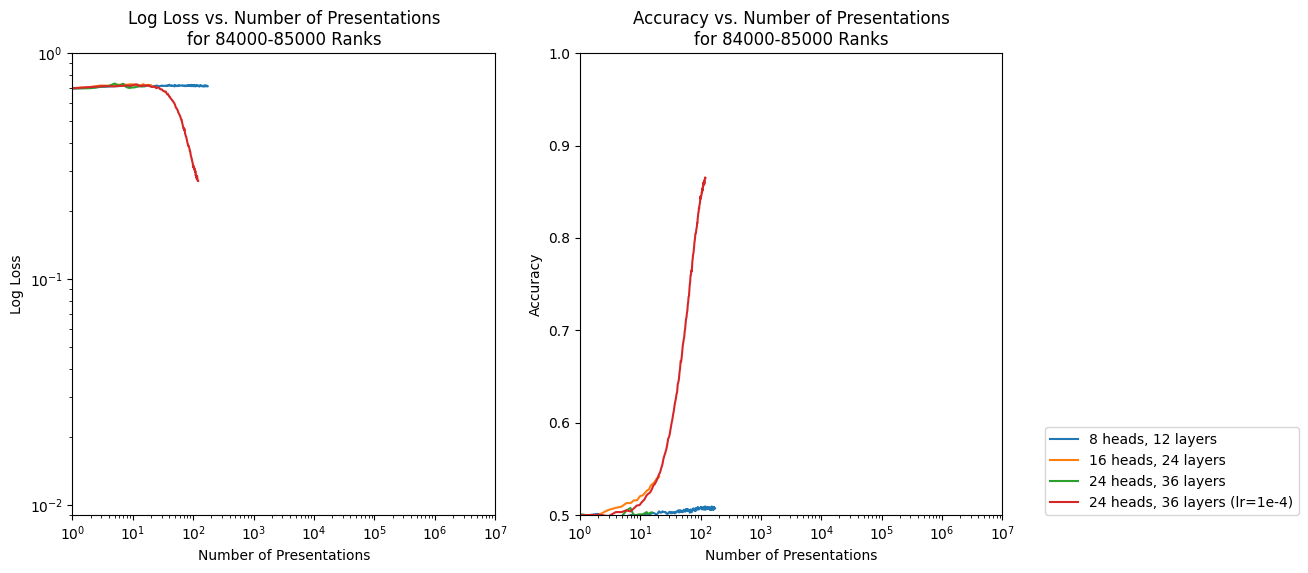

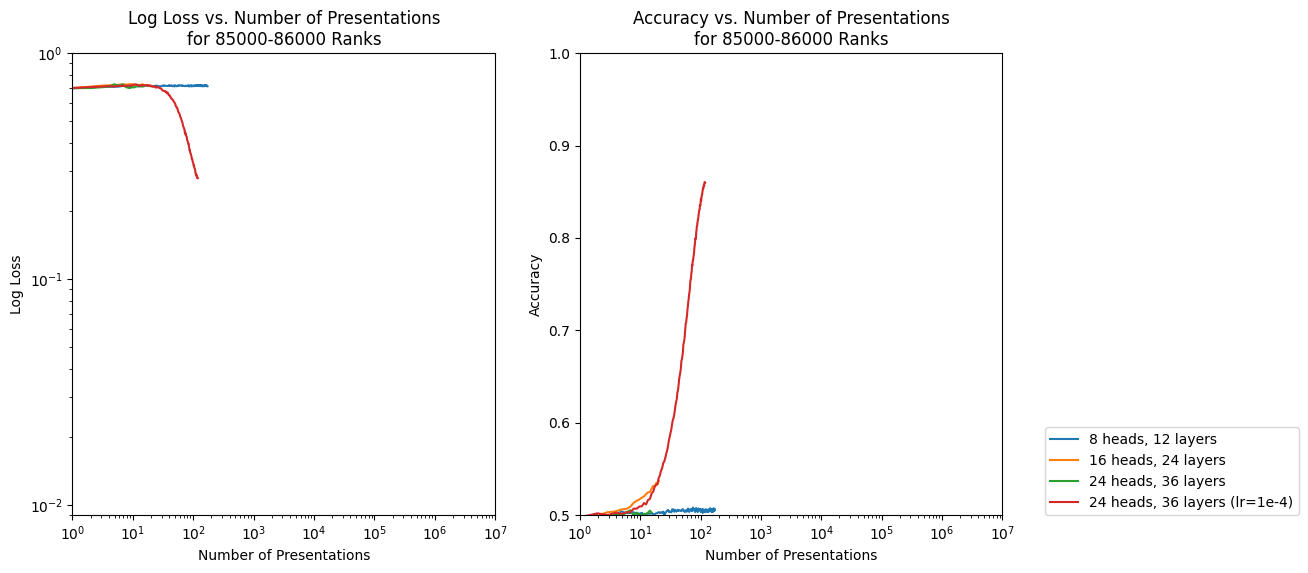

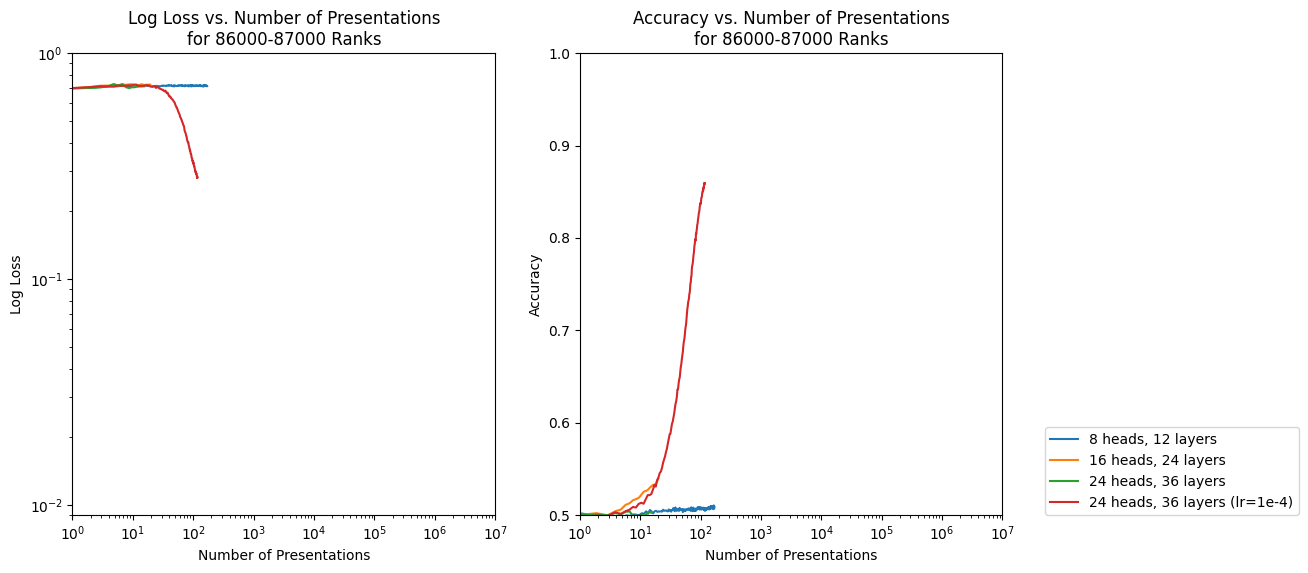

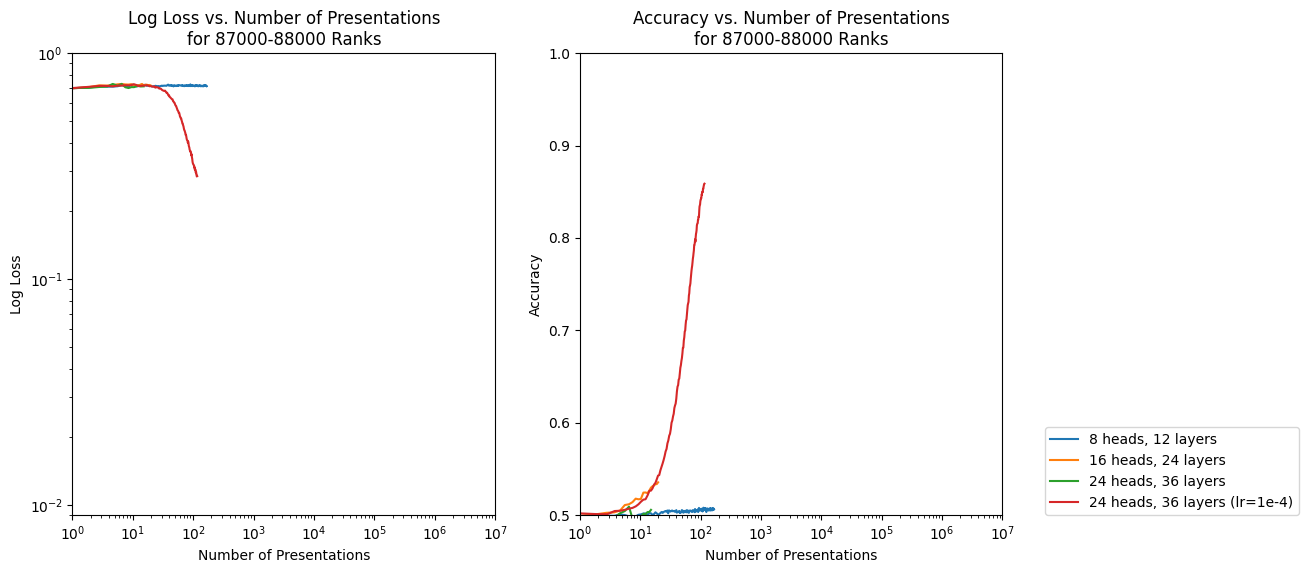

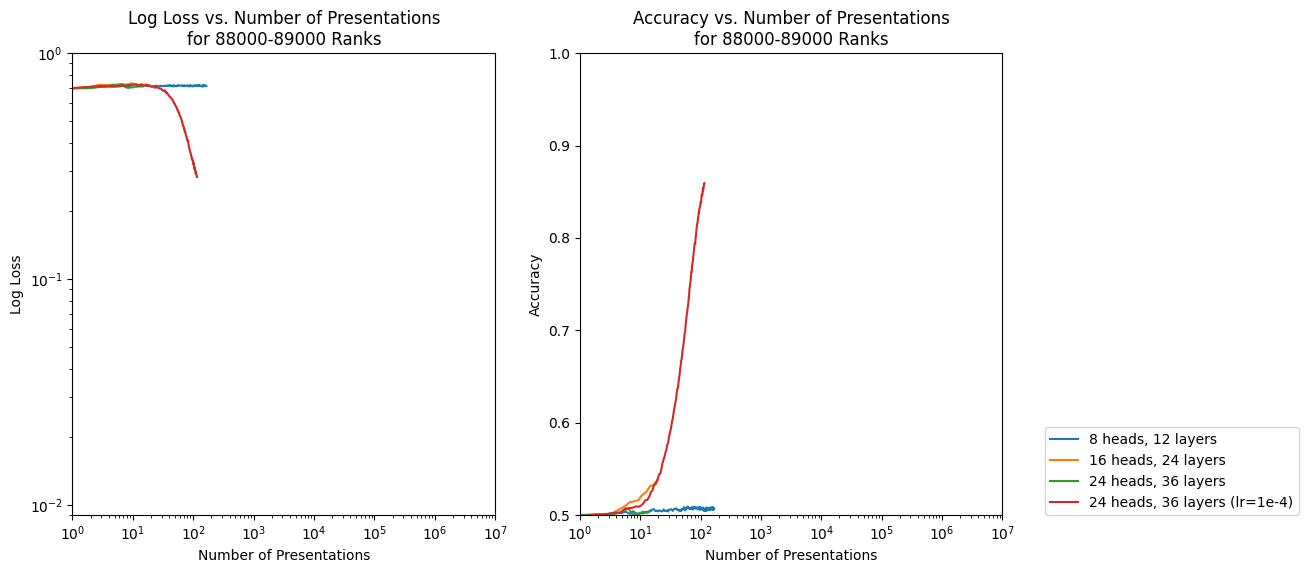

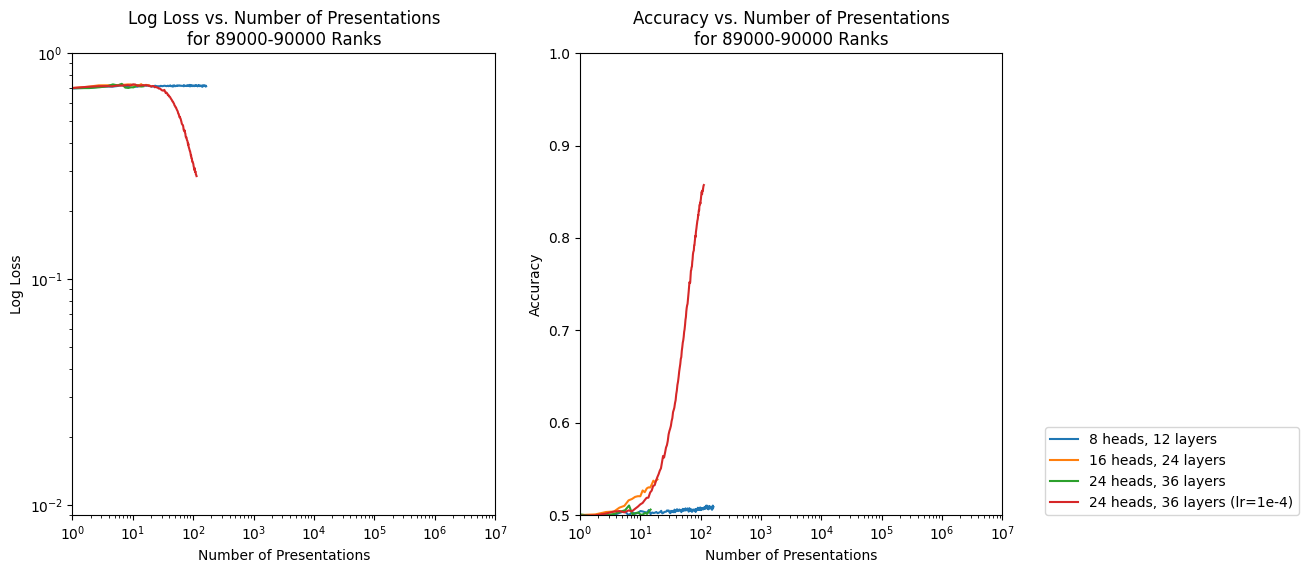

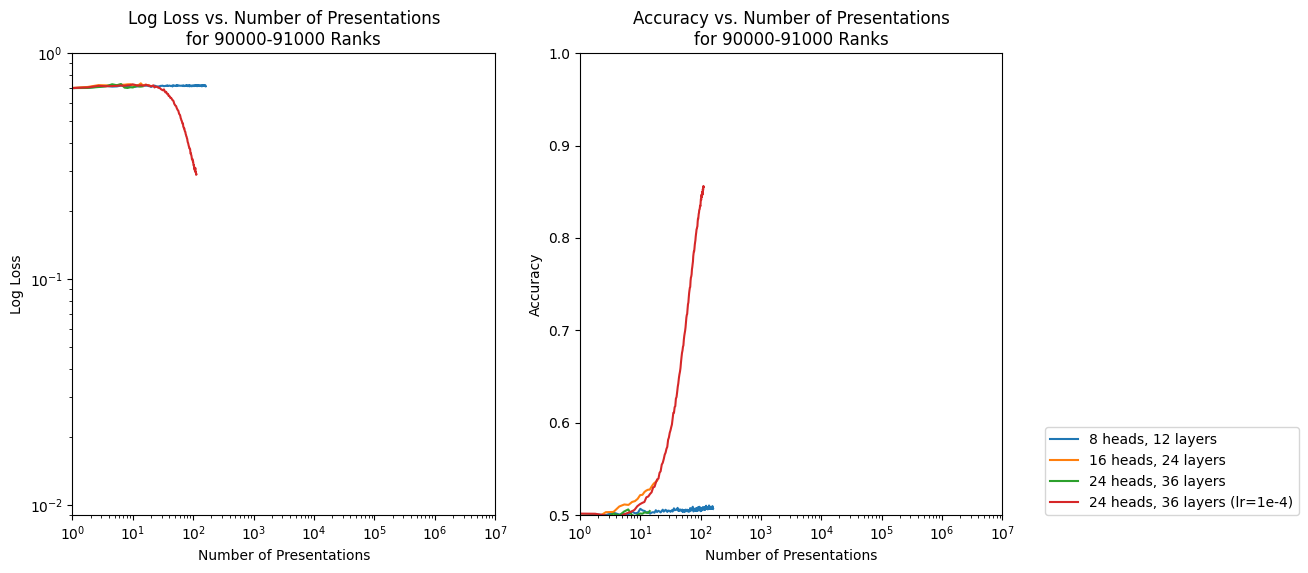

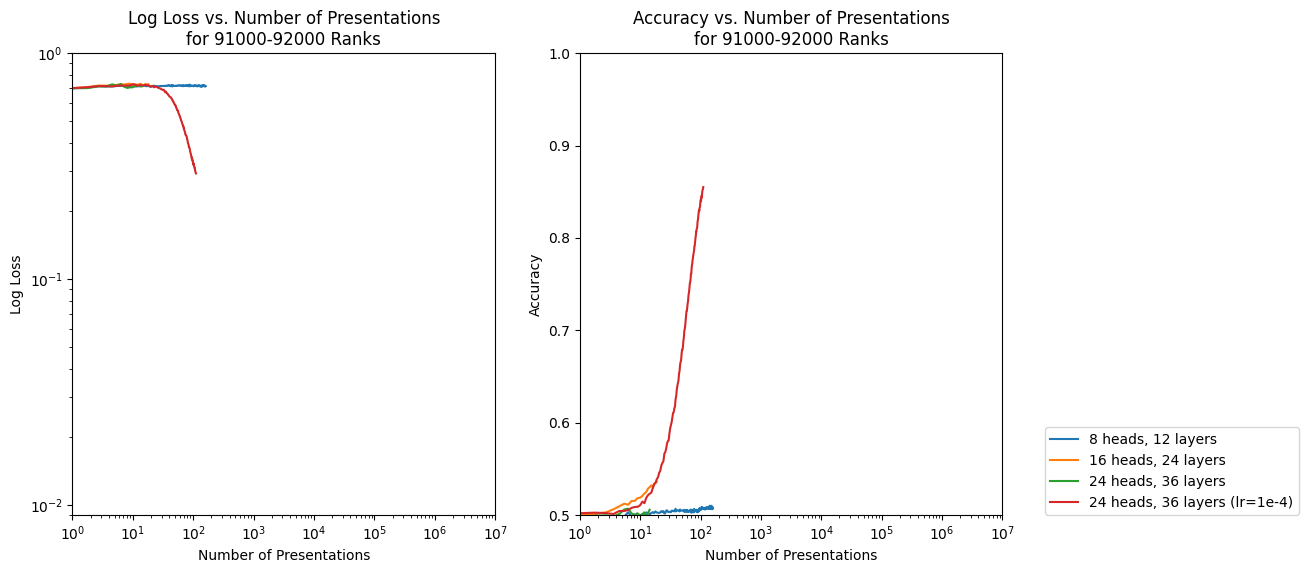

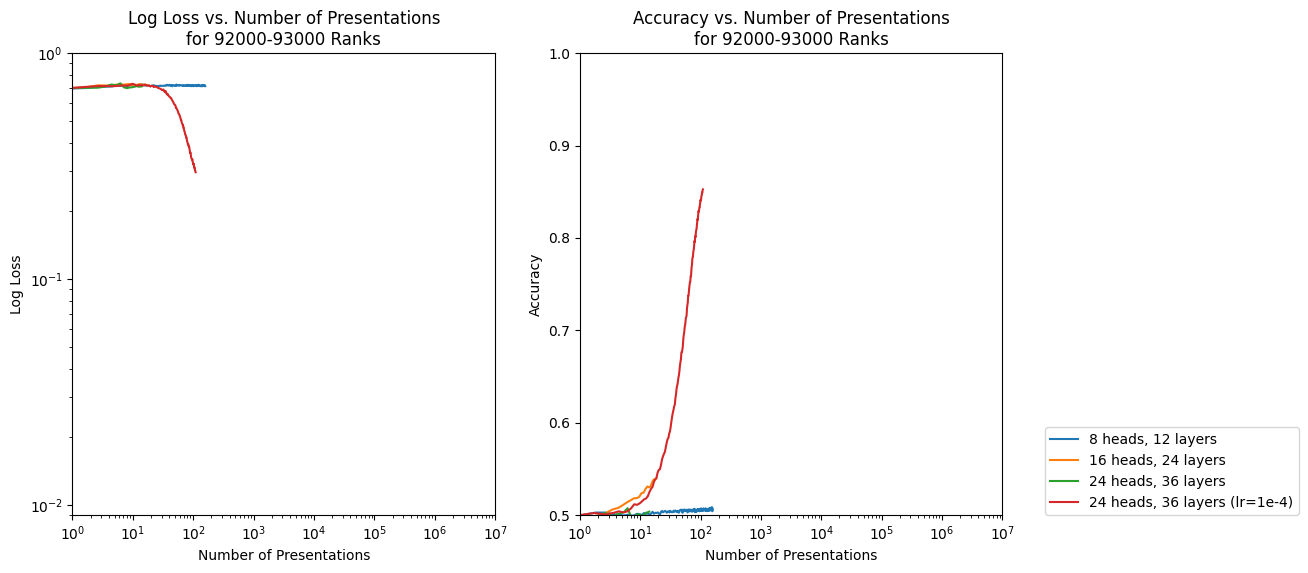

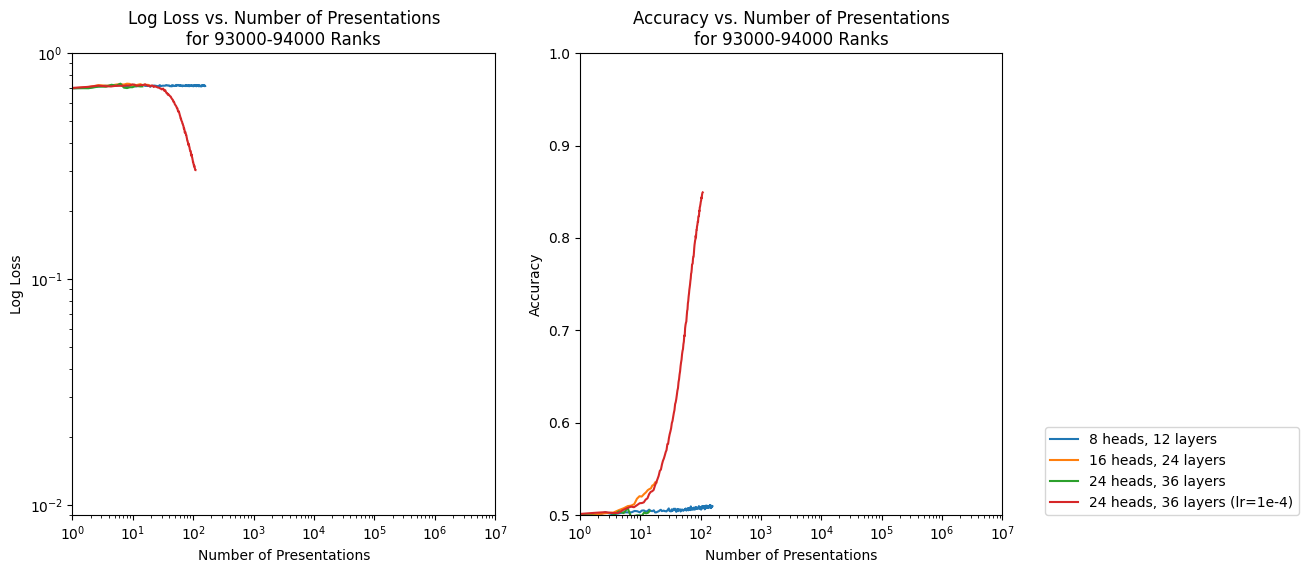

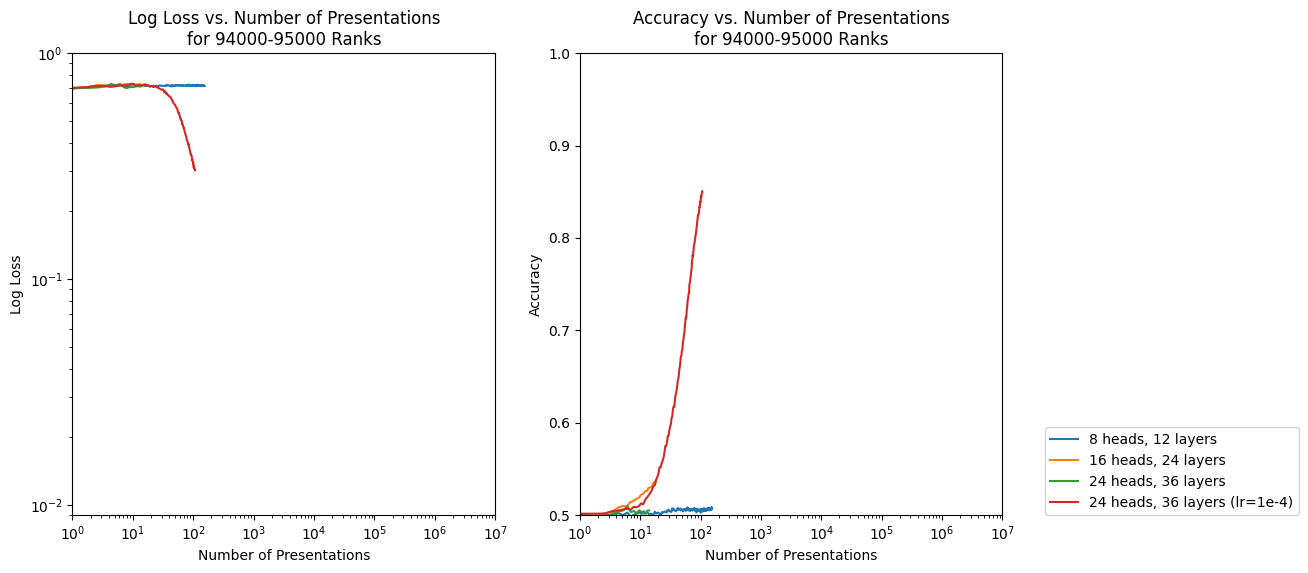

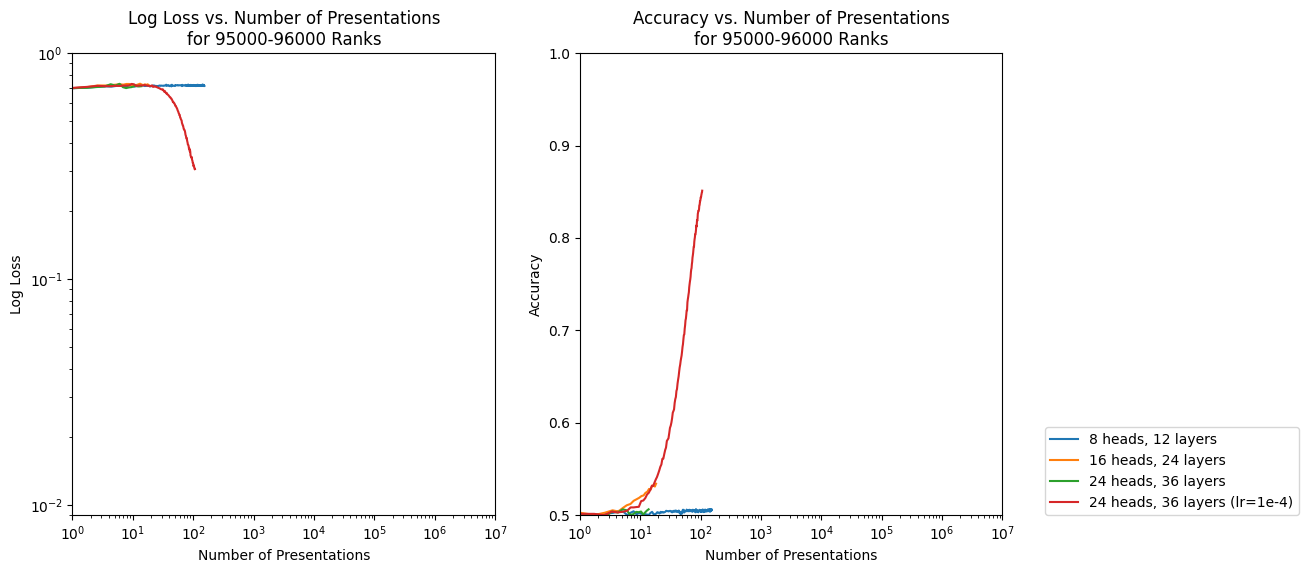

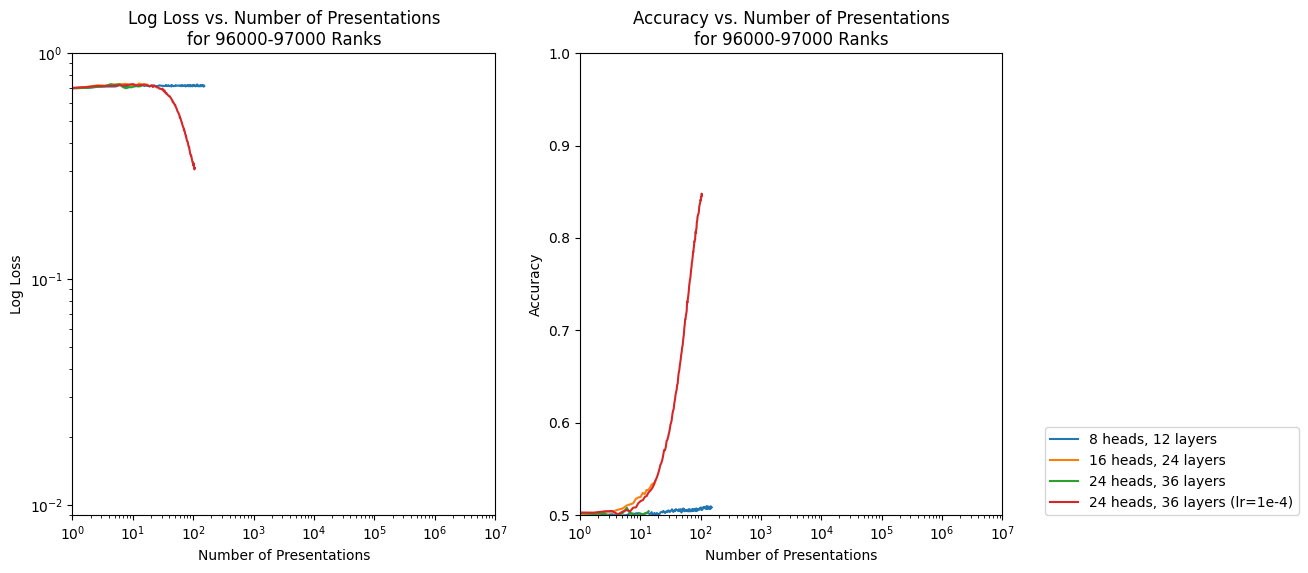

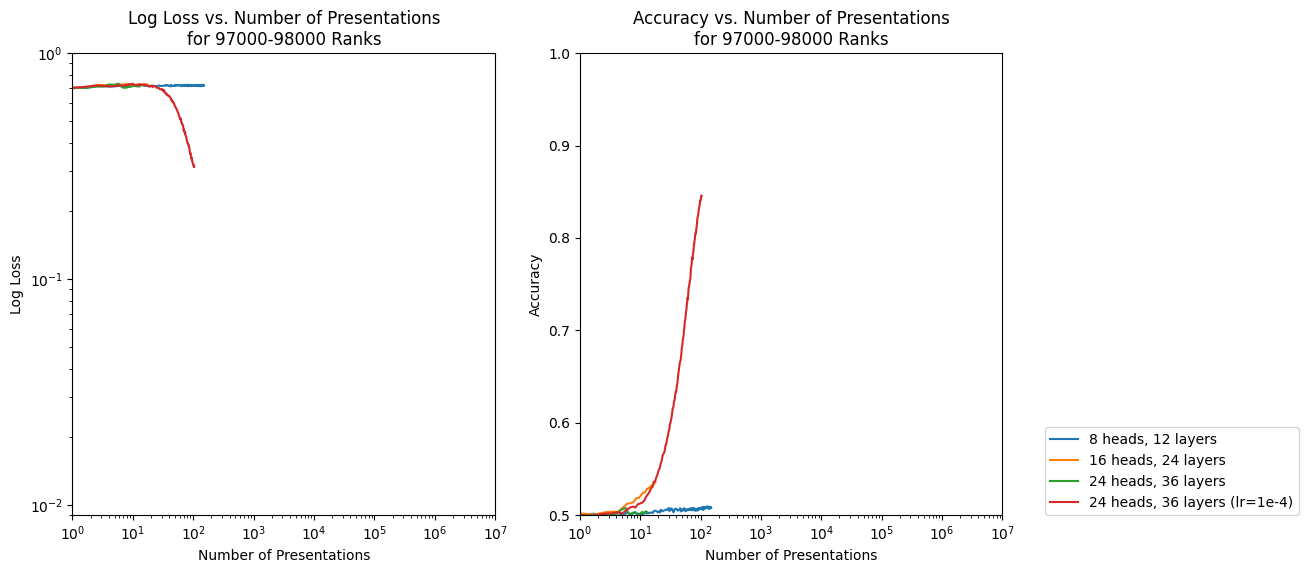

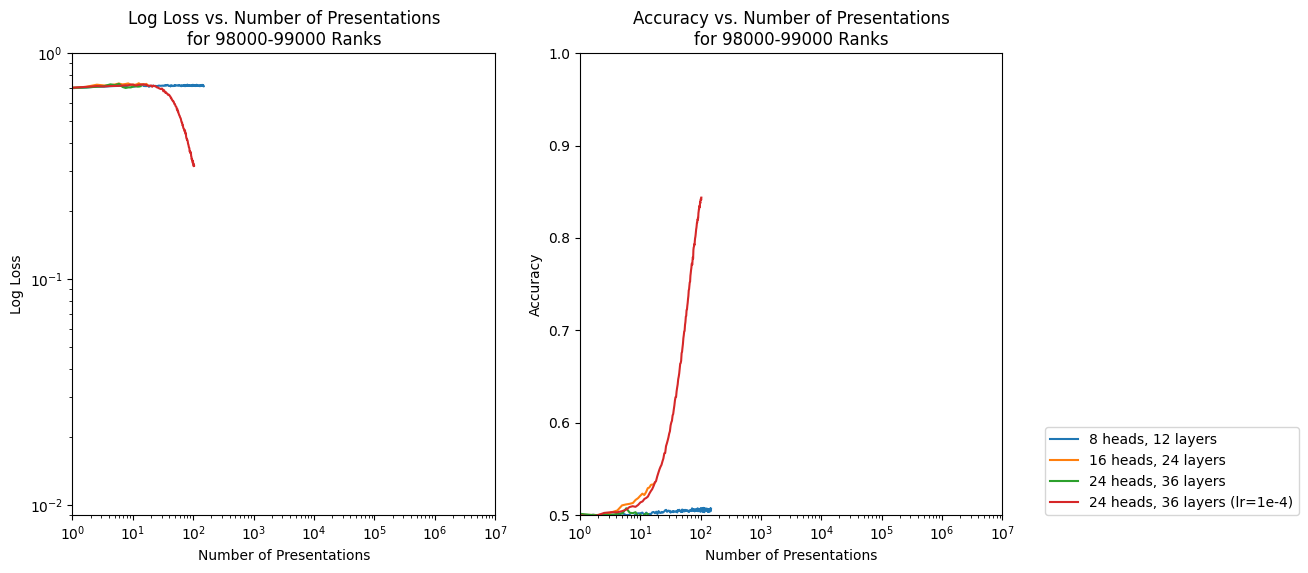

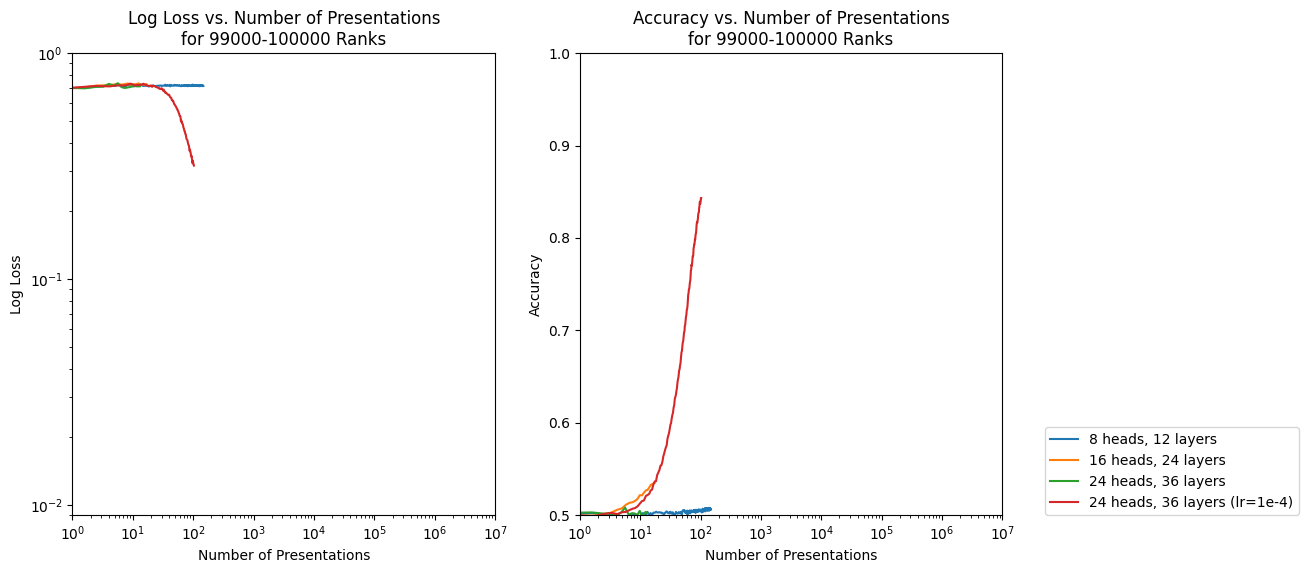

In [50]:
importlib.reload(analysis)
analysis.main(args = argparse.Namespace(experiment="all", rank_selection="selected", force_reprocess=False, no_show_plots=False, no_save_plots=True, comparative=True)   )